<a href="https://colab.research.google.com/github/bolingooli/Onlab/blob/main/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

## 0.1 Imports

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

## 0.2 Helpers

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(in_, out, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=(28,14), title=None):
  
  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim))
      ax.axis('off')
      
  plt.suptitle(title)
  plt.show()

## 0.3 Globals

In [ ]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# 1. Prepare Dataset

## 1.1. Load MNIST and cover half of the pictures

In [ ]:
# set batch size
batch_size = 256

In [ ]:
# transforms
def leftcropper(x):
  x=transforms.ToTensor()(x)
  return torchvision.transforms.functional.crop(x,0,0,28,14)

def rightcropper(x):
  x=transforms.ToTensor()(x)
  return torchvision.transforms.functional.crop(x,0,14,28,14)

def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

#transformer=transforms.Compose([binarizer,cropper,transforms.Resize((28,14))])

In [ ]:
#making train dataset

right_ds_train = MNIST("./bin_data1", train=True, transform=transforms.Compose([rightcropper,transforms.Resize((28,14))]), download=True)
right = []
#getting the images
for batch_idx, (img, targets) in enumerate(right_ds_train):
  right.append(img)
right=torch.stack(right)

left_ds_train = MNIST("./bin_data1", train=True, transform=transforms.Compose([leftcropper,transforms.Resize((28,14))]), download=True)
left = []
#getting the images
for batch_idx, (img, targets) in enumerate(left_ds_train):
  left.append(img)
left=torch.stack(left)

#pairing left pictures with right pictures
ds_train=TensorDataset(left,right)
ds_train_loader=DataLoader(ds_train,batch_size,shuffle=True,num_workers=1,pin_memory=cuda)


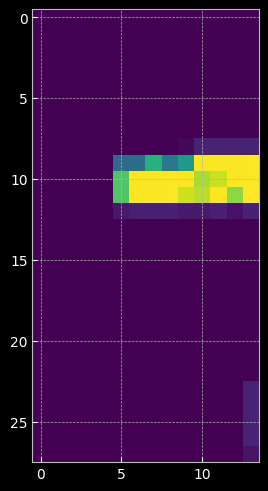

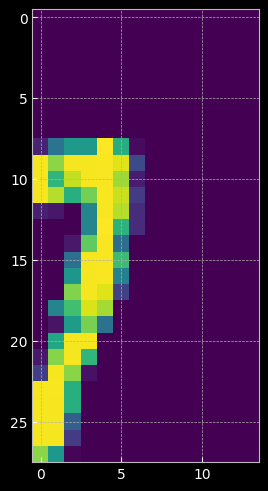

In [ ]:

for x,y in ds_train_loader:
  plt.imshow(x[10].squeeze())
  plt.show()
  plt.imshow(y[10].squeeze())
  plt.show()
  break


In [ ]:
#making test dataset
right_ds_test = MNIST("./bin_data1", train=False, transform=transforms.Compose([rightcropper,transforms.Resize((28,14))]), download=False)
right = []
for batch_idx, (img, targets) in enumerate(right_ds_test):
  right.append(img)
right=torch.stack(right)

left_ds_test = MNIST("./bin_data1", train=False, transform=transforms.Compose([leftcropper,transforms.Resize((28,14))]), download=False)
left = []
for batch_idx, (img, targets) in enumerate(left_ds_test):
  left.append(img)
left=torch.stack(left)


ds_test=TensorDataset(left,right)
ds_test_loader=DataLoader(ds_test,batch_size,shuffle=True,num_workers=1,pin_memory=cuda)

torch.Size([1, 28, 14])


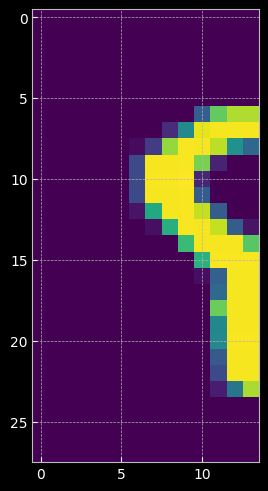

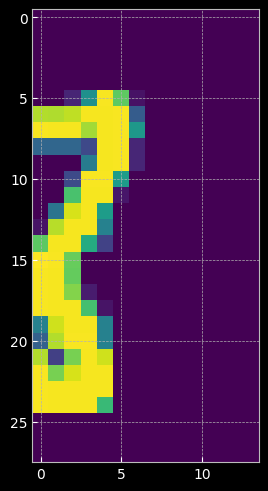

In [ ]:
for x,y in ds_test_loader:
  print(x[63].shape)
  plt.imshow(x[63].squeeze())
  plt.show()
  plt.imshow(y[63].squeeze())
  plt.show()
  break

# 2. VAE

## 2.1. Setting up the model

### 2.1.1 Implement a VAE Module

In [ ]:
# hyper params
latent_size = 256
featureDim= 6080

In [ ]:
from torch.nn.modules.linear import Linear
from torch.nn.modules.conv import Conv2d
class VAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoderConv = nn.Sequential(
            nn.Conv2d(1,16,4),
            nn.ReLU(),
            nn.Conv2d(16,32,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4),
            nn.ReLU()
        )

        self.encoderMU = nn.Linear(featureDim,latent_size)
        self.encoderLogvar = nn.Linear(featureDim,latent_size)
        
        self.decoderLin = nn.Linear(latent_size,featureDim)

        self.decoderConv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

    def encode(self, x):
      filtered = self.encoderConv(x)
      x=filtered.view(-1,featureDim)
      mu =self.encoderMU(x)
      logvar = self.encoderLogvar(x)
      return mu, logvar

    def decode(self, z):
      z=self.decoderLin(z)
      return self.decoderConv(z.view(-1,64,19,5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((batch_size,1,n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [ ]:
# Setting the optimiser
learning_rate = 0.001

optimizer=torch.optim.RMSprop(model.parameters(),learning_rate)
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    
    #reconstruction loss (pushing the points apart)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x, reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

### 2.1.2. Generate samples from the untrained model

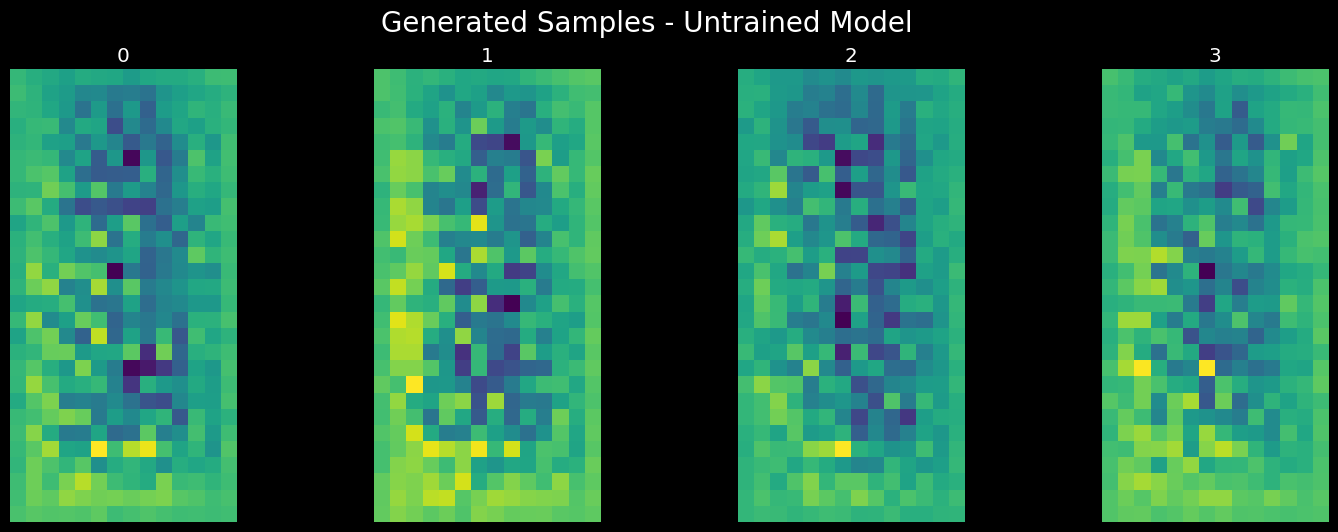

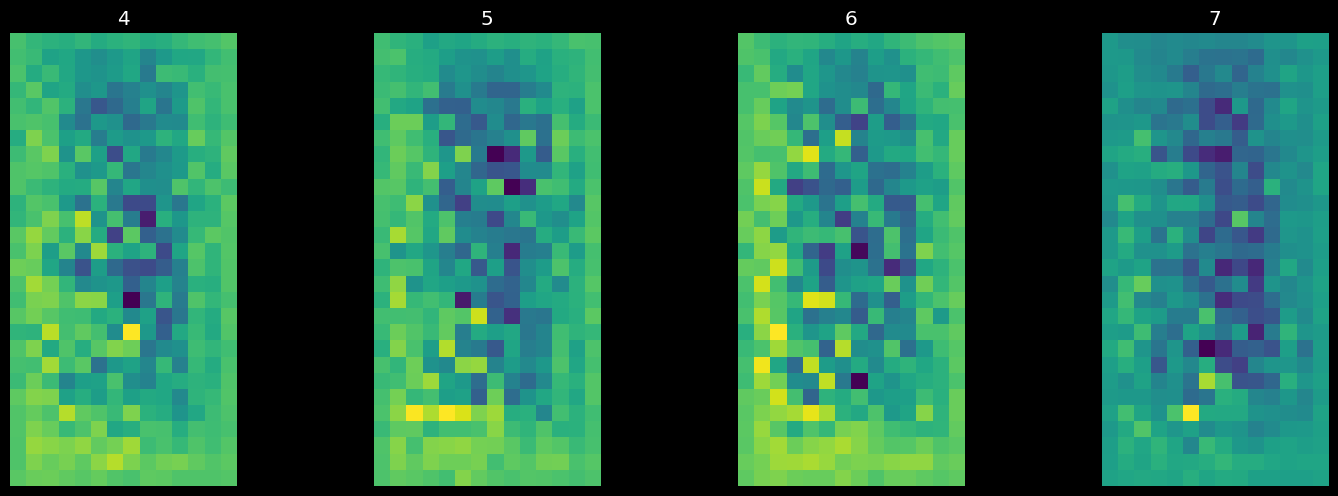

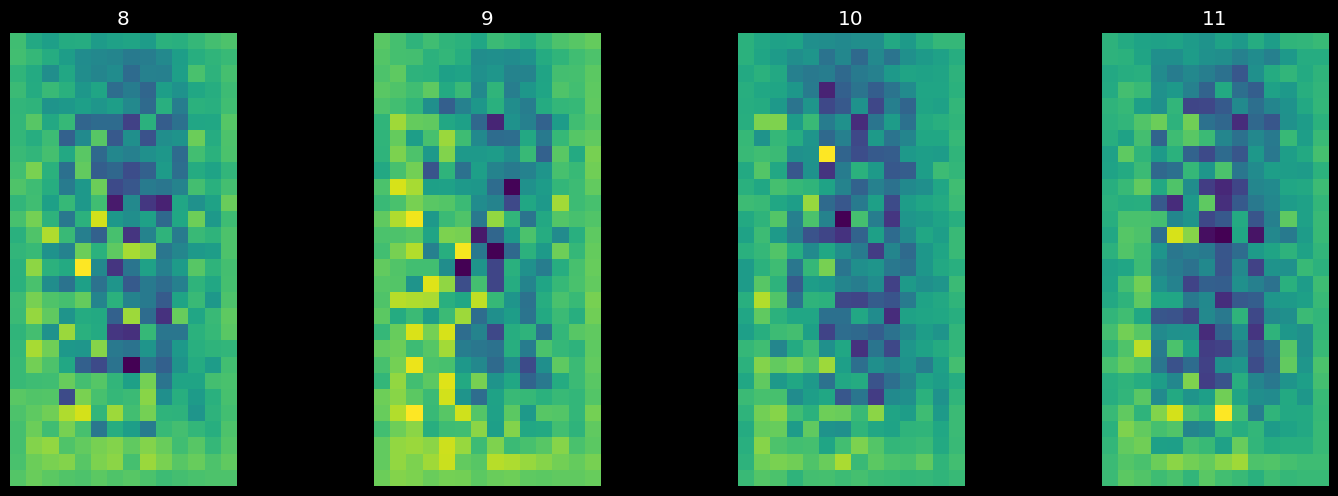

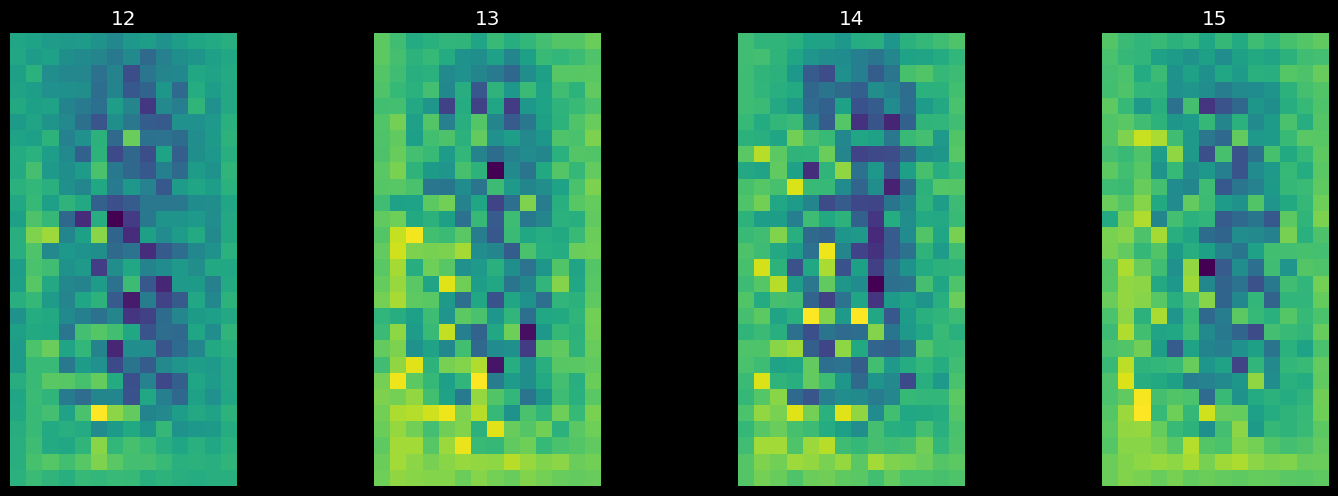

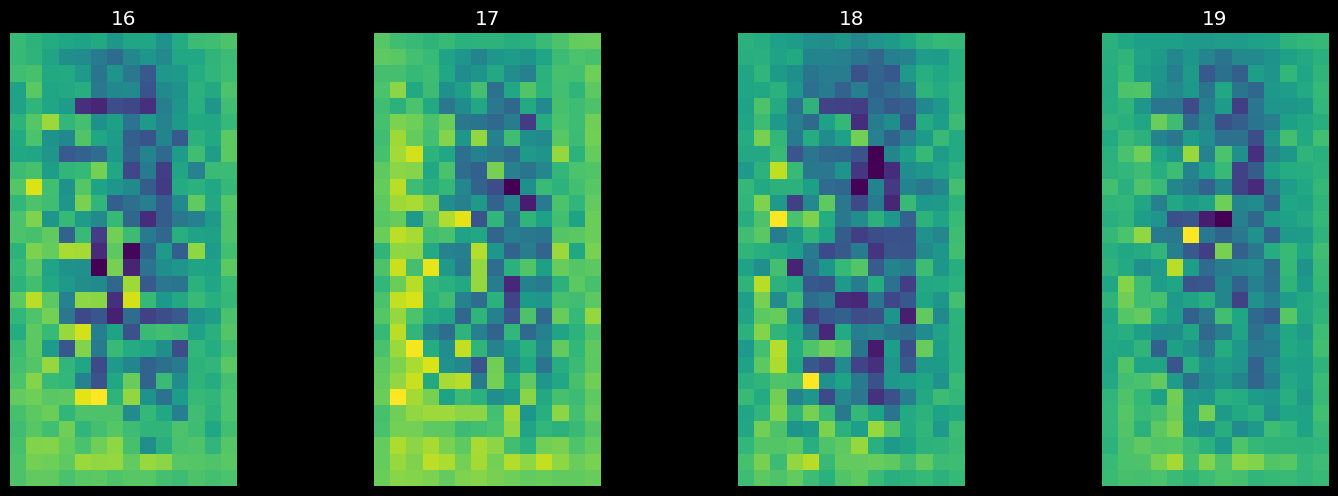

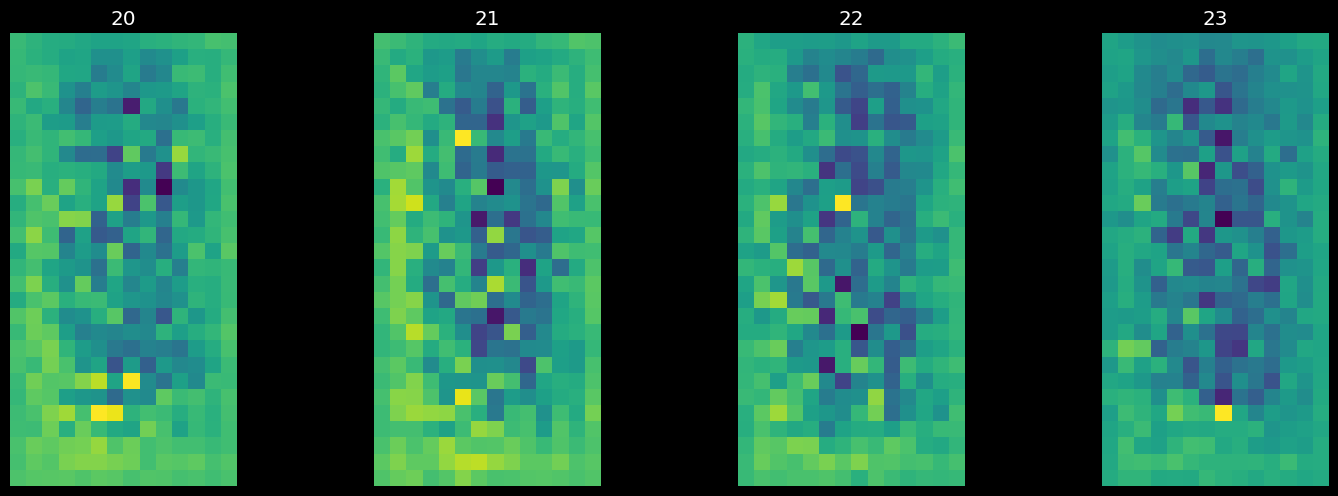

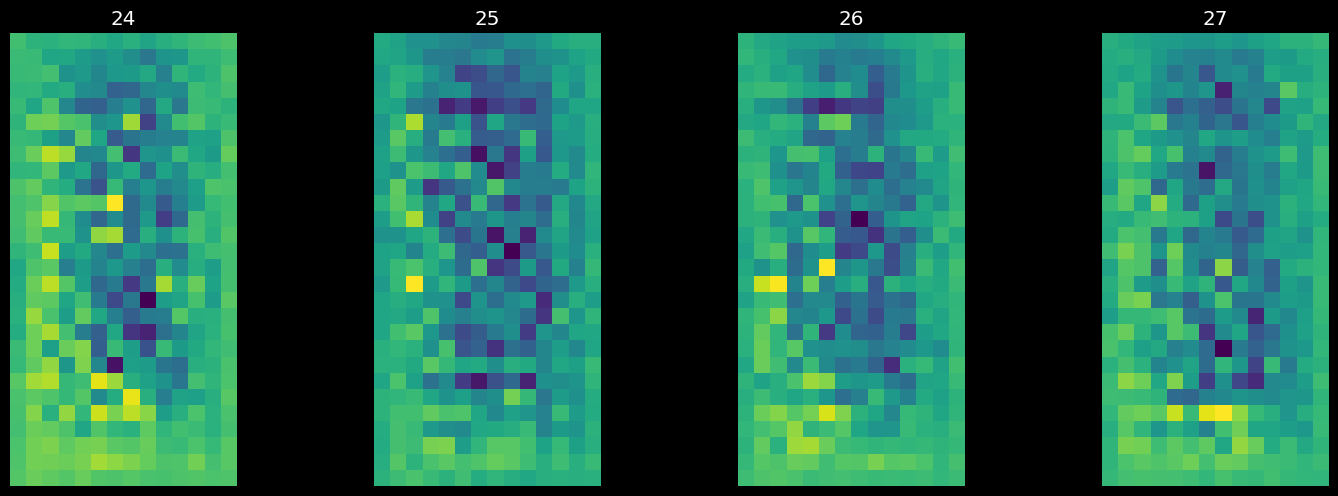

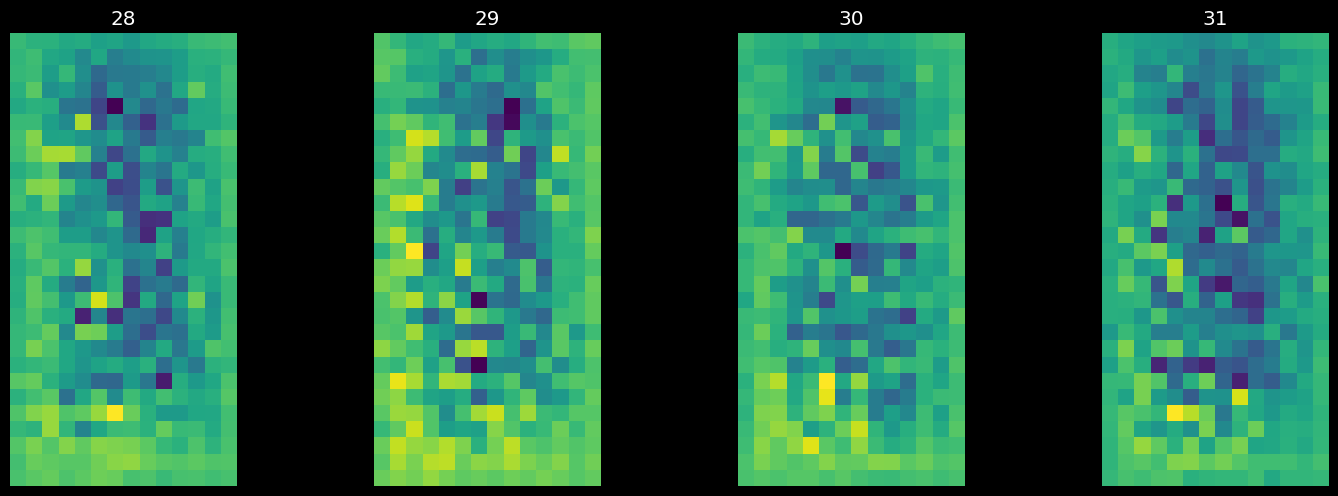

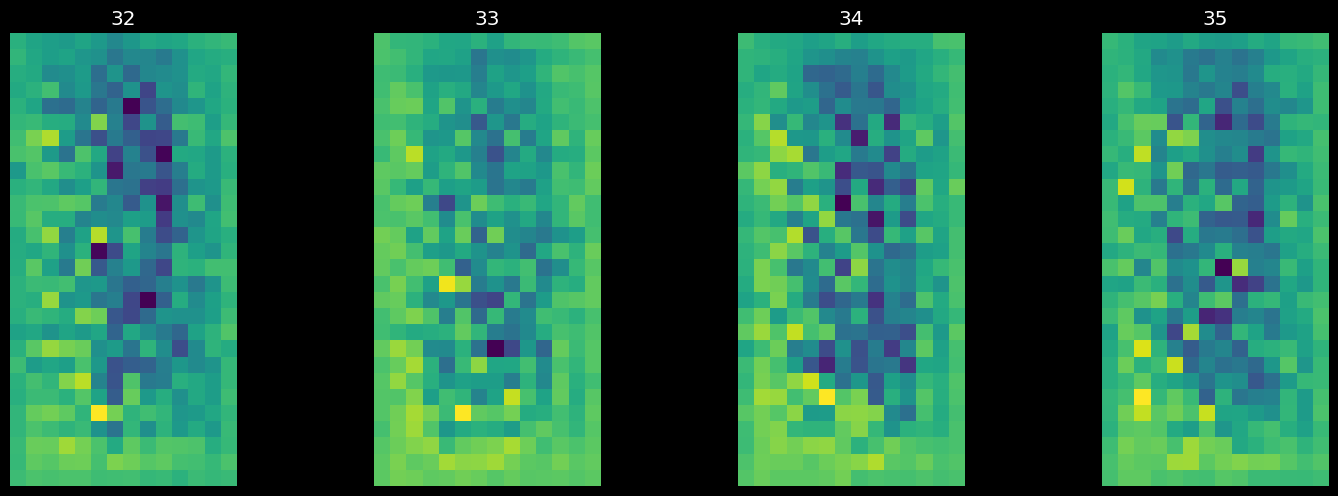

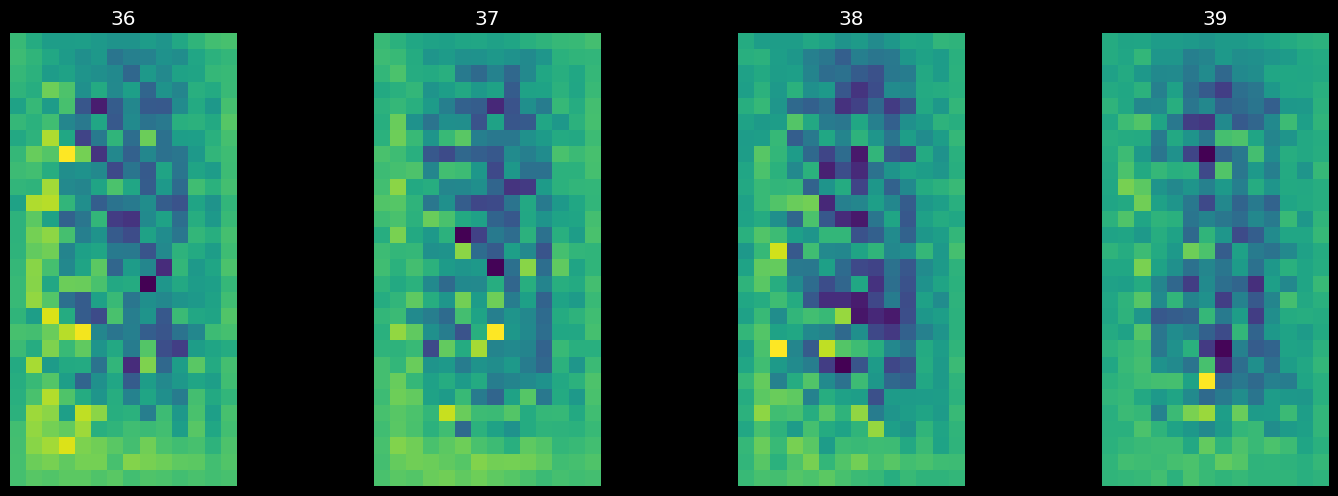

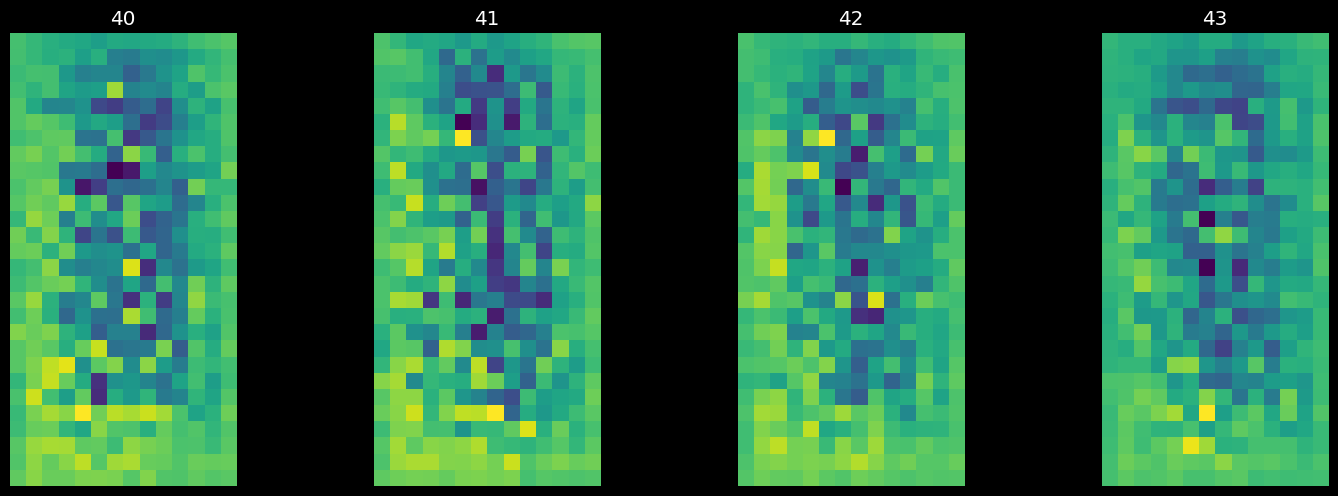

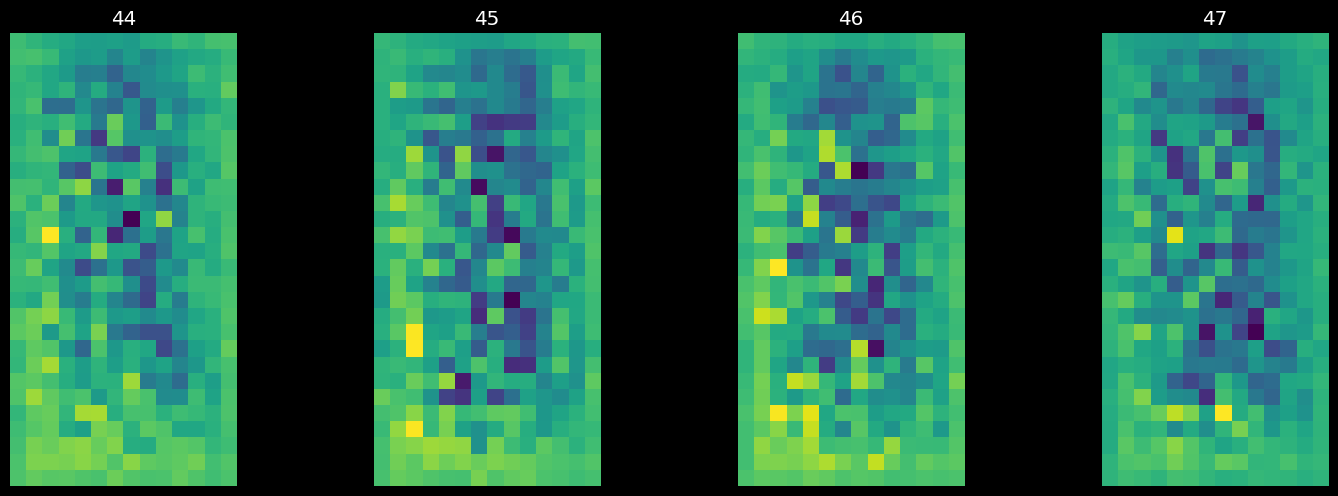

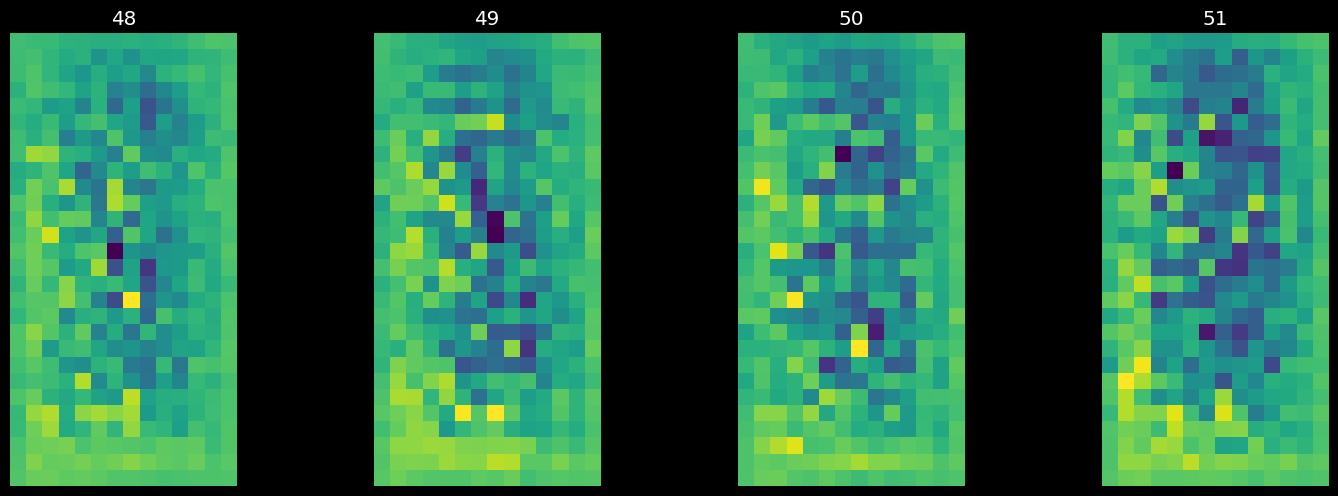

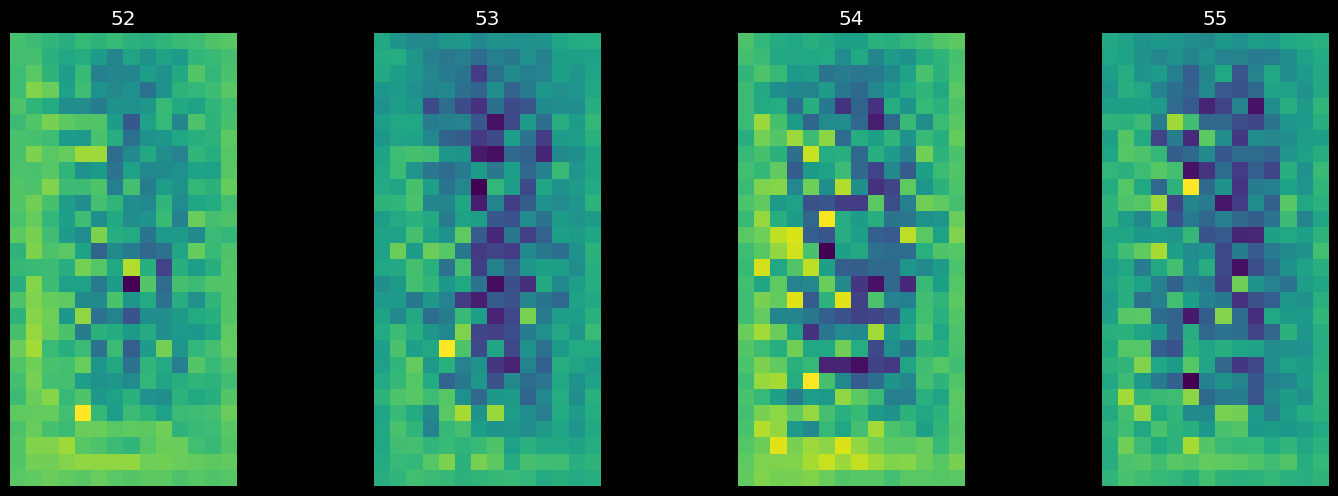

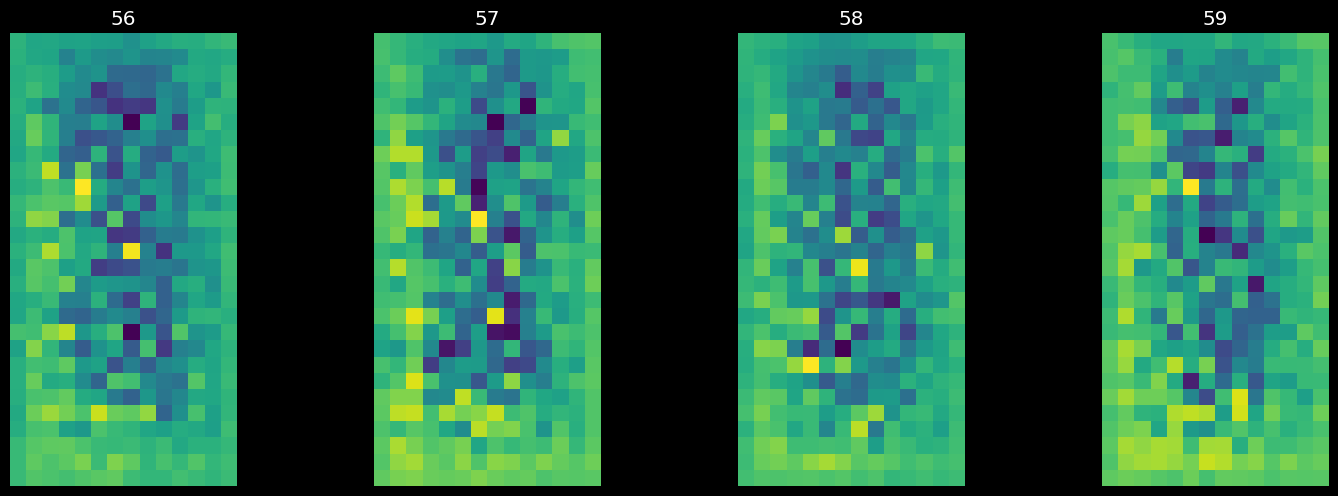

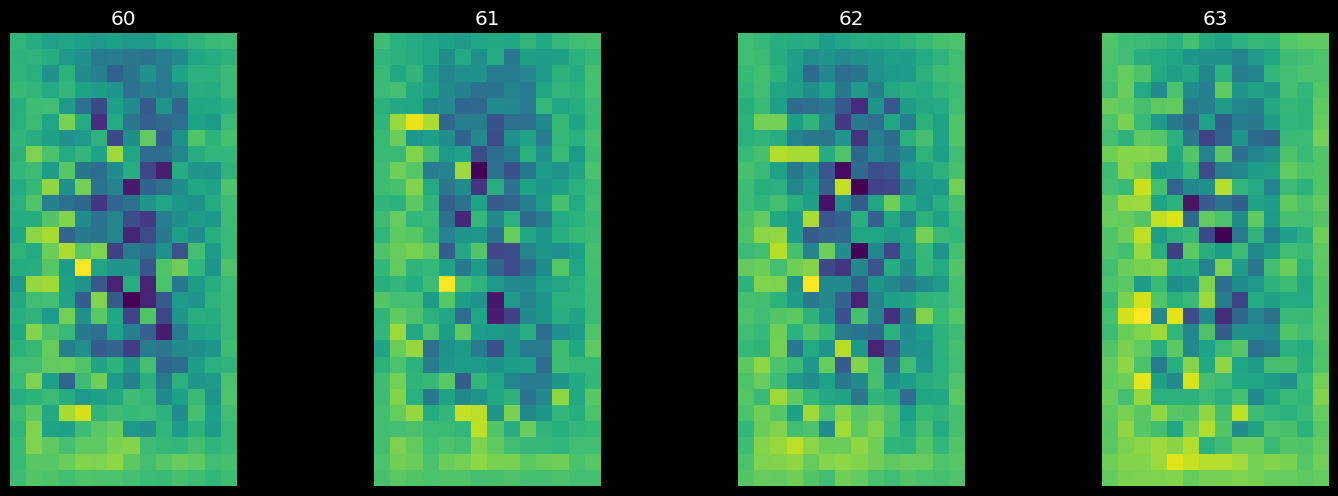

In [ ]:
# Generating 64 samples from the untrained model
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Untrained Model', 64 // 4, count=True)

### 2.1.3. ELBO of samples from training set using the untrained model

In [ ]:
# Compute the ELBO of 64 samples from the training set using the untrained model
with torch.no_grad():
  model.eval()
  # load a batch (it will be of 256 samples)
  images, full = next(iter(ds_train_loader))
  # we only want 64 samples
  only_64 = images[0:64, :, :,:]
  #full_64= full[0:64,:,:,:]
  # send them to the appropriate device
  only_64 = only_64.to(device)
  # forward
  x_hat, mu, logvar = model(only_64)
  # TODO: there is a miss-match in the dims but the size is the same
  elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 15588.0205


## 2.2. Setting up the training

### 2.2.1. Implement train and test functions

In [ ]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for left, right in ds_train_loader:
    right = right.to(device)
    left = left.to(device)
    # ===================forward=====================
    out, mu, logvar = model(left)
    loss = loss_function(out, right, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# evaluates the model on the test set
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in ds_test_loader:
      y= y.to(device)
      x = x.to(device)
      # forward
      x_hat, mu, logvar = model(x)
      test_loss += loss_function(x_hat, y, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(torch.cat((x,x_hat),3), torch.cat((x,y),3), f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

### 2.2.2. Train the model and Evaluate on the testset

====> Epoch: 1 Average train loss: 85.2647
====> Epoch: 1 Average test loss: 84.6565
====> Epoch: 2 Average train loss: 84.2500
====> Epoch: 2 Average test loss: 82.1769
====> Epoch: 3 Average train loss: 83.4305
====> Epoch: 3 Average test loss: 82.8542
====> Epoch: 4 Average train loss: 82.8606
====> Epoch: 4 Average test loss: 82.4380
====> Epoch: 5 Average train loss: 82.2367
====> Epoch: 5 Average test loss: 83.0731
====> Epoch: 6 Average train loss: 81.8021
====> Epoch: 6 Average test loss: 81.7252
====> Epoch: 7 Average train loss: 81.3644
====> Epoch: 7 Average test loss: 82.2662
====> Epoch: 8 Average train loss: 81.0756
====> Epoch: 8 Average test loss: 79.5960
====> Epoch: 9 Average train loss: 80.7399
====> Epoch: 9 Average test loss: 78.5901
====> Epoch: 10 Average train loss: 80.3750
====> Epoch: 10 Average test loss: 80.0522
====> Epoch: 11 Average train loss: 80.0051
====> Epoch: 11 Average test loss: 79.3519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


====> Epoch: 12 Average train loss: 79.7043
====> Epoch: 12 Average test loss: 77.6750
====> Epoch: 13 Average train loss: 79.4119
====> Epoch: 13 Average test loss: 80.5426
====> Epoch: 14 Average train loss: 79.1904
====> Epoch: 14 Average test loss: 79.2733
====> Epoch: 15 Average train loss: 79.0405
====> Epoch: 15 Average test loss: 77.9382
====> Epoch: 16 Average train loss: 78.8566
====> Epoch: 16 Average test loss: 77.7068
====> Epoch: 17 Average train loss: 78.6489
====> Epoch: 17 Average test loss: 79.3827
====> Epoch: 18 Average train loss: 78.4817
====> Epoch: 18 Average test loss: 78.0660
====> Epoch: 19 Average train loss: 78.3375
====> Epoch: 19 Average test loss: 77.3703
====> Epoch: 20 Average train loss: 78.2037
====> Epoch: 20 Average test loss: 77.3453
====> Epoch: 21 Average train loss: 78.1171
====> Epoch: 21 Average test loss: 76.8000
====> Epoch: 22 Average train loss: 77.9815
====> Epoch: 22 Average test loss: 78.0265
====> Epoch: 23 Average train loss: 77.8763

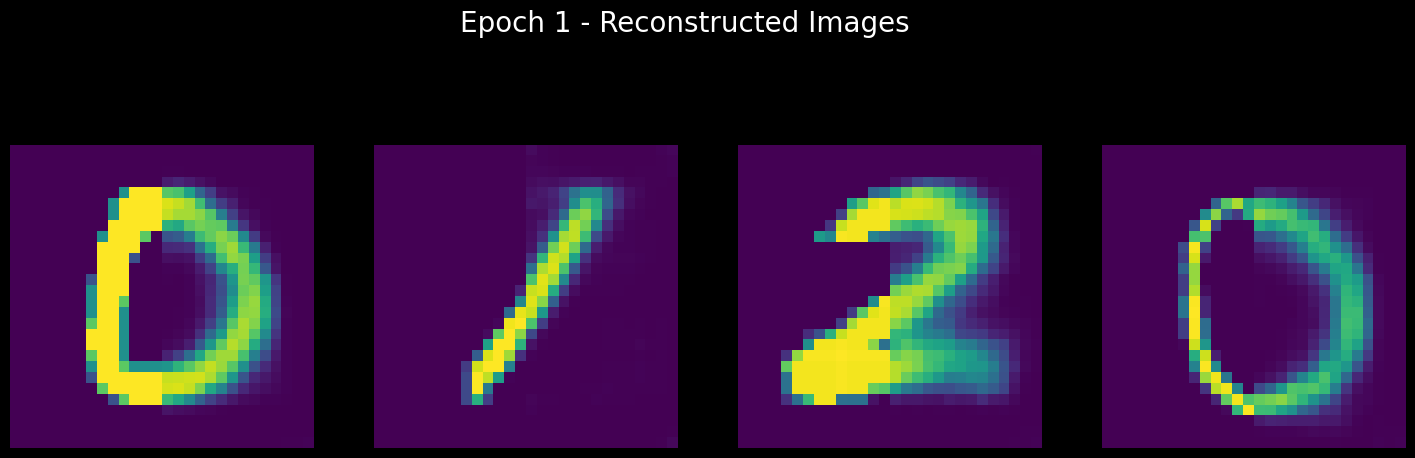

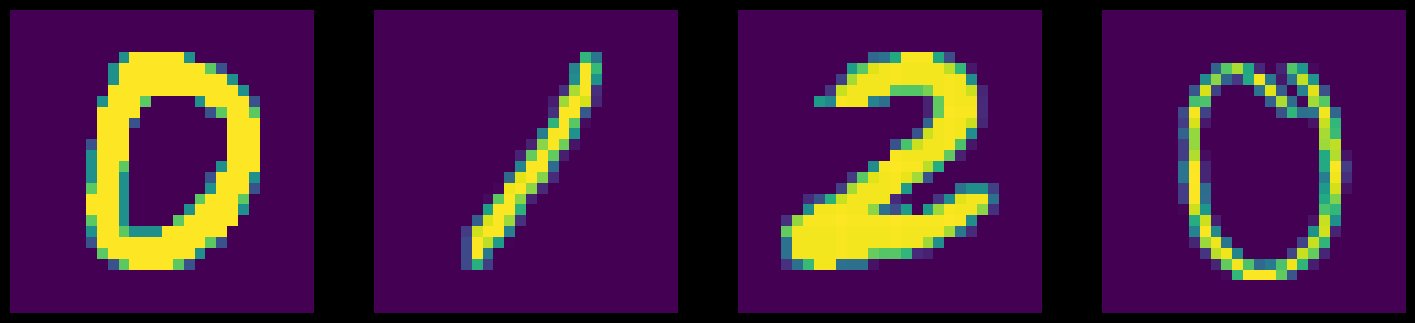

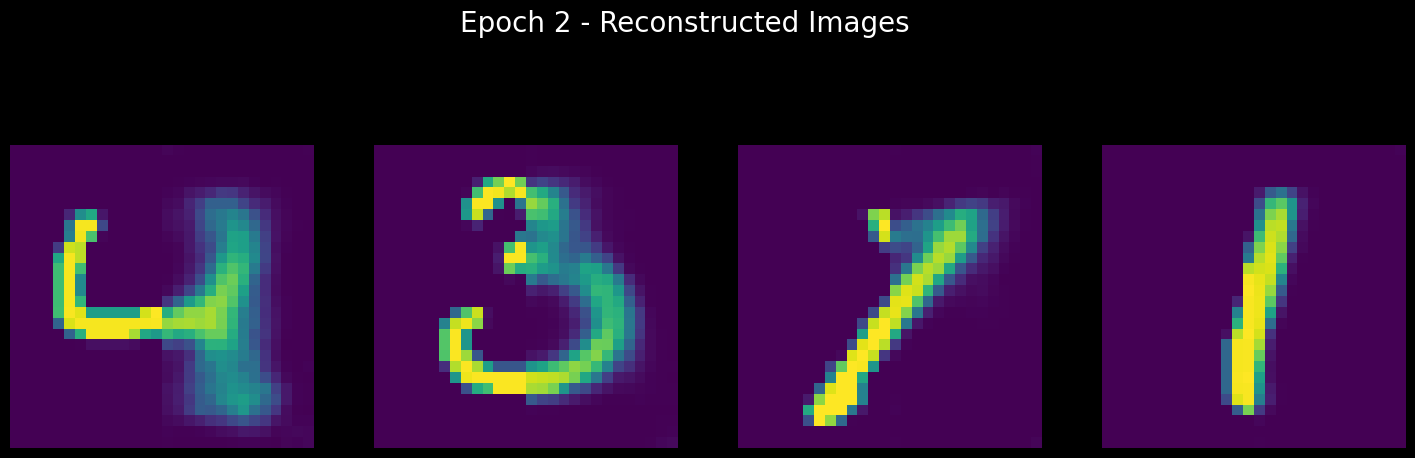

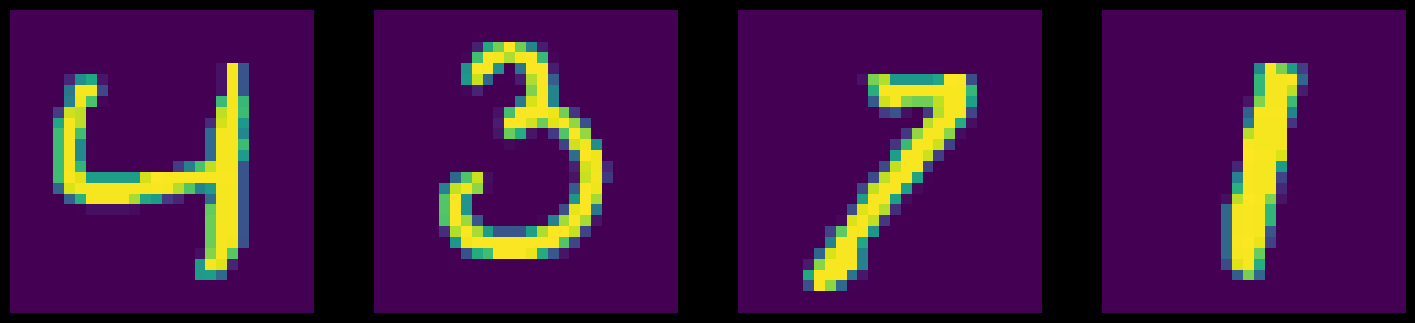

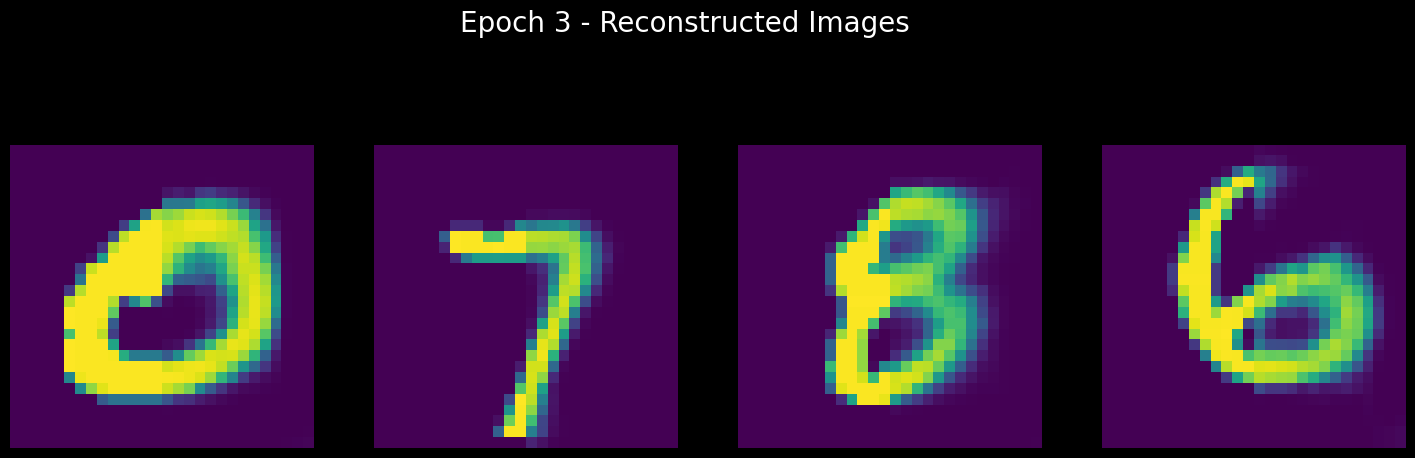

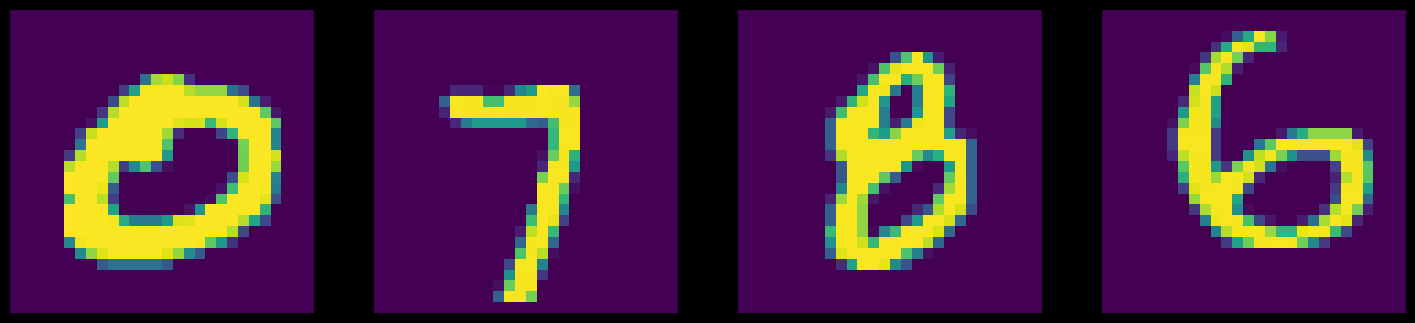

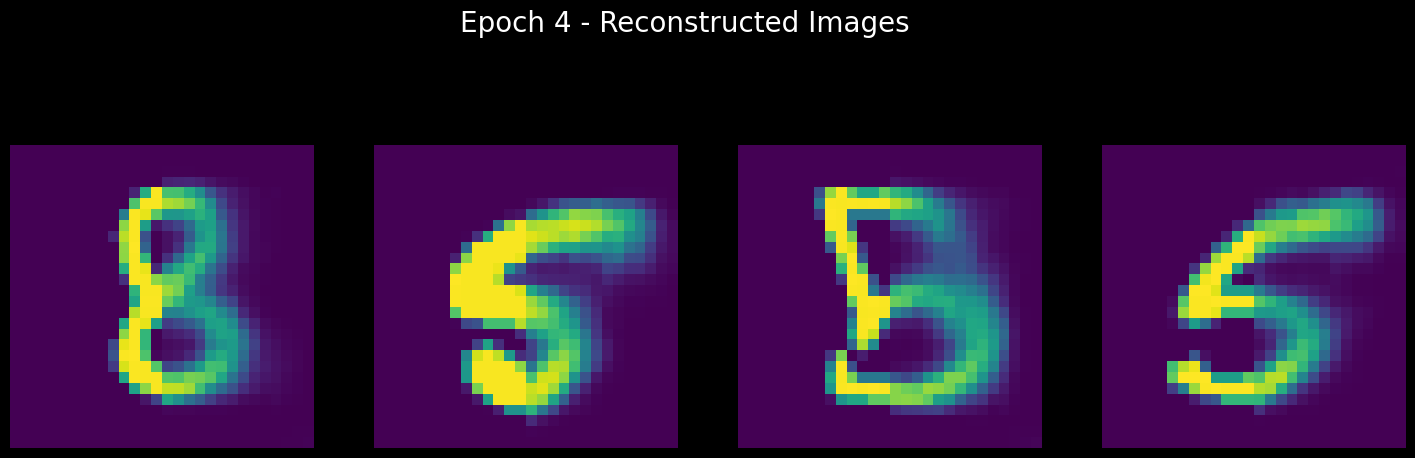

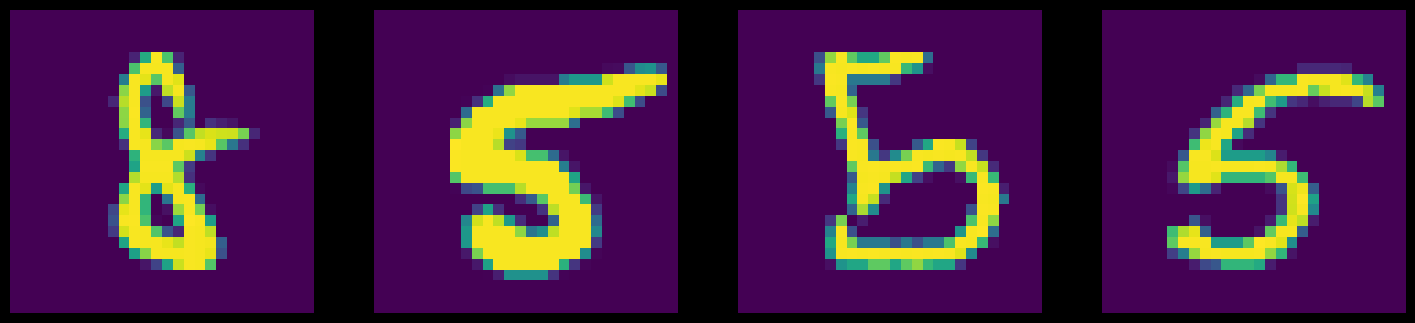

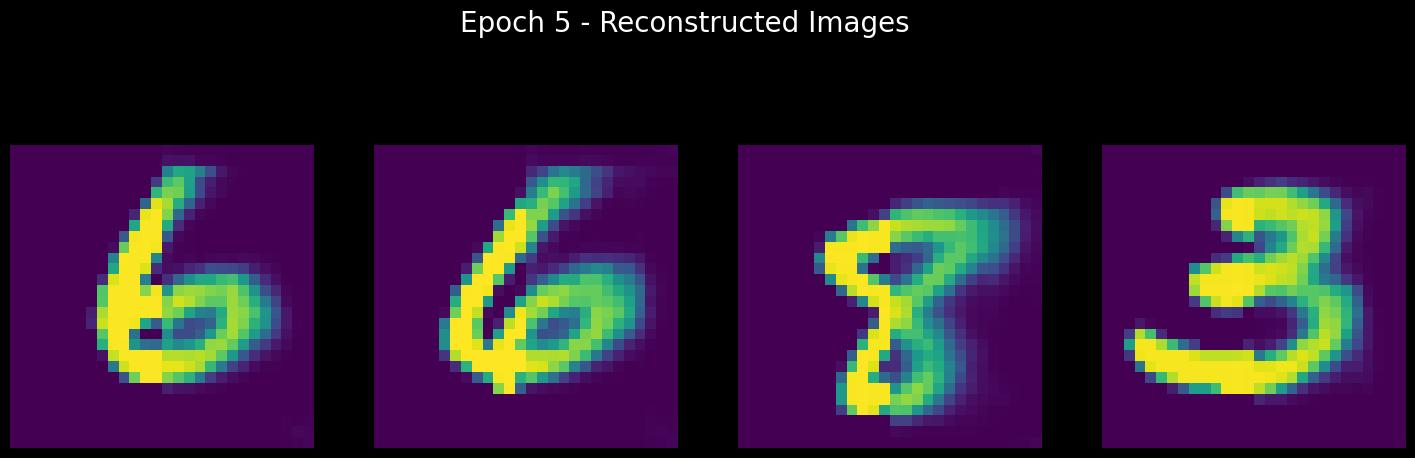

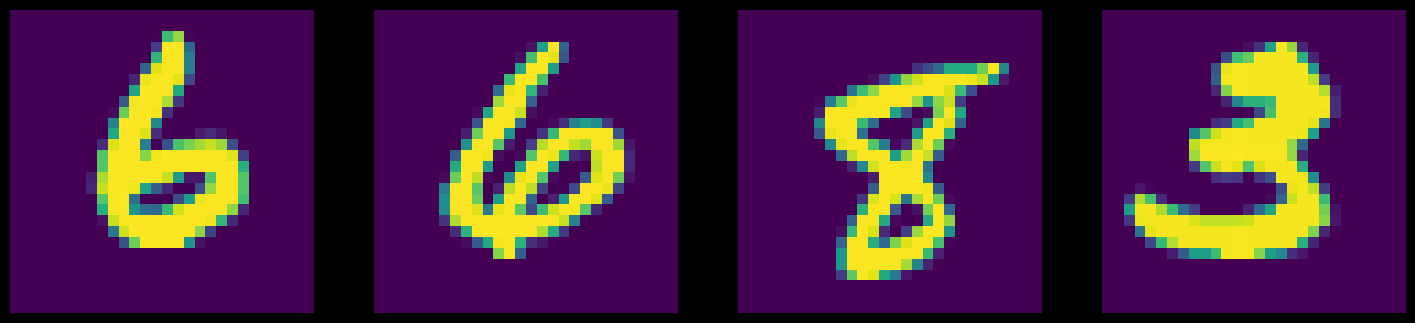

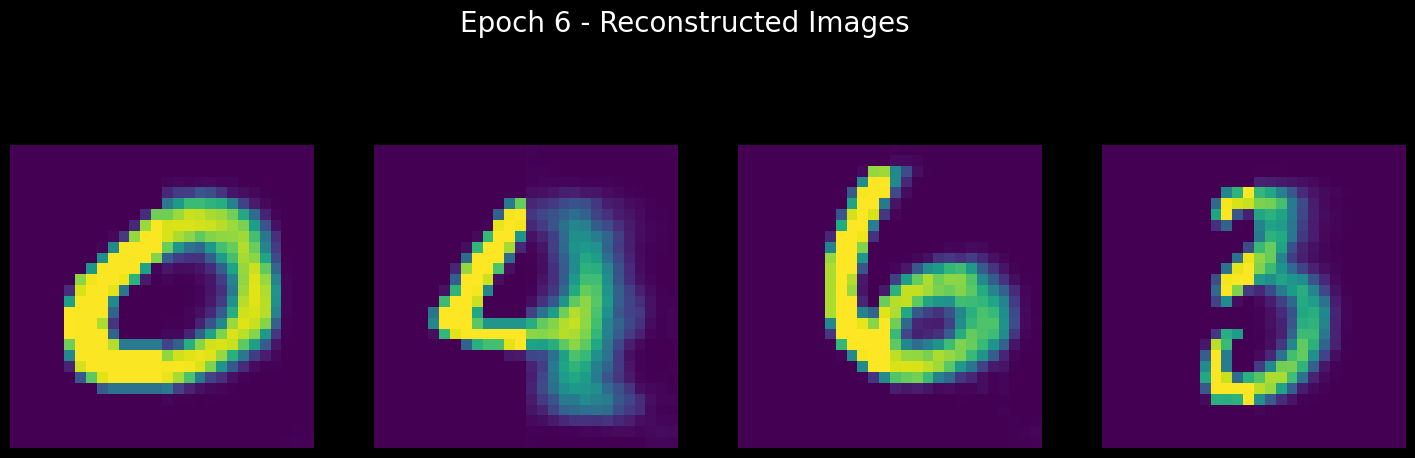

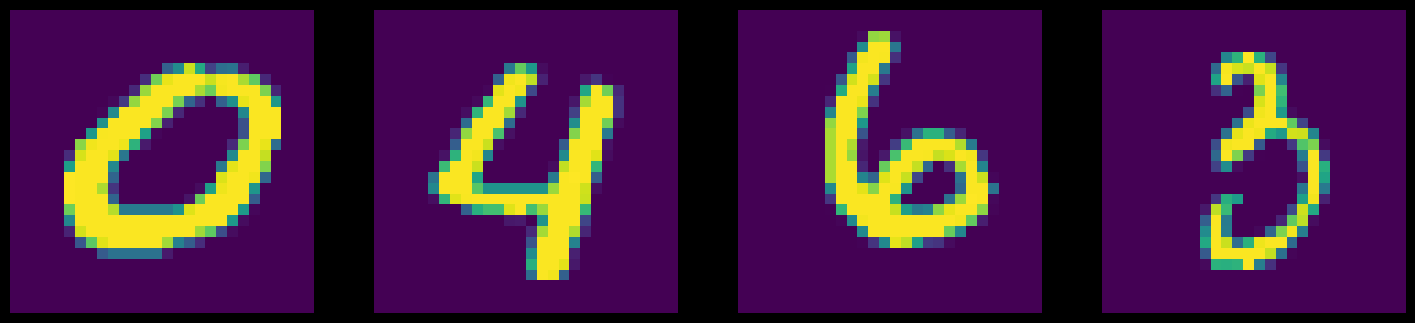

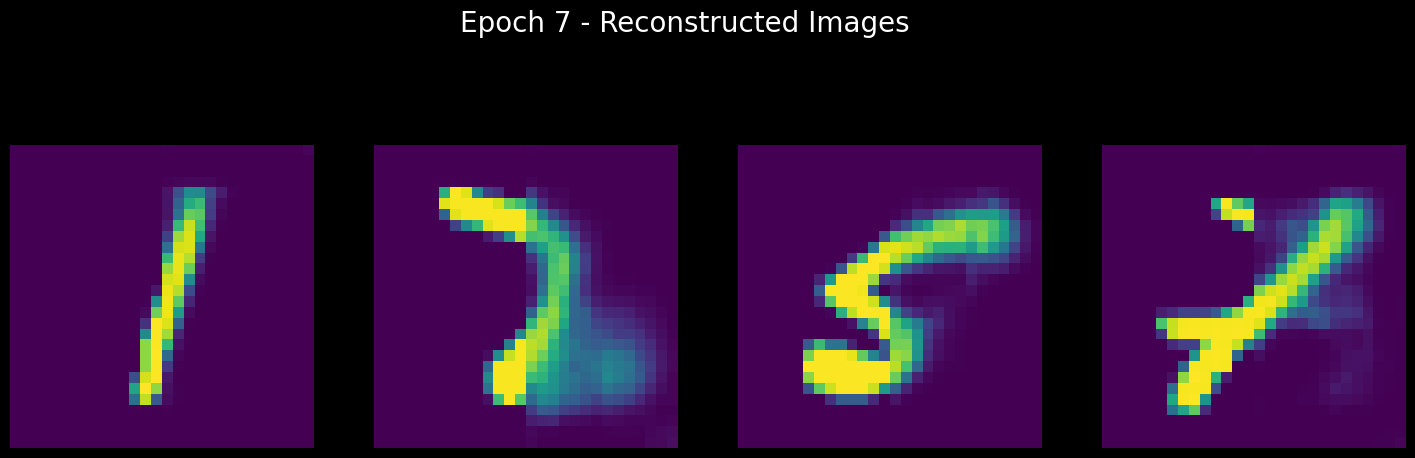

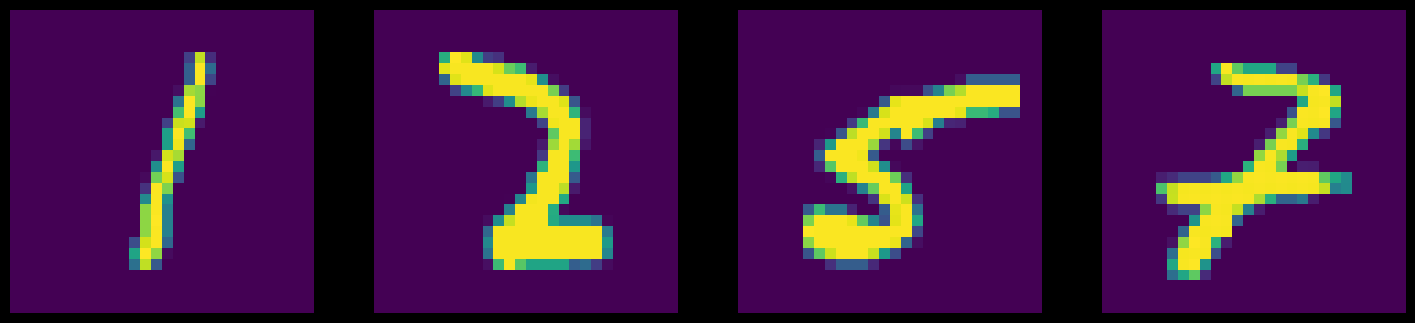

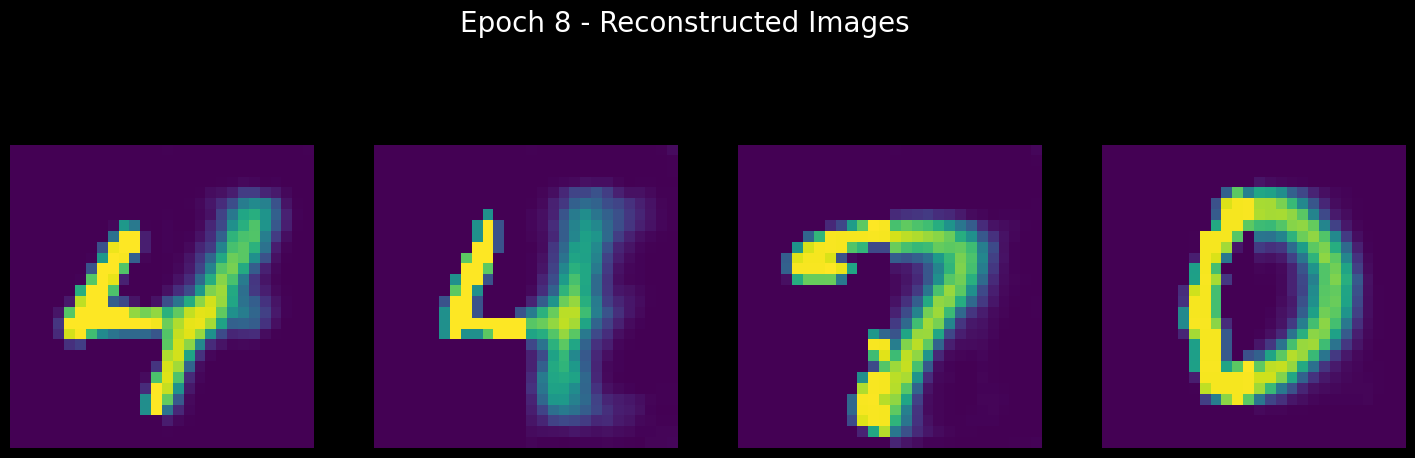

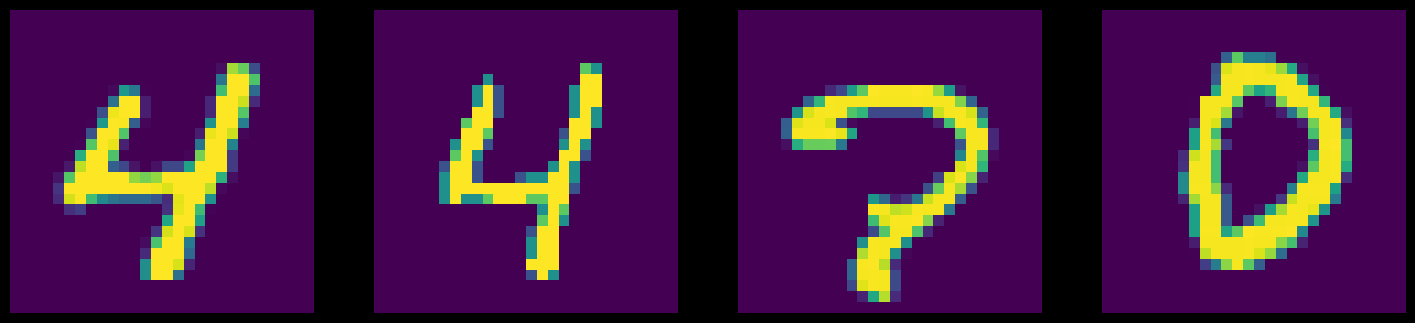

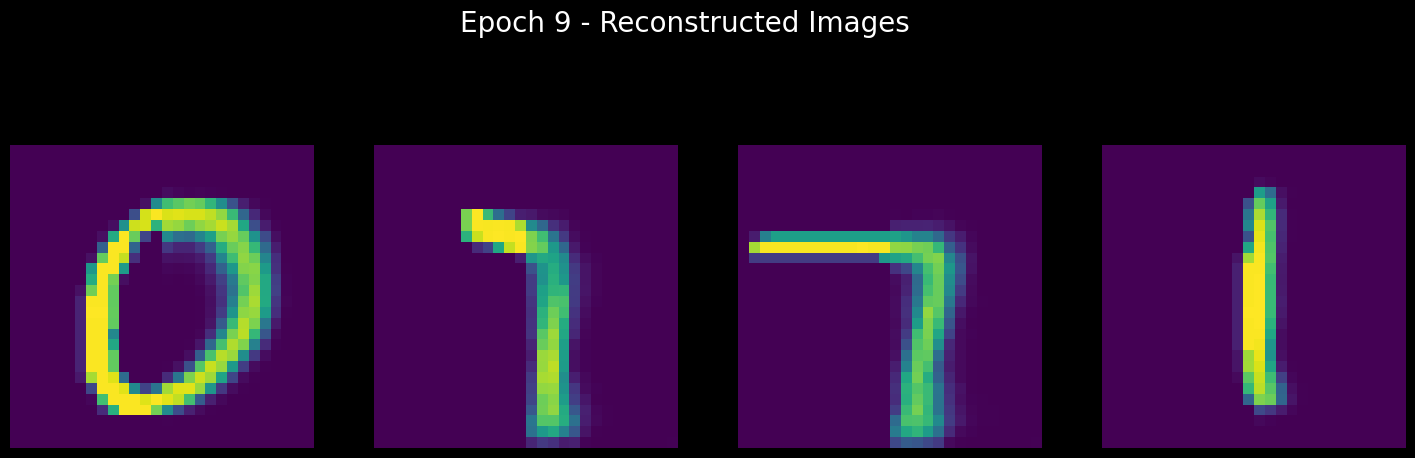

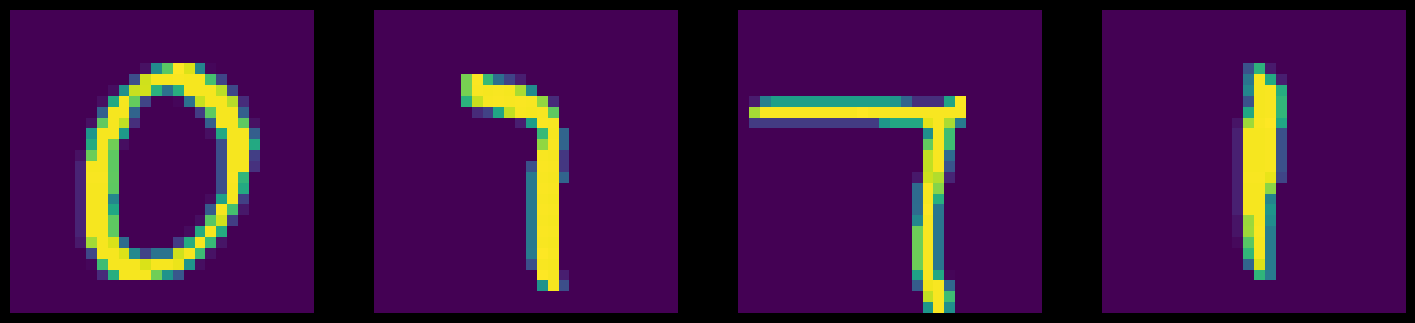

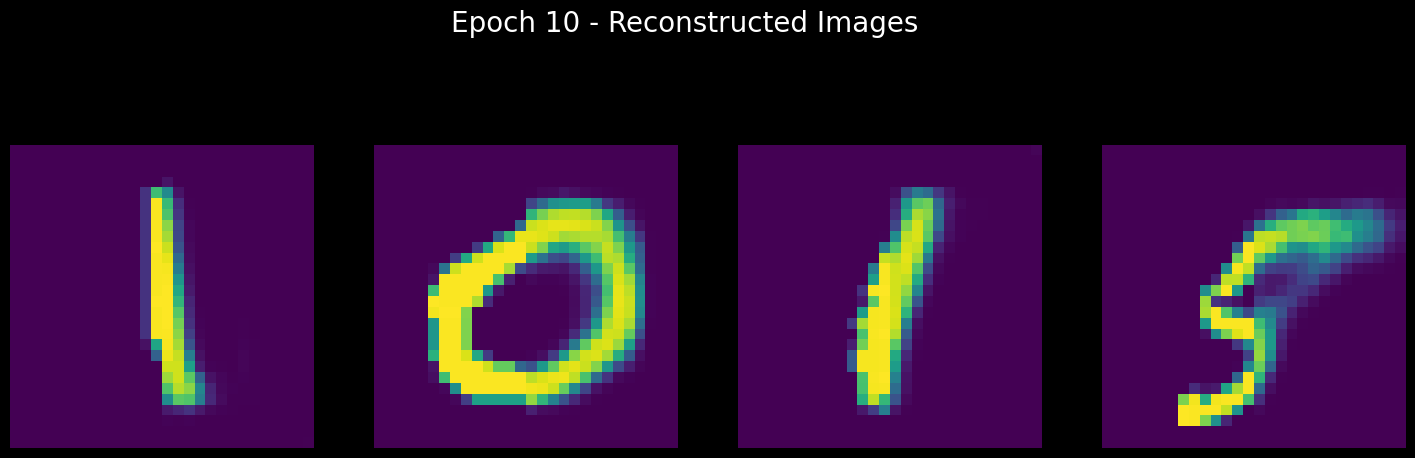

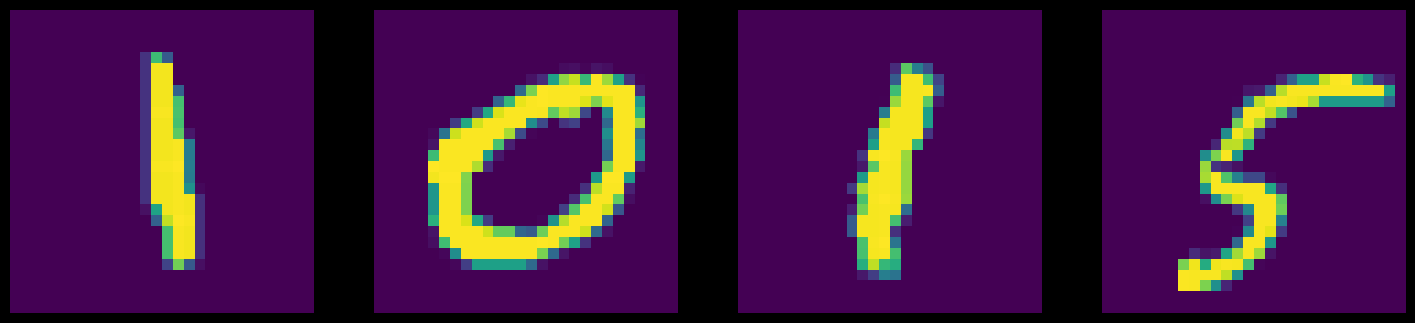

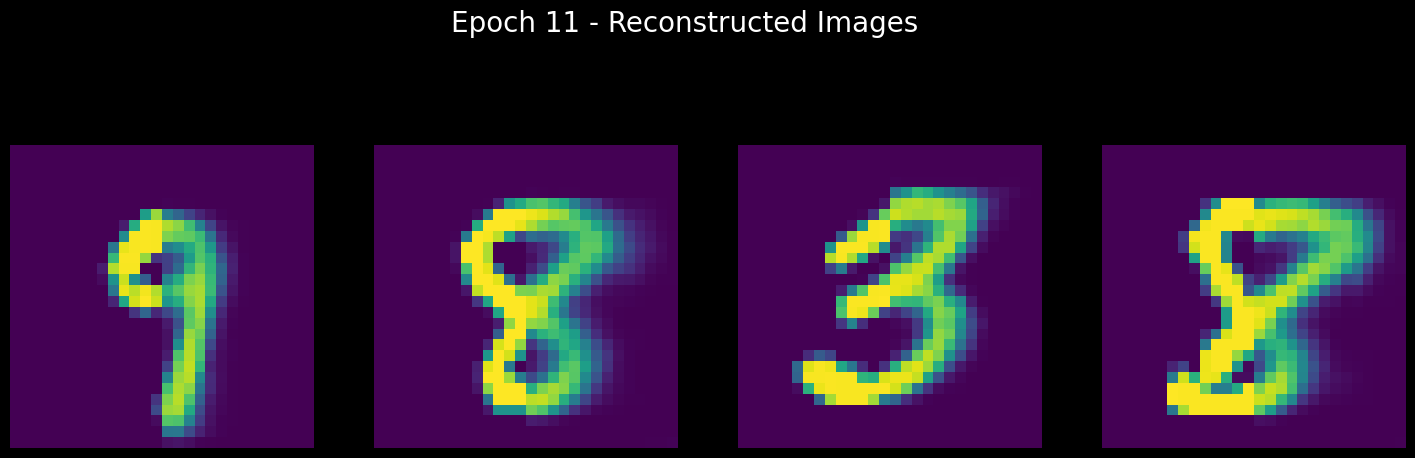

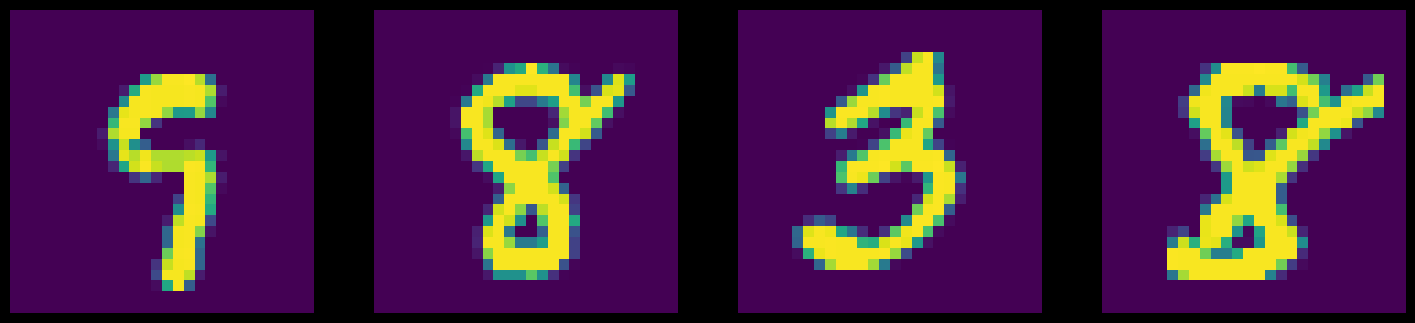

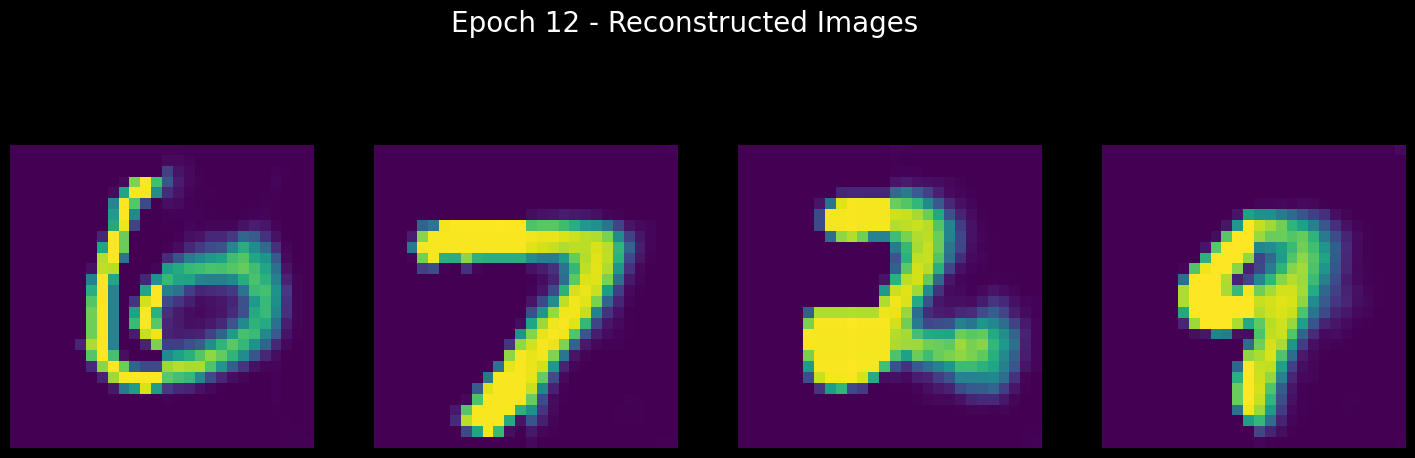

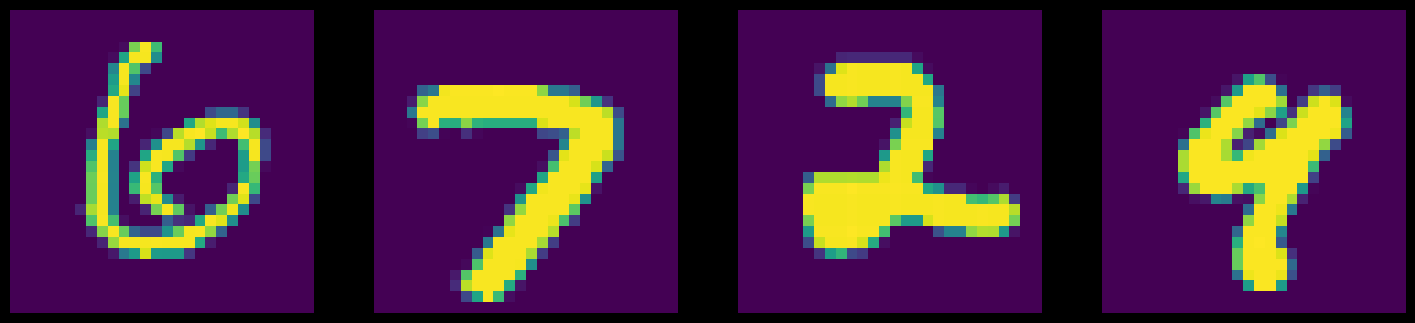

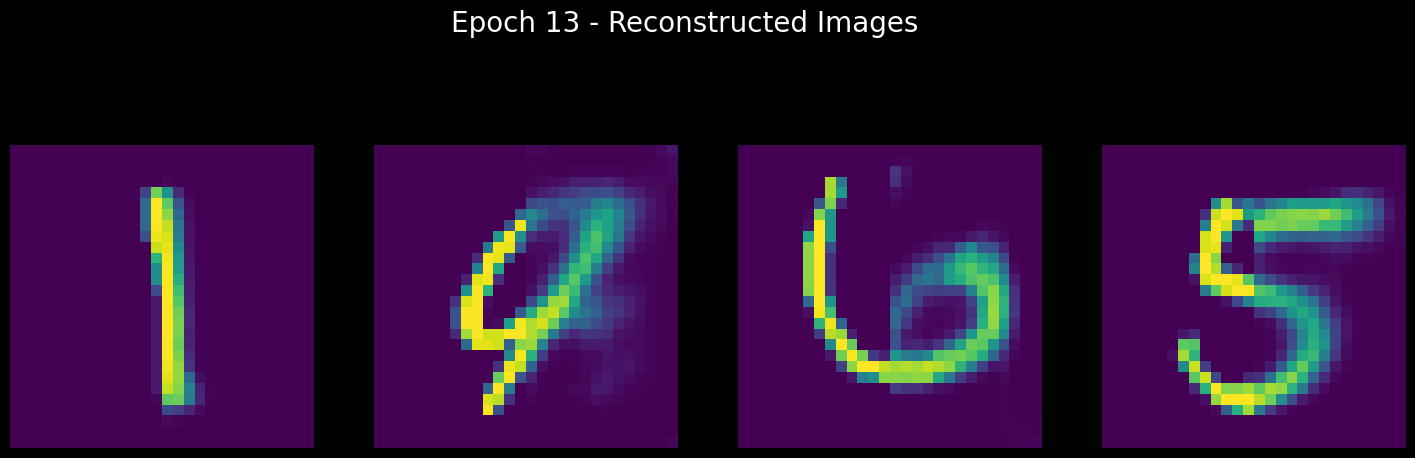

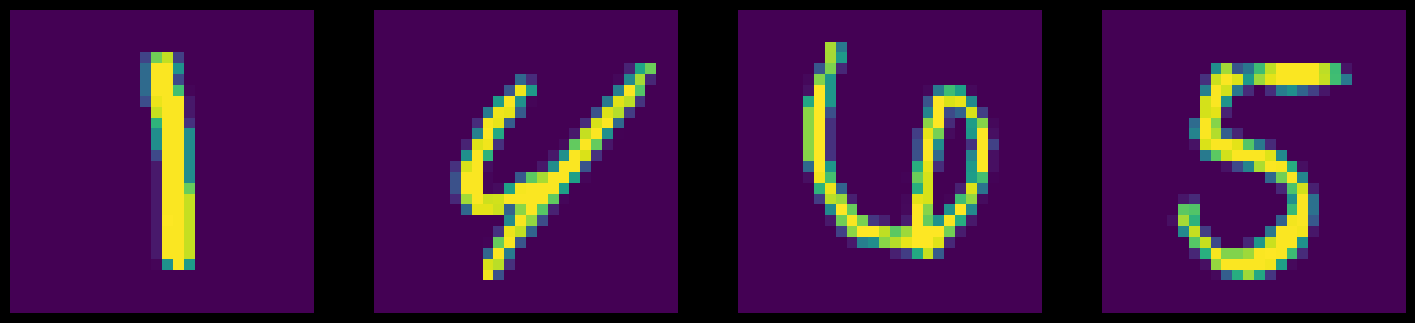

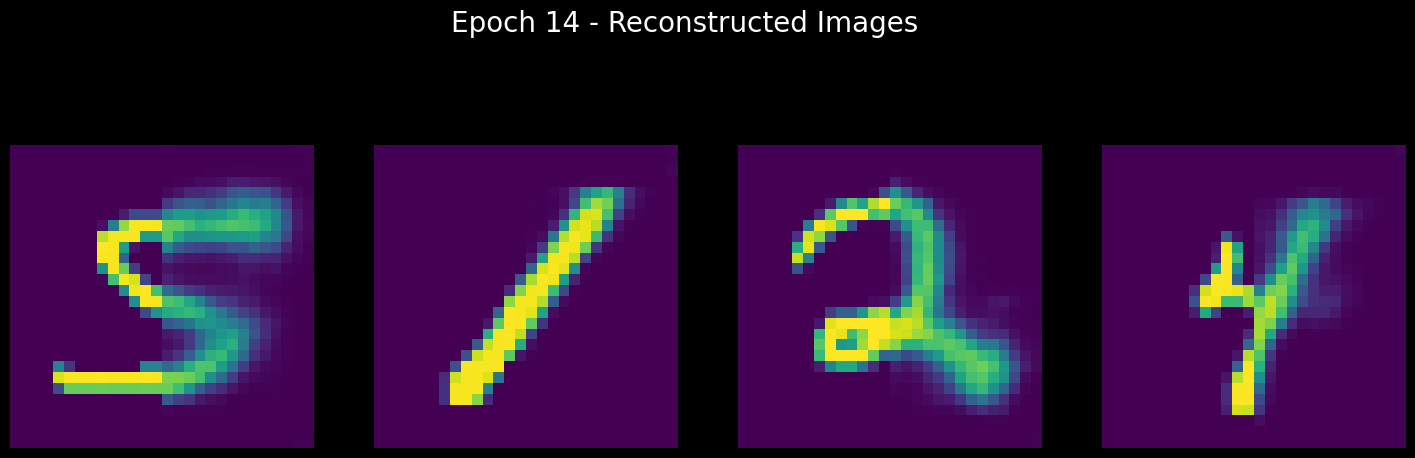

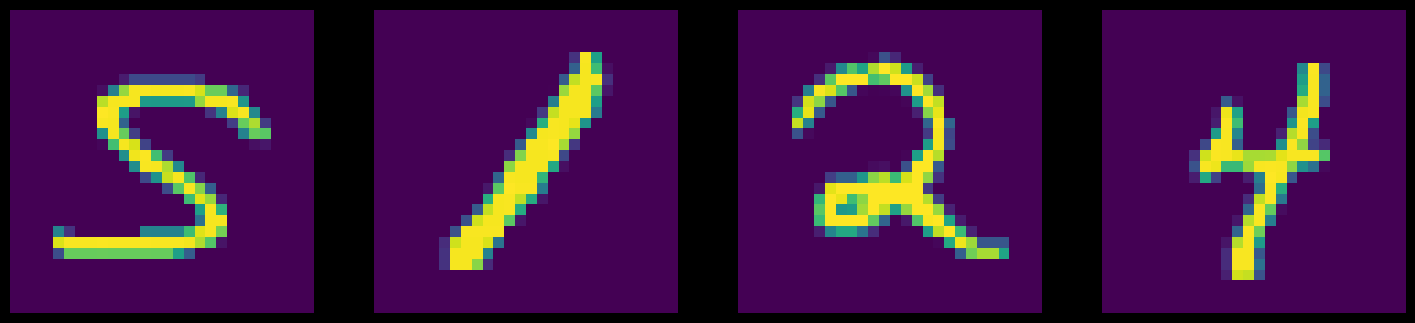

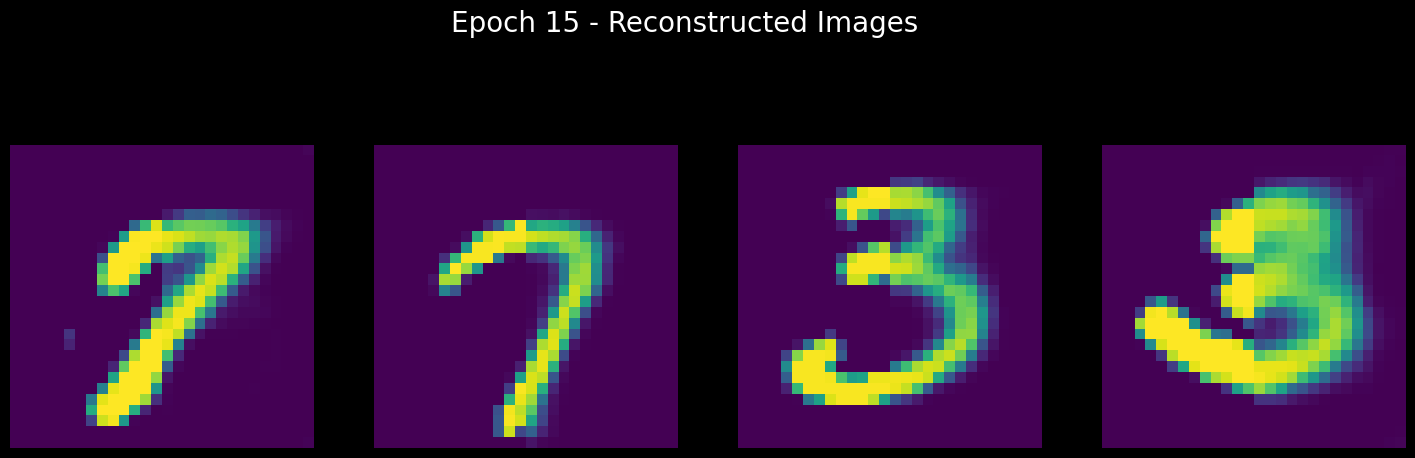

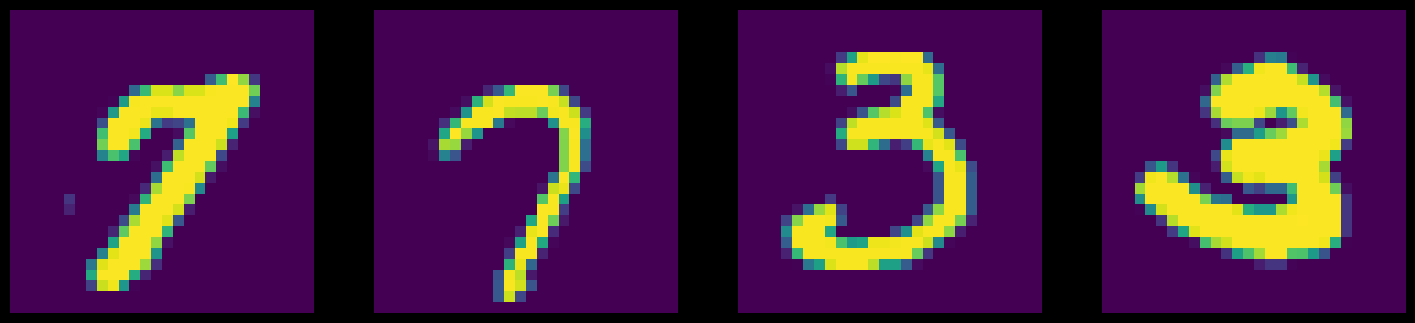

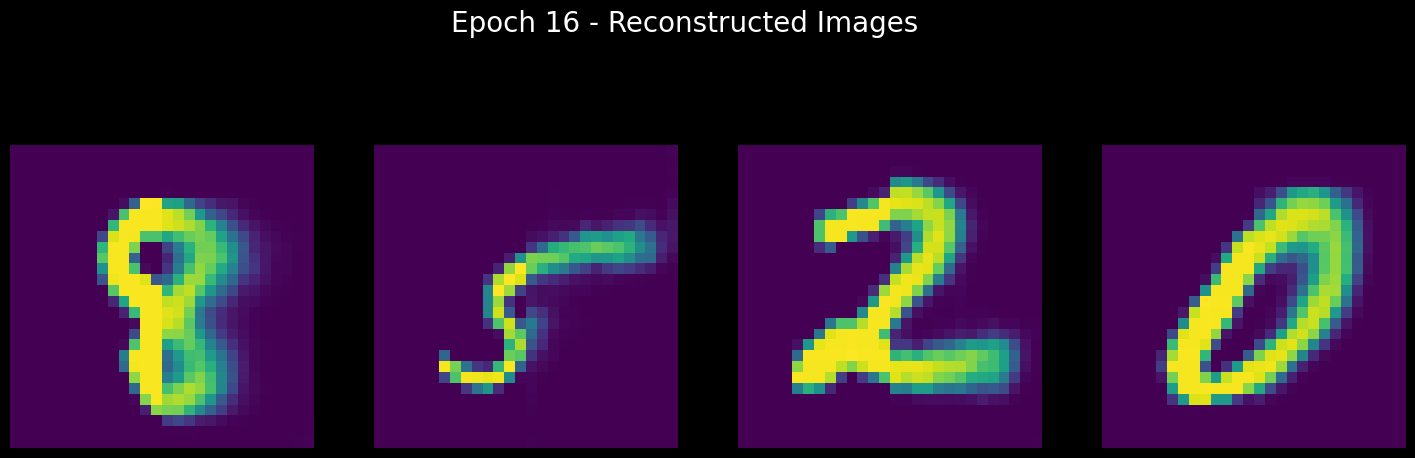

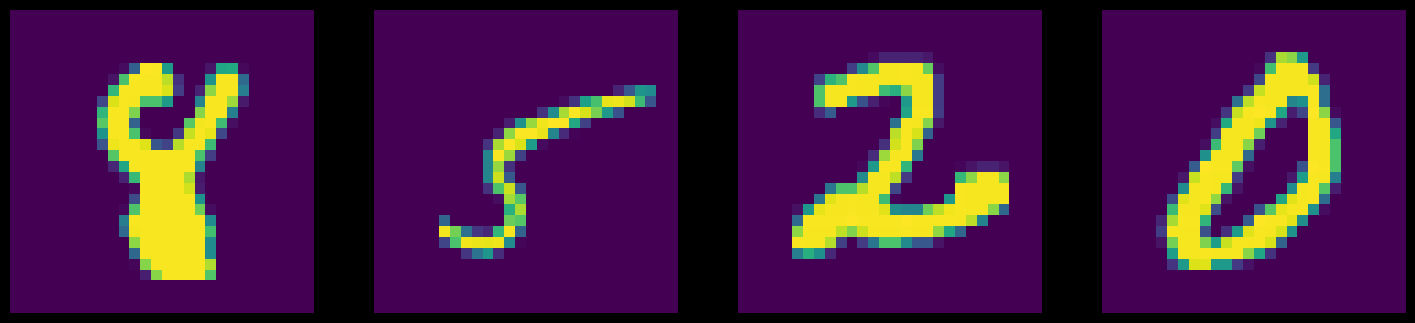

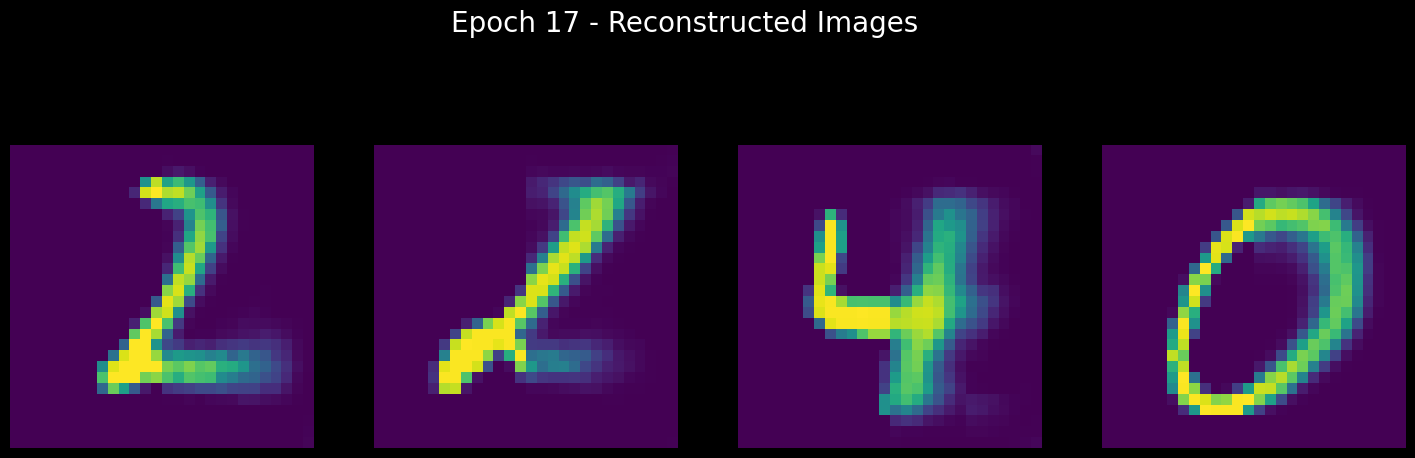

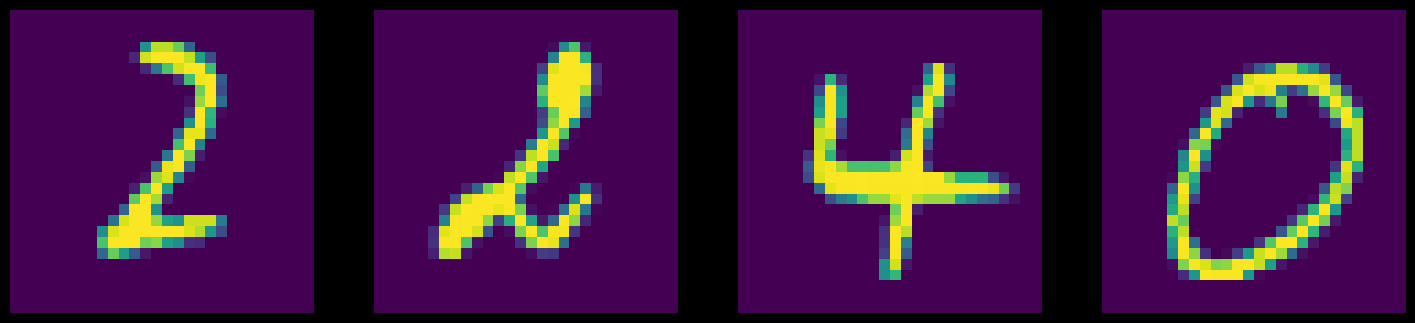

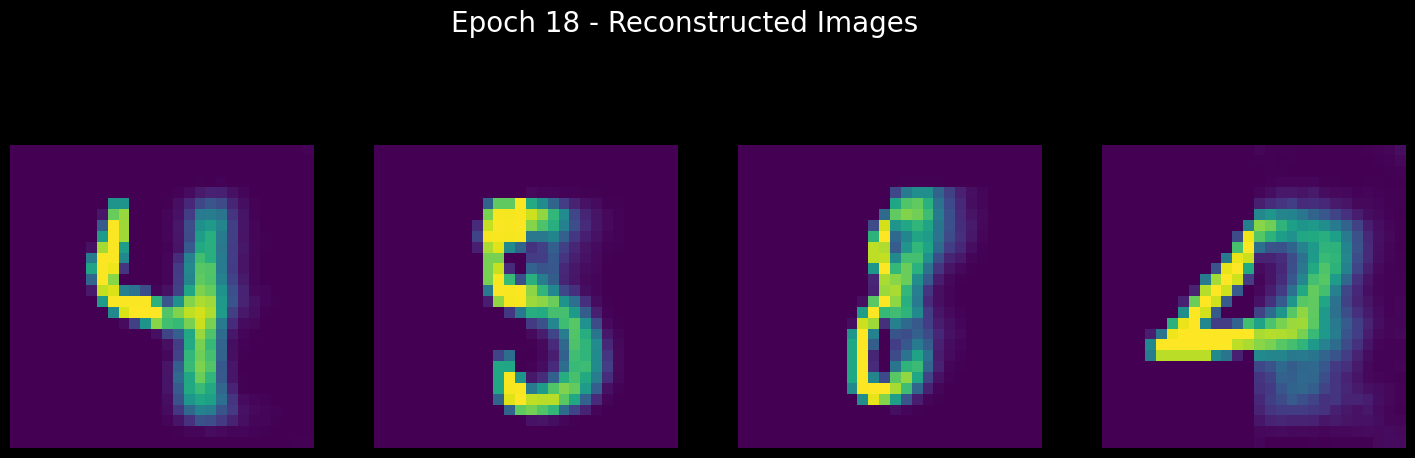

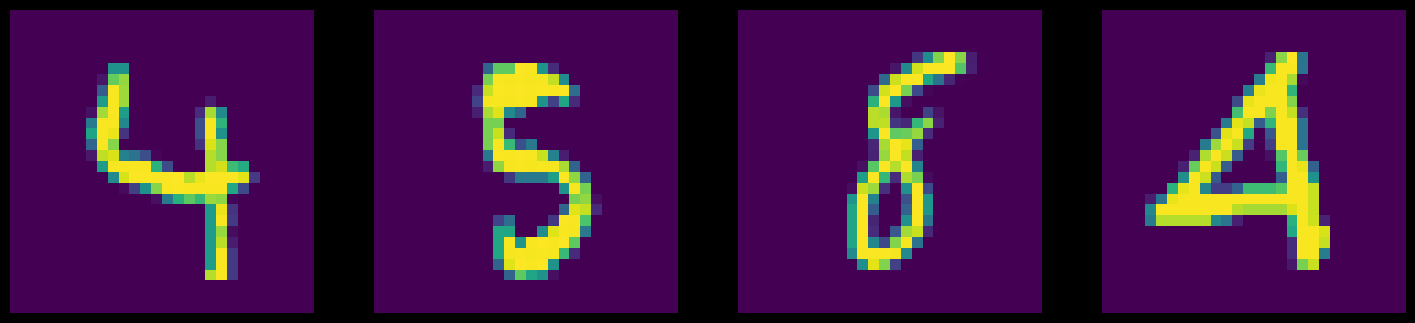

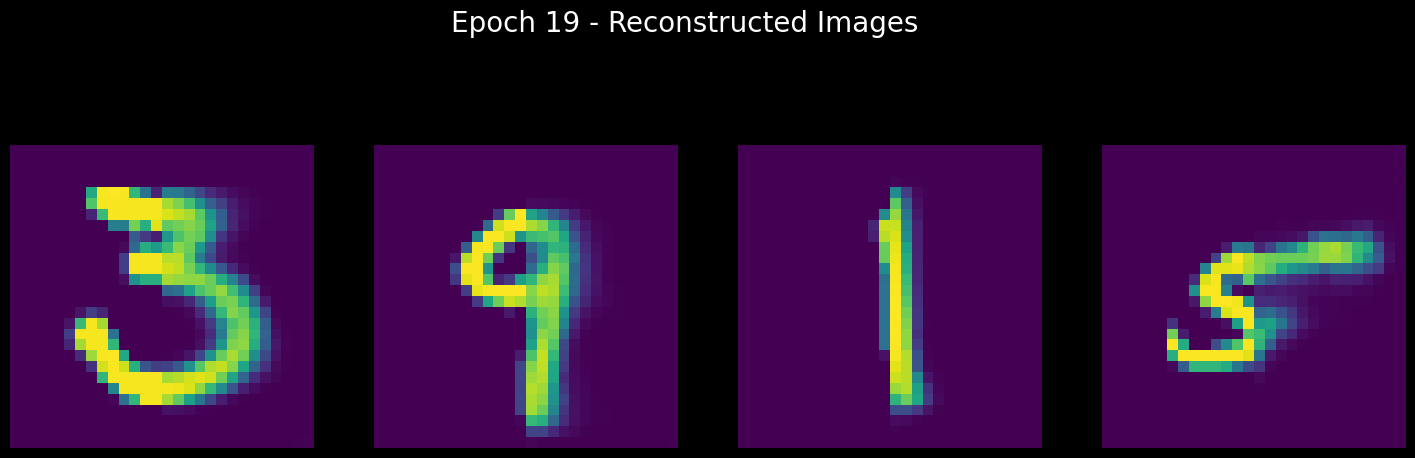

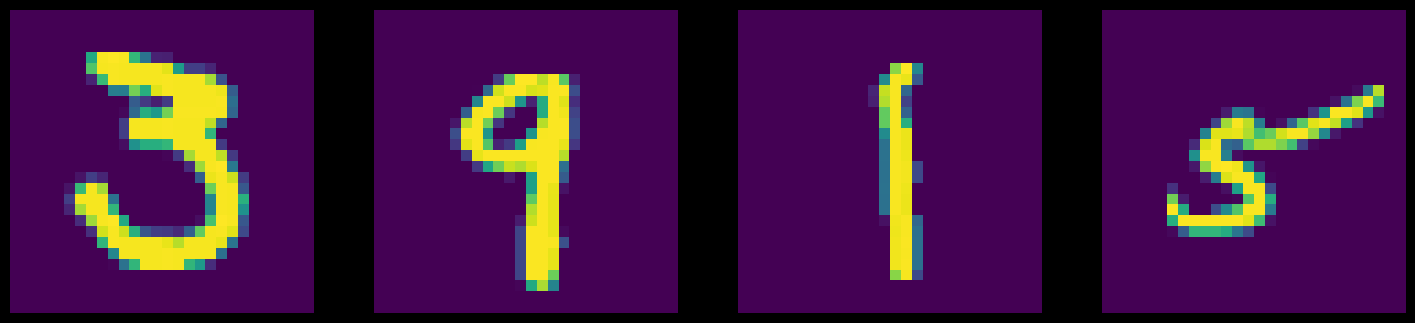

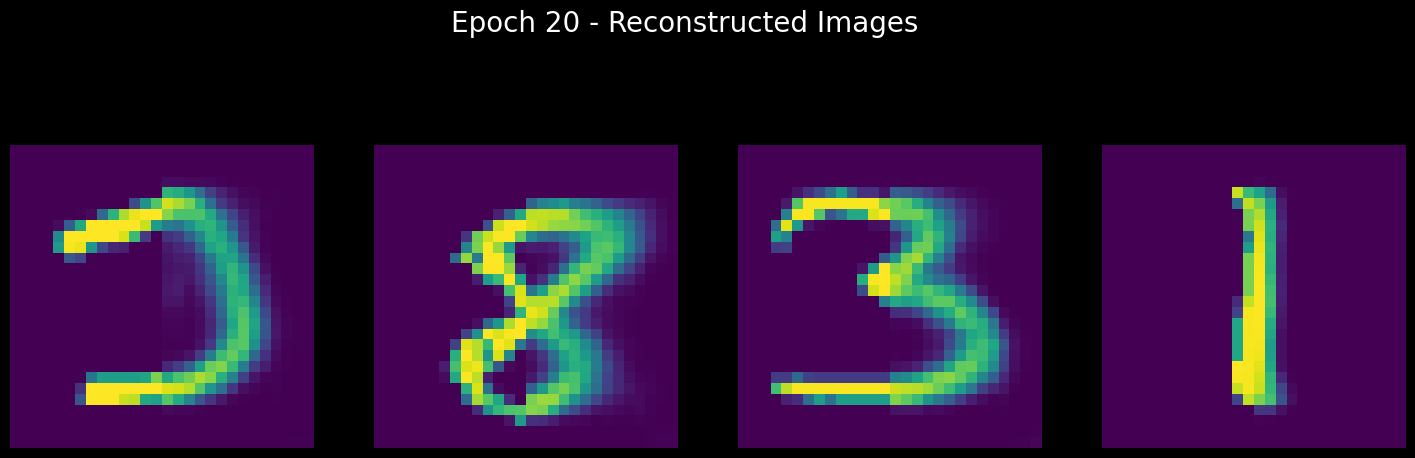

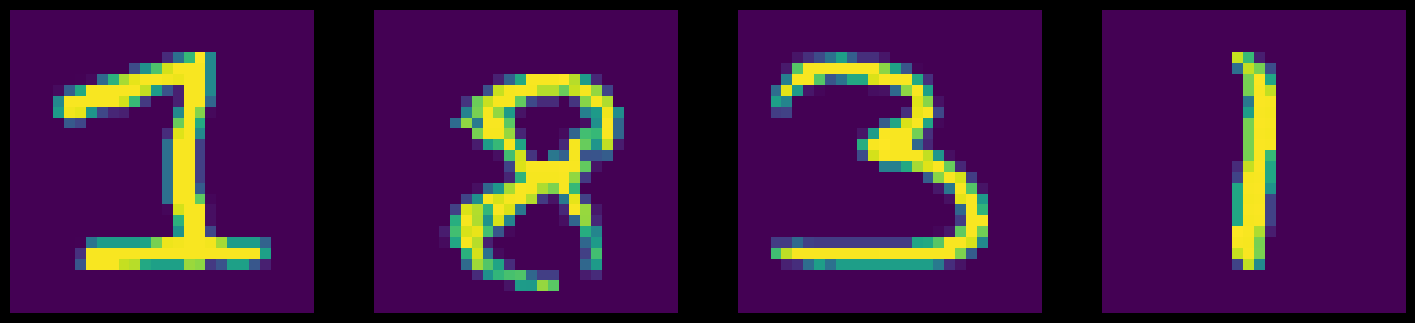

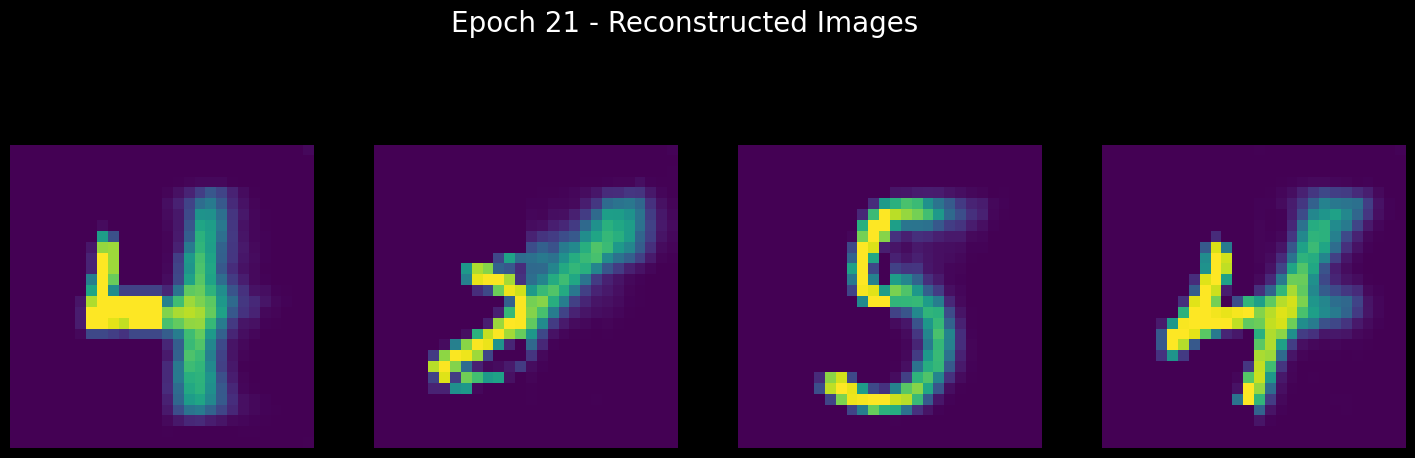

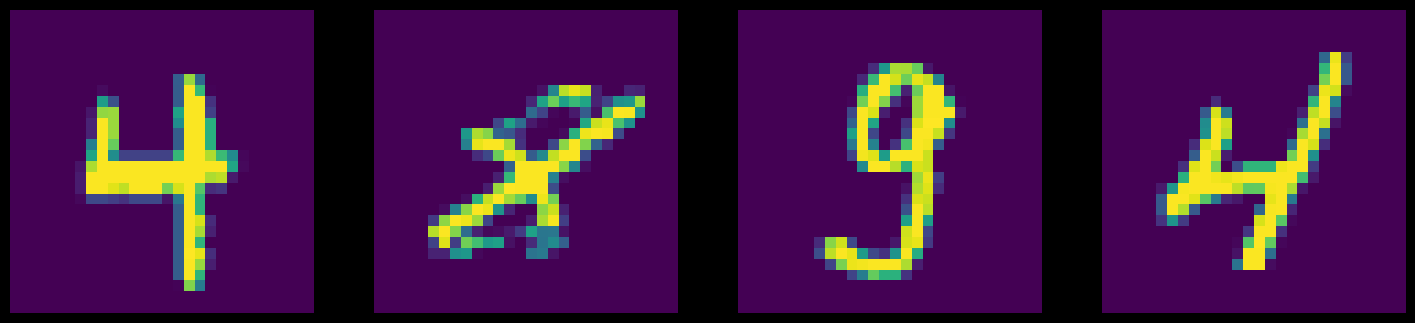

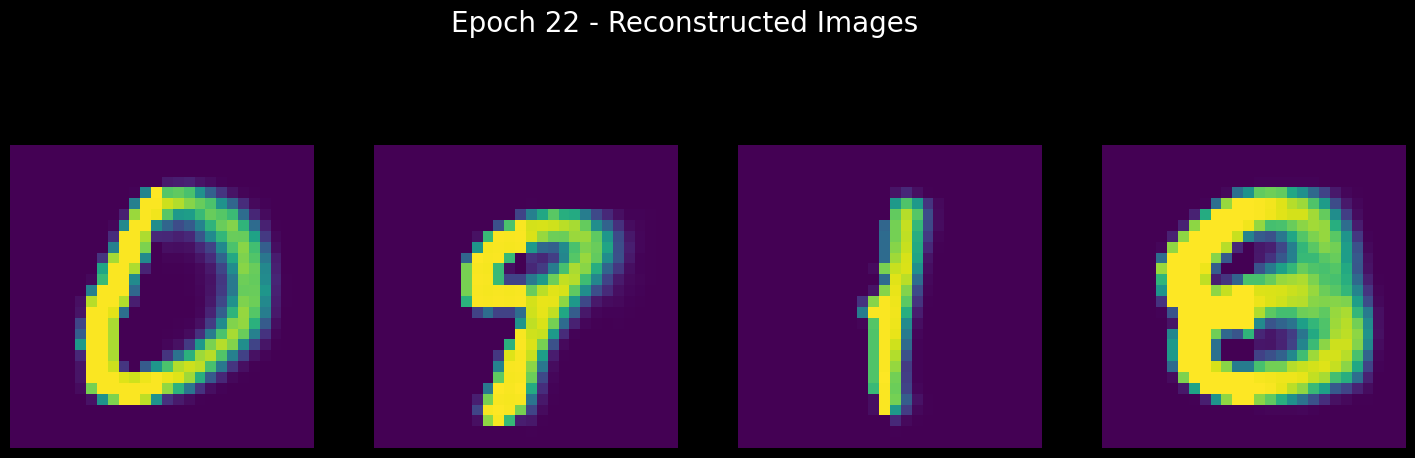

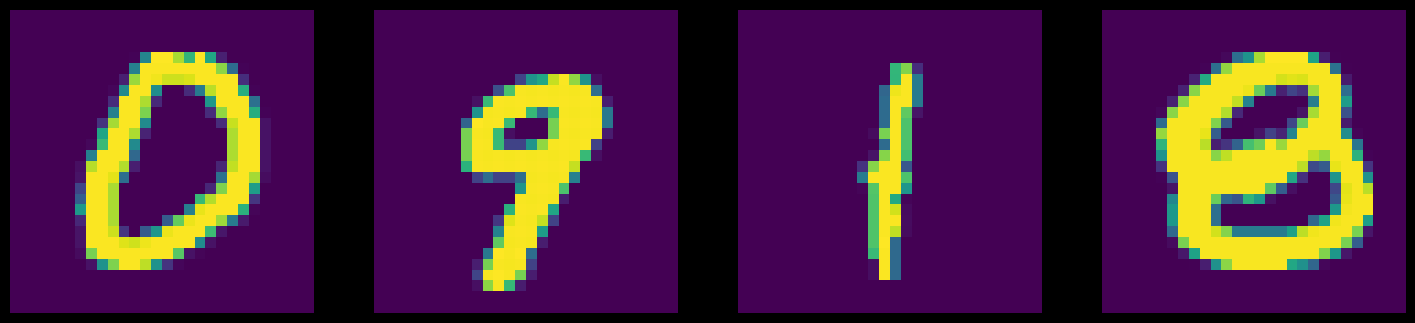

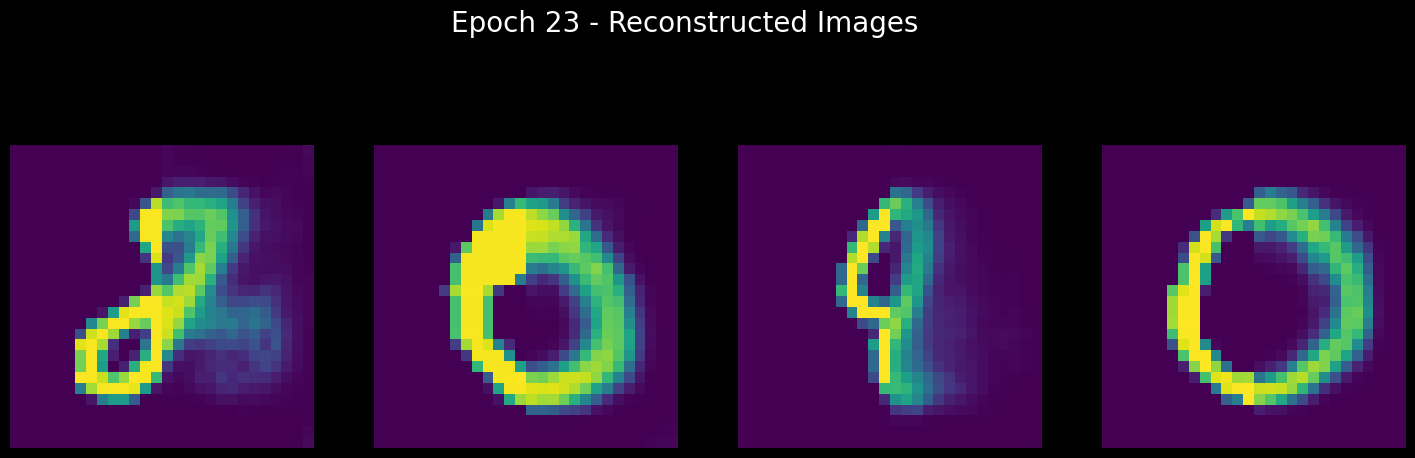

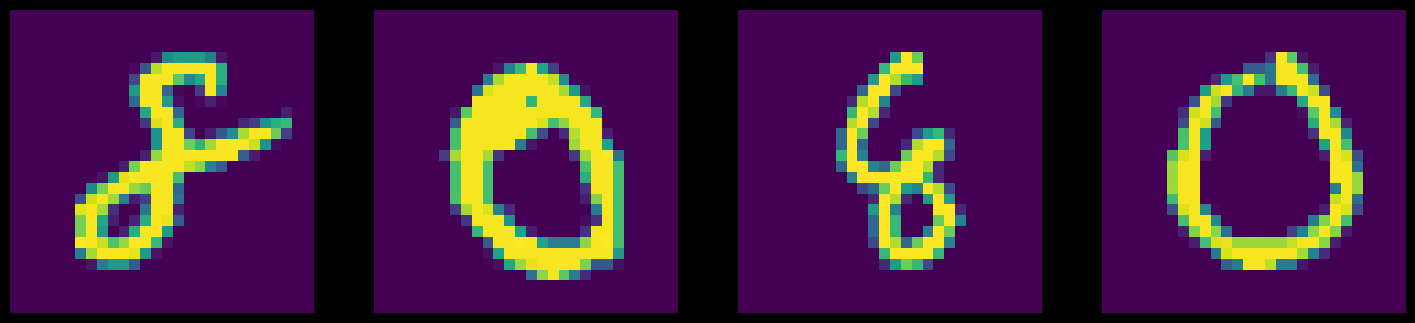

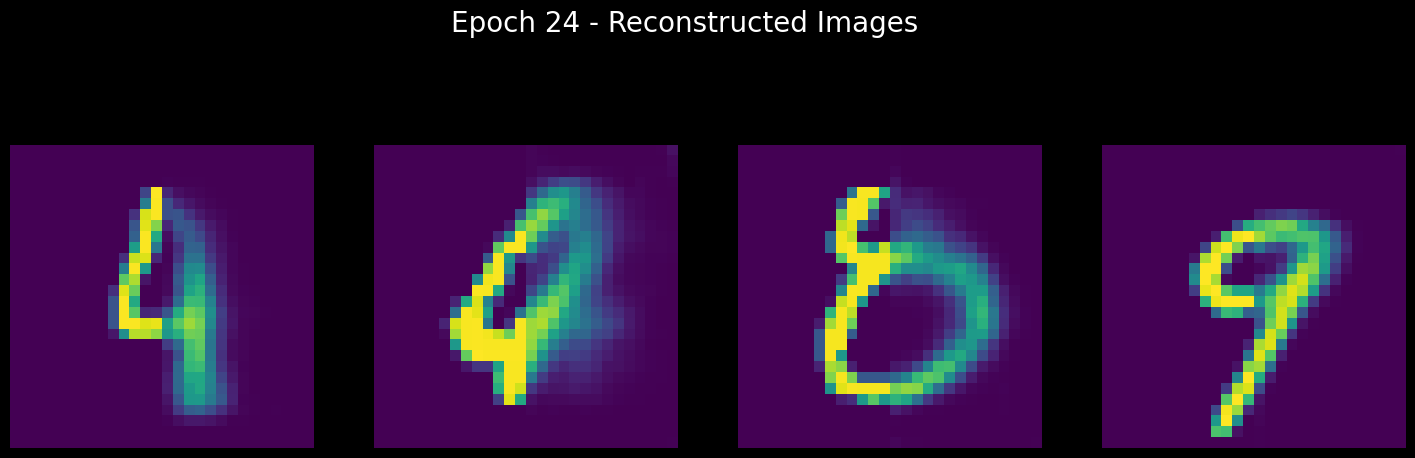

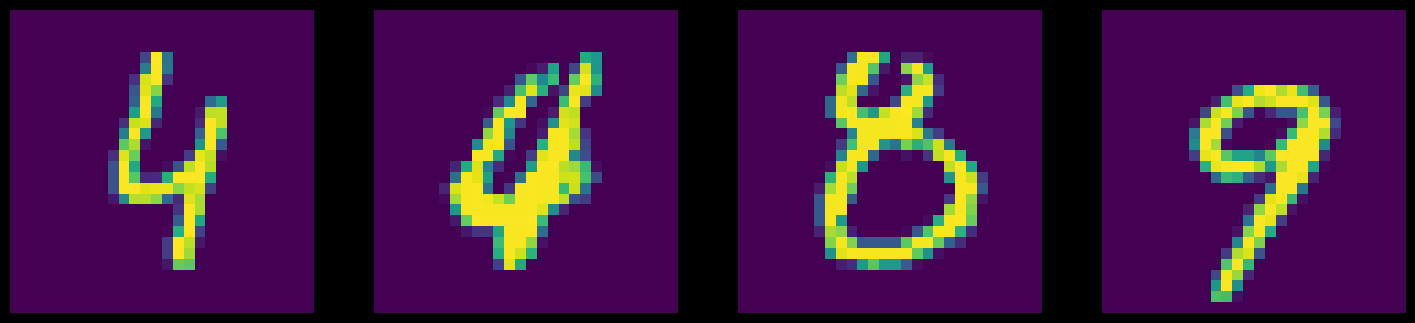

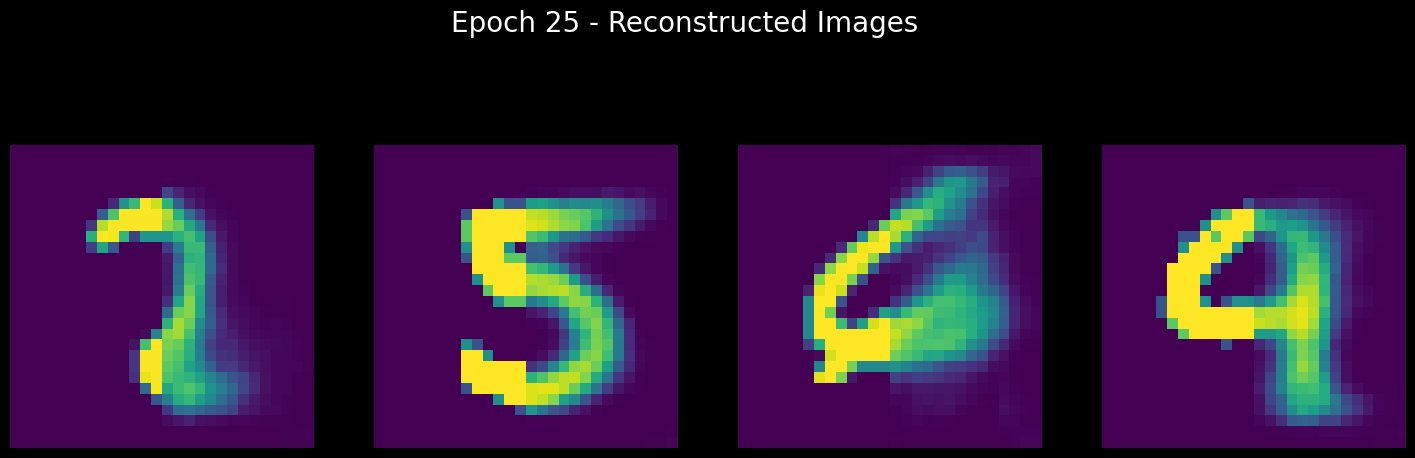

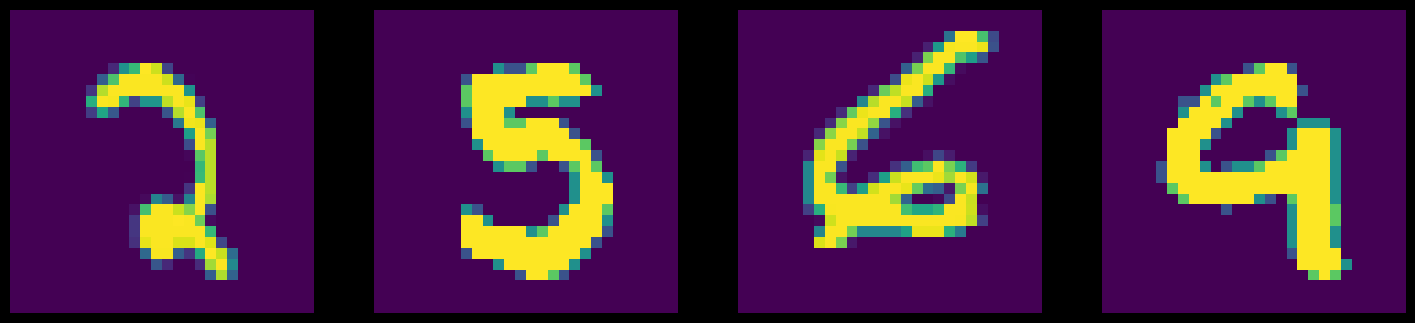

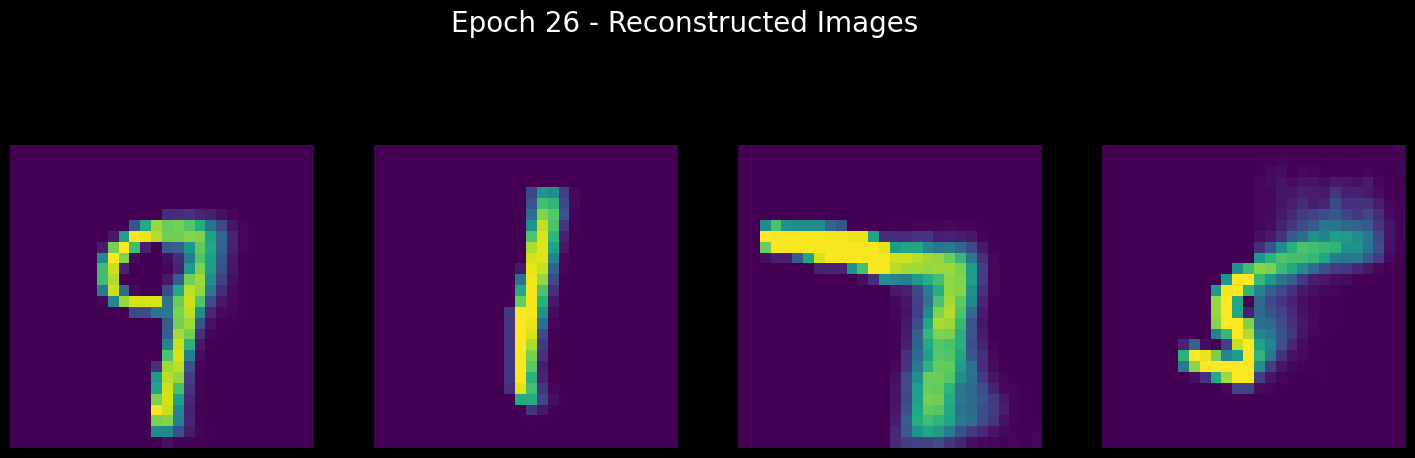

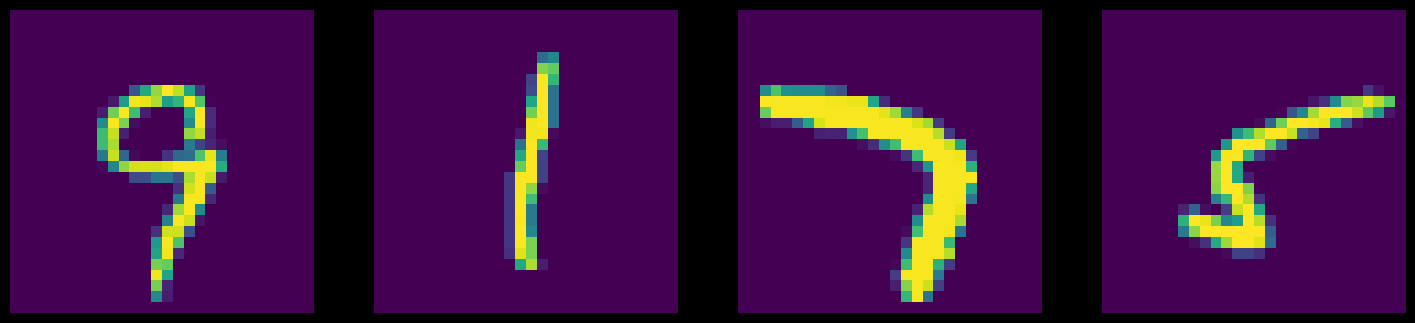

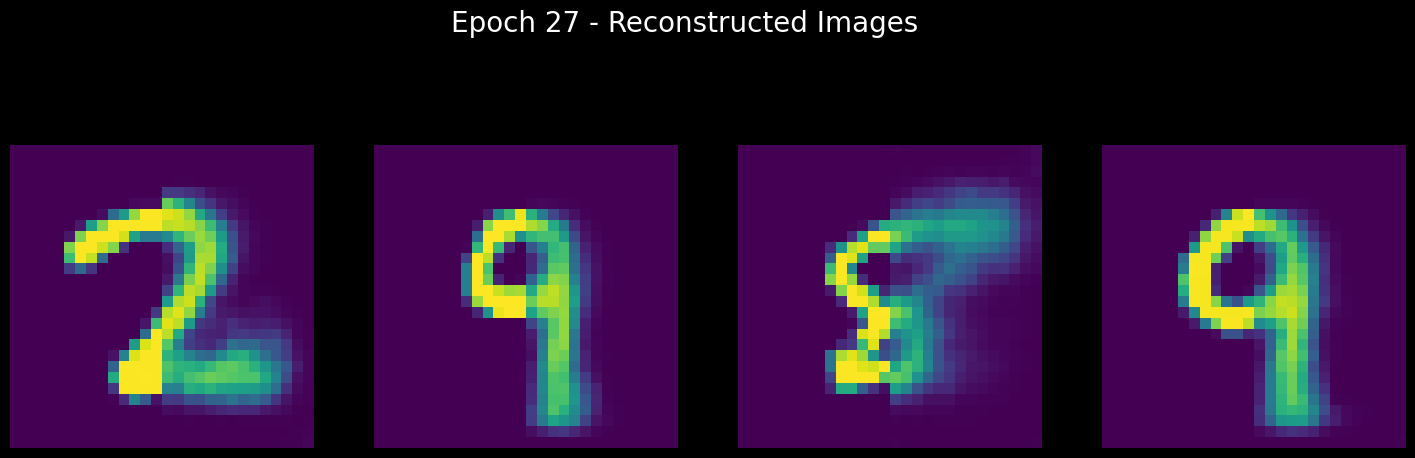

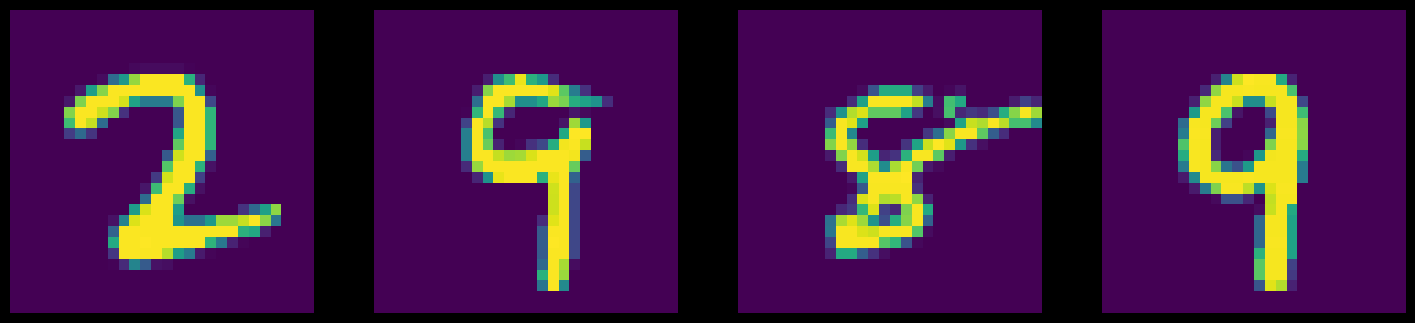

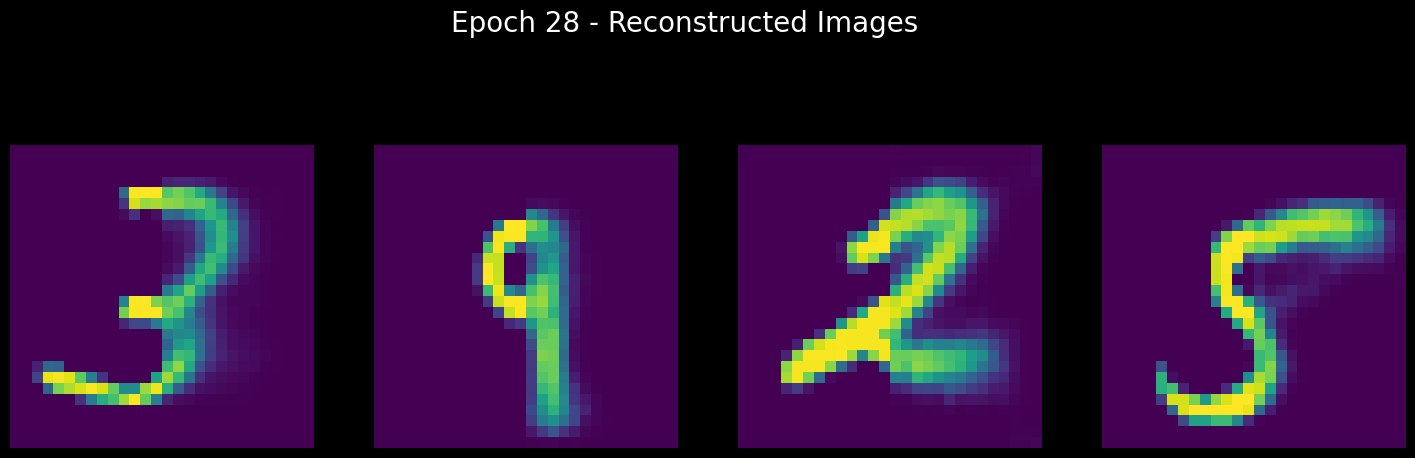

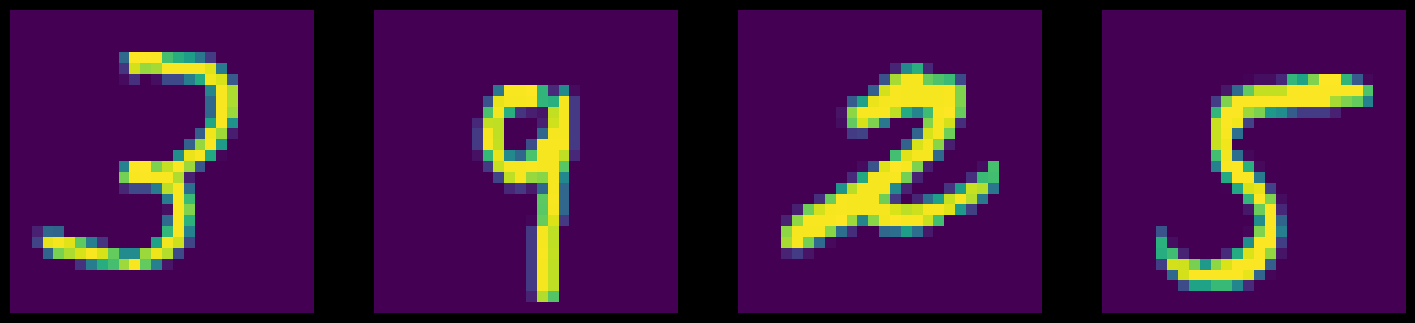

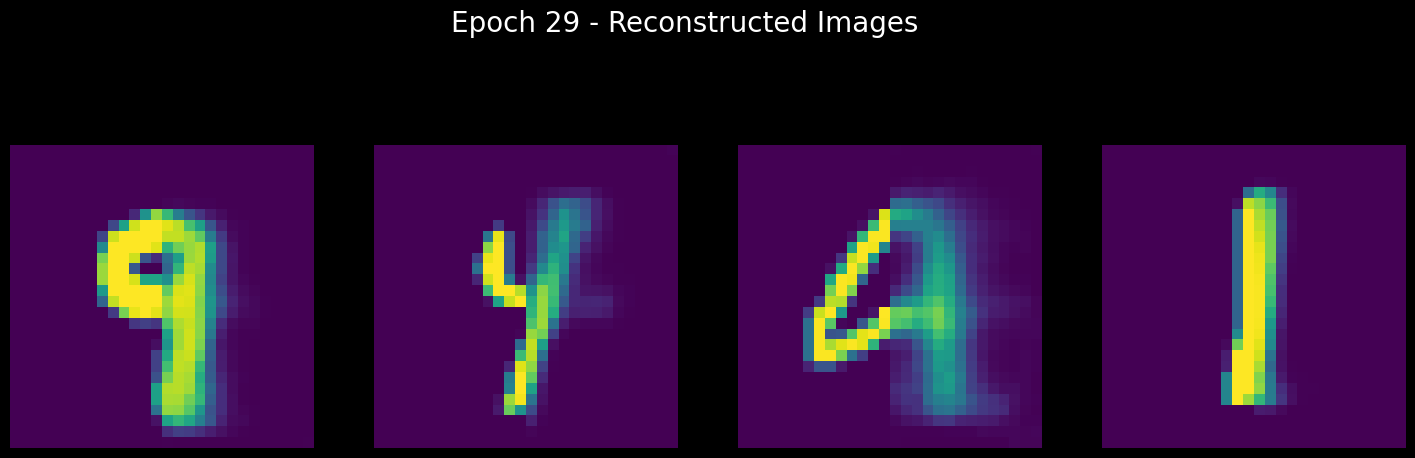

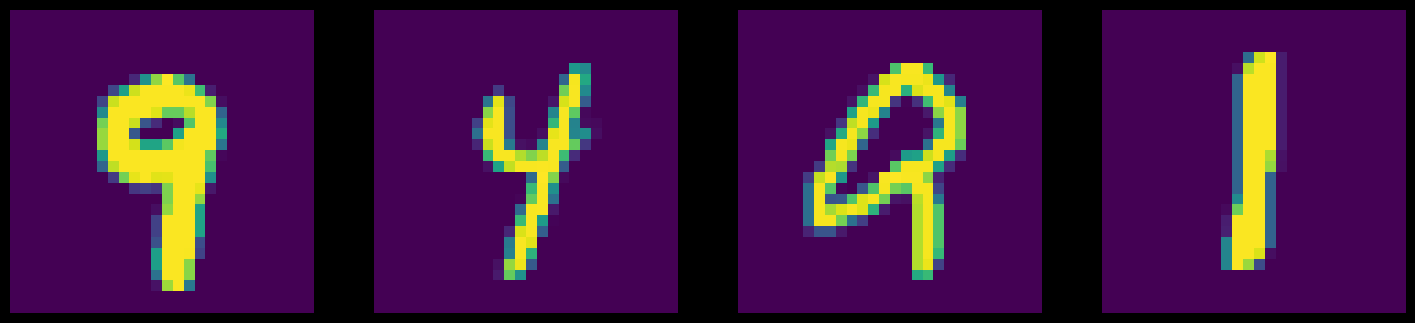

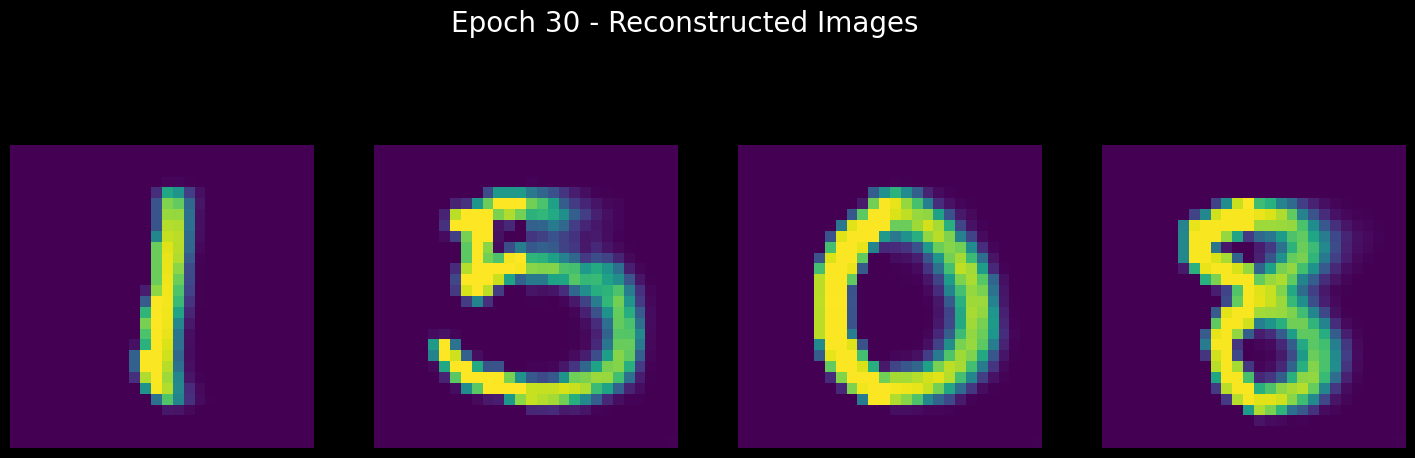

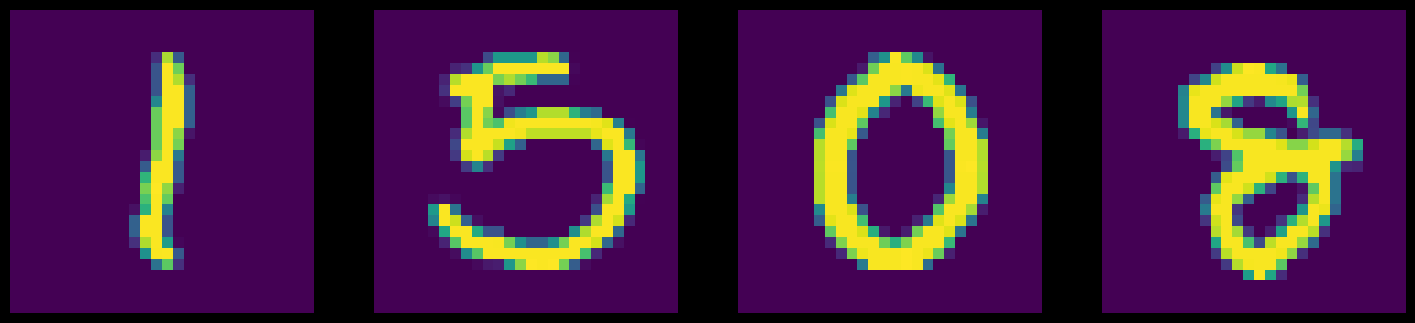

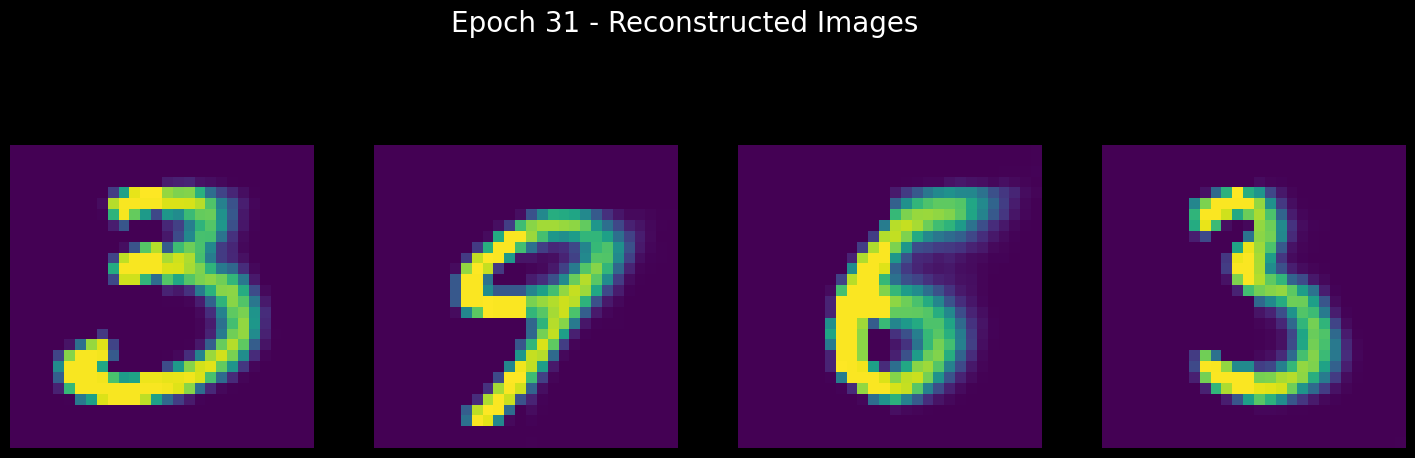

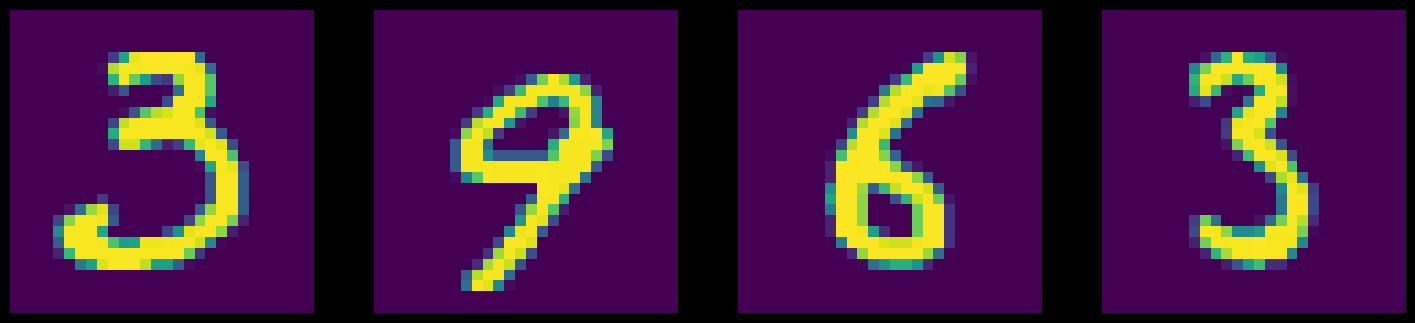

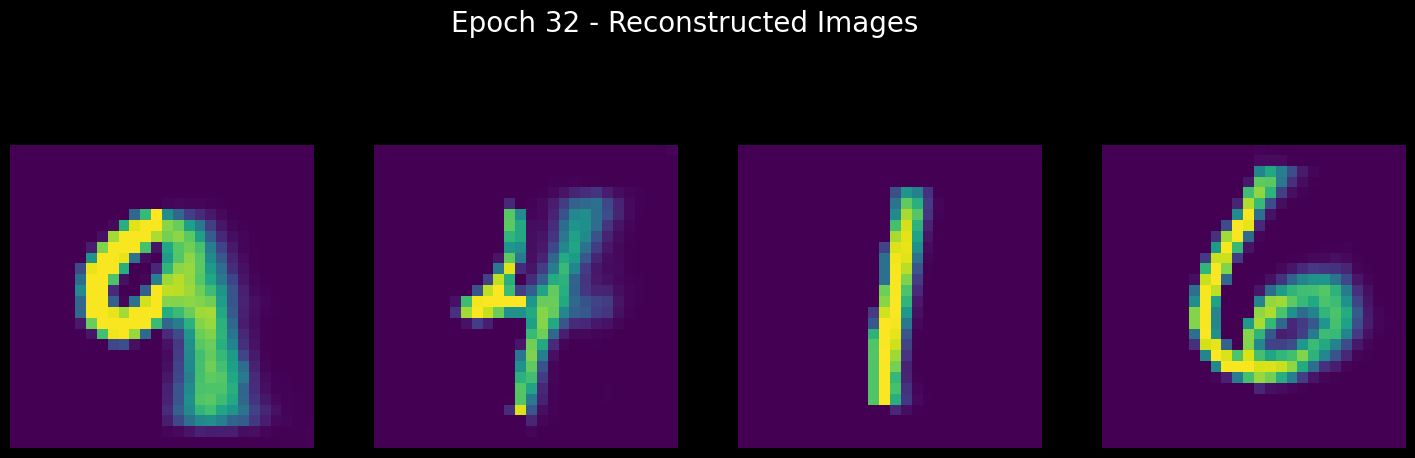

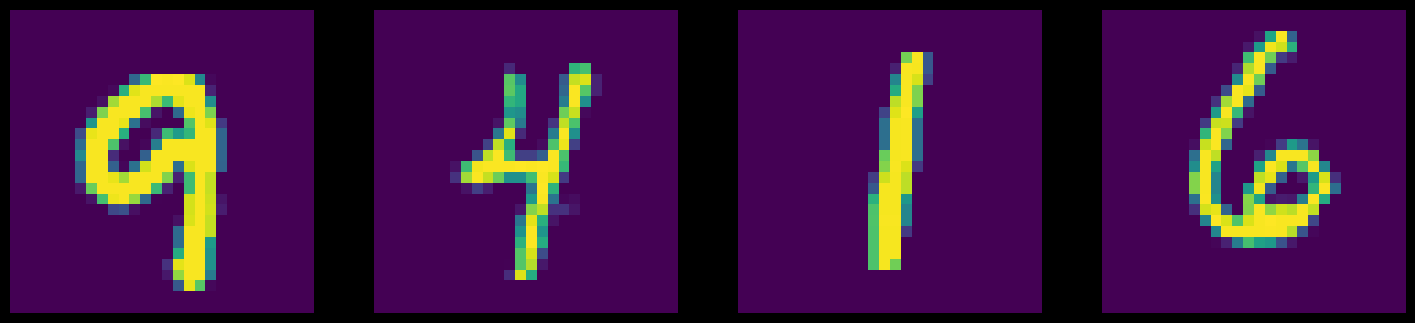

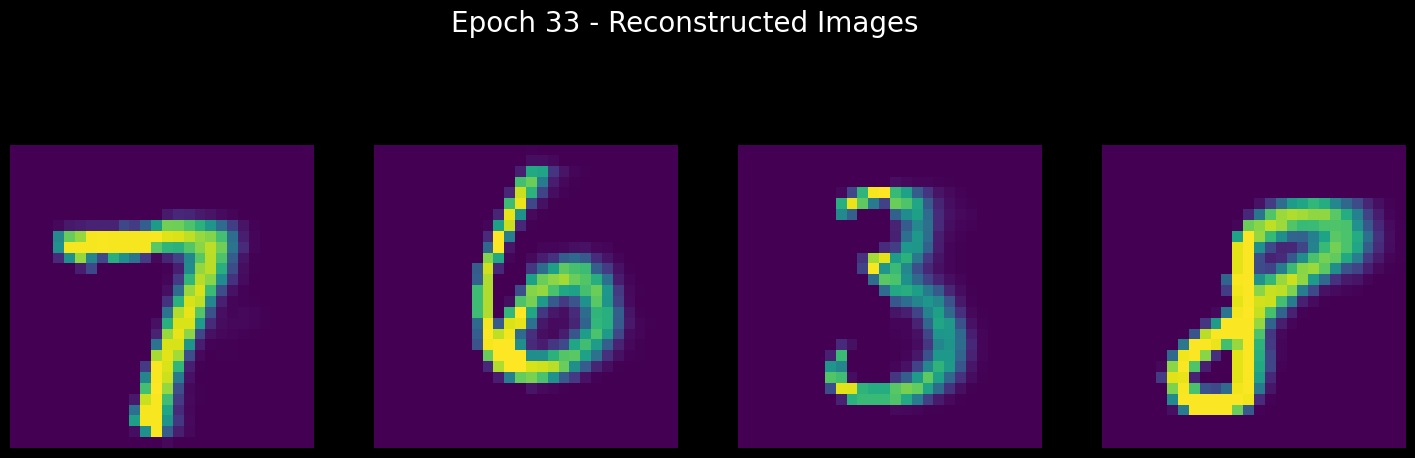

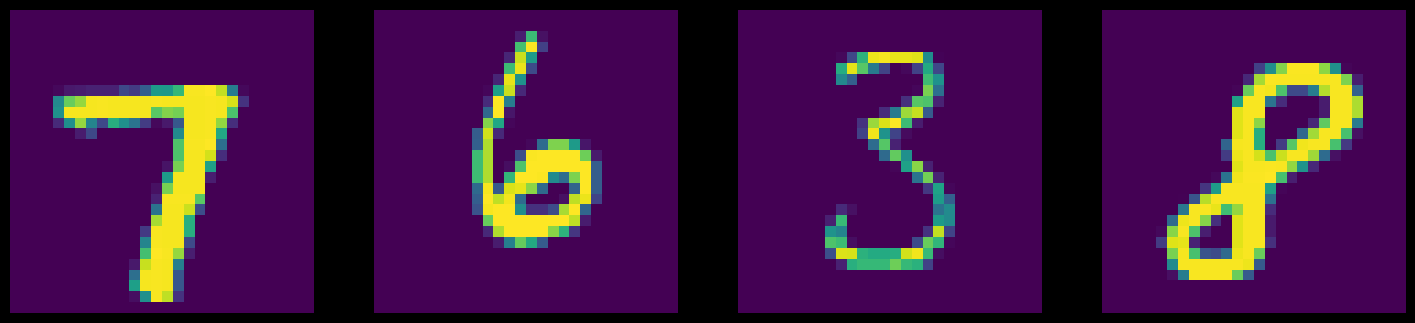

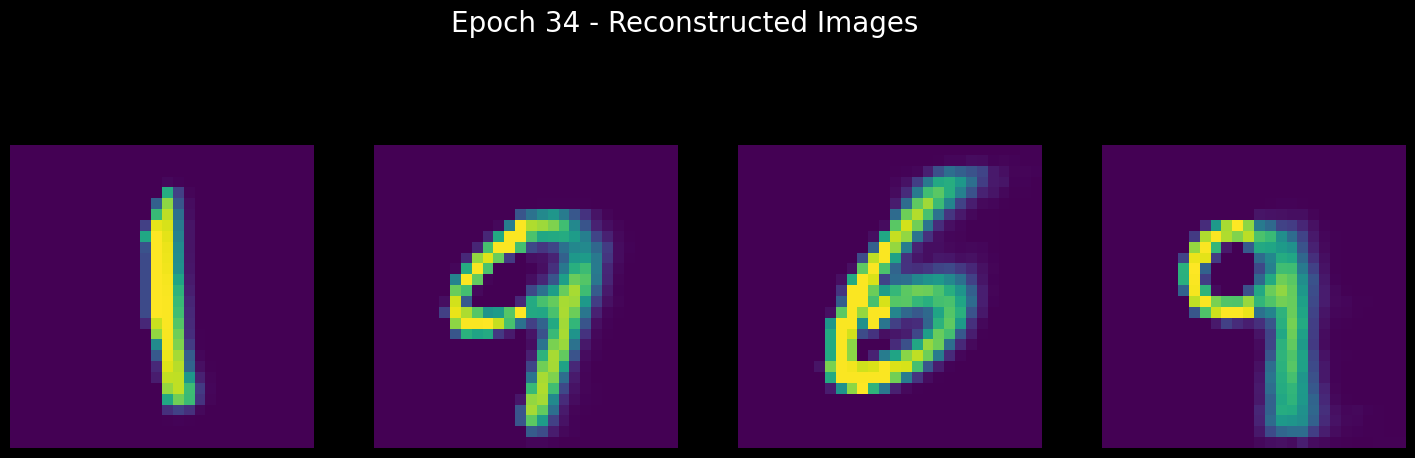

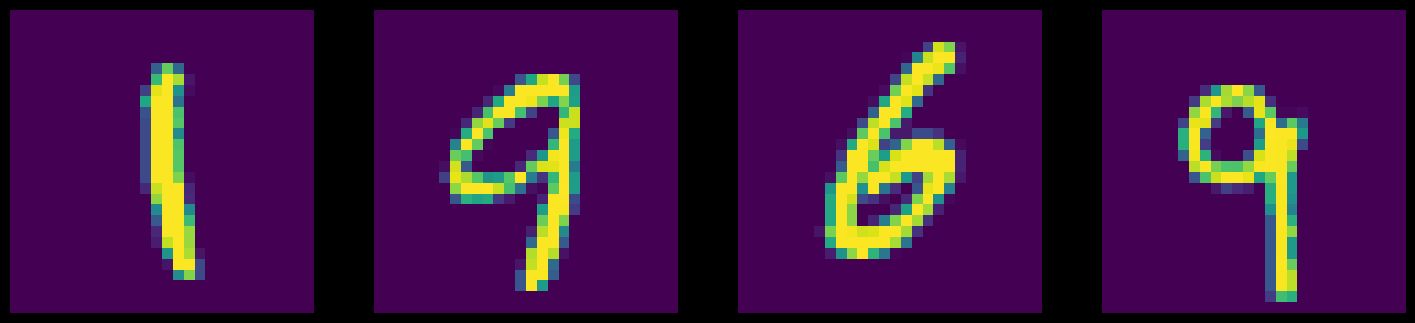

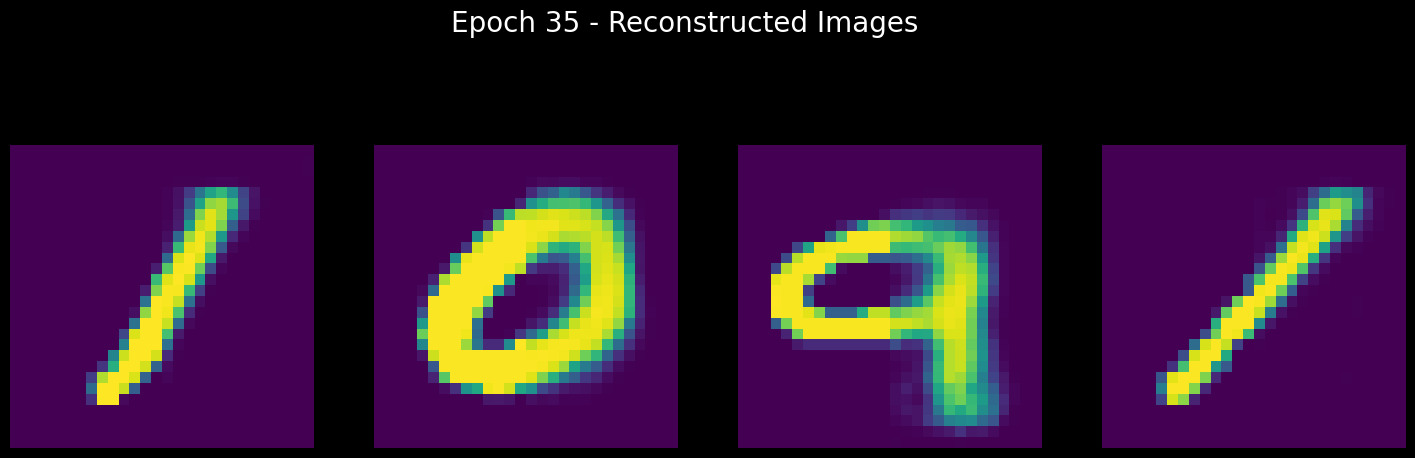

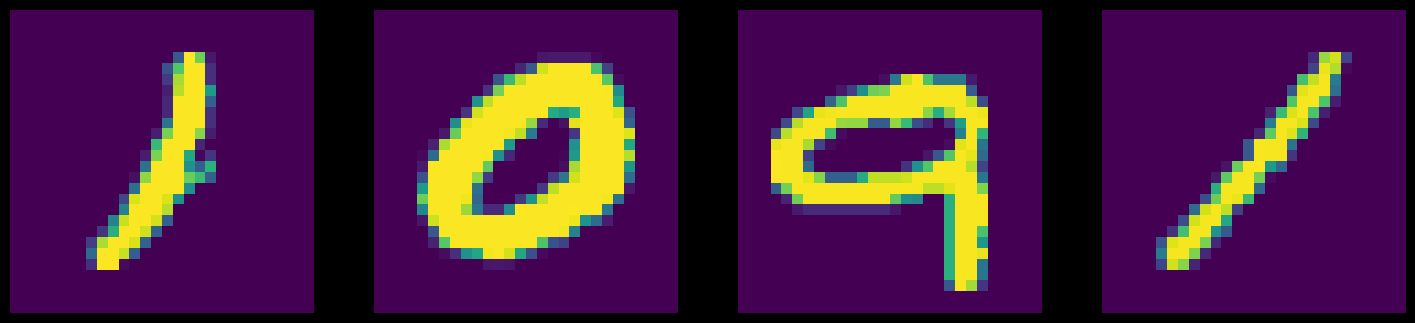

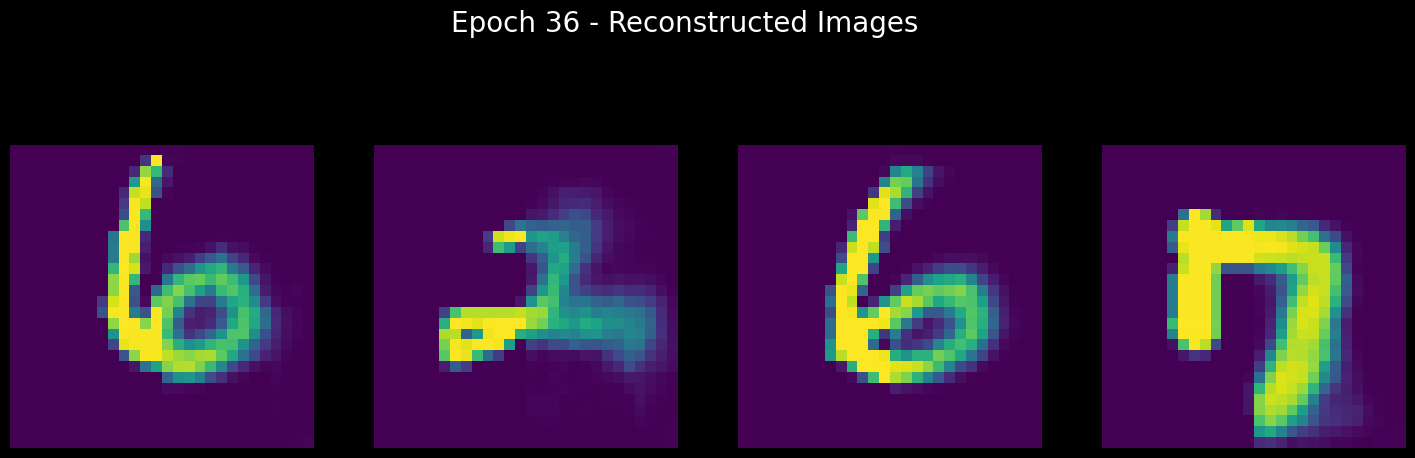

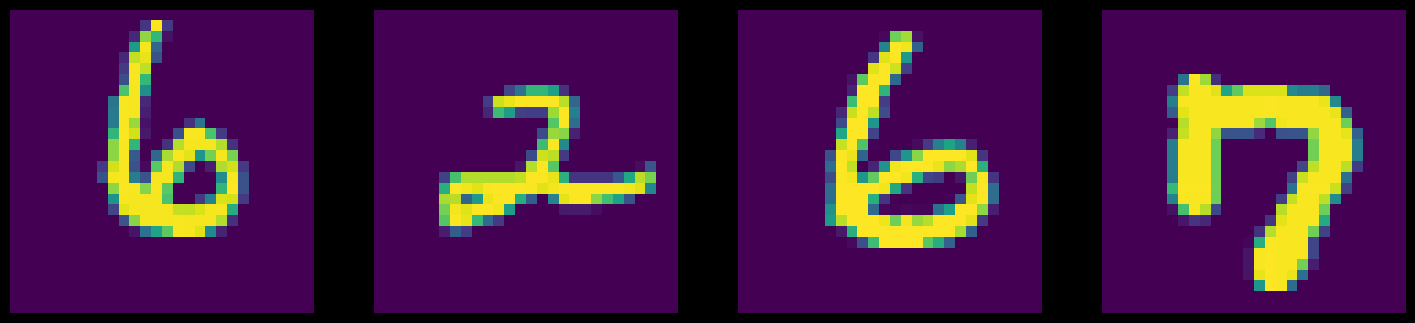

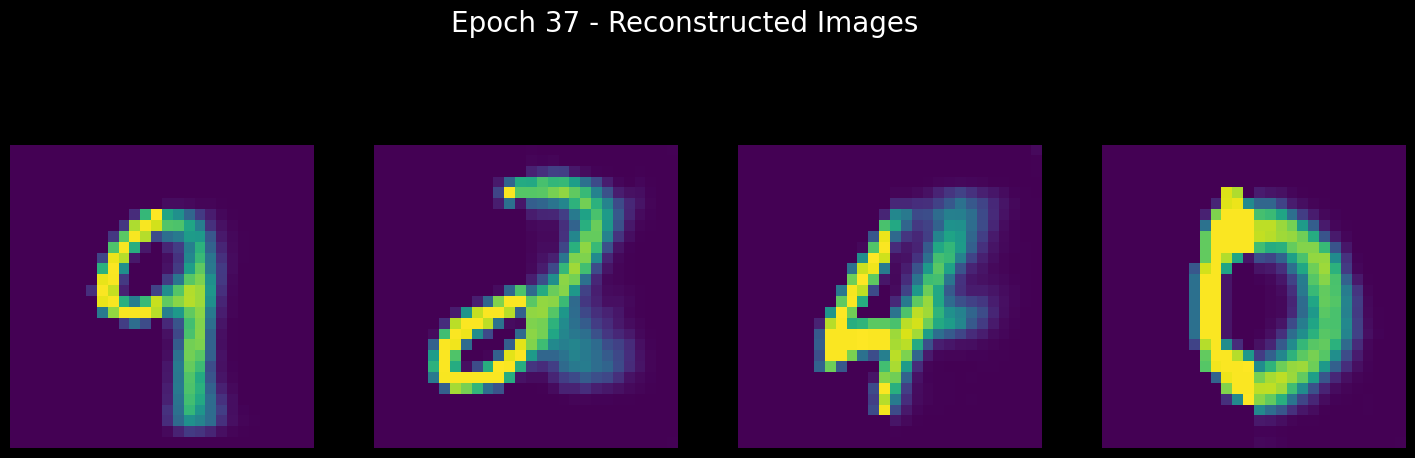

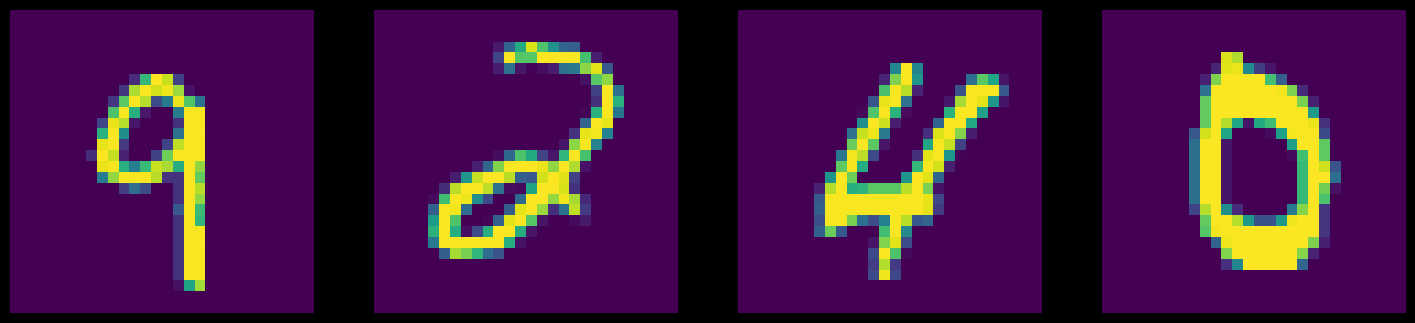

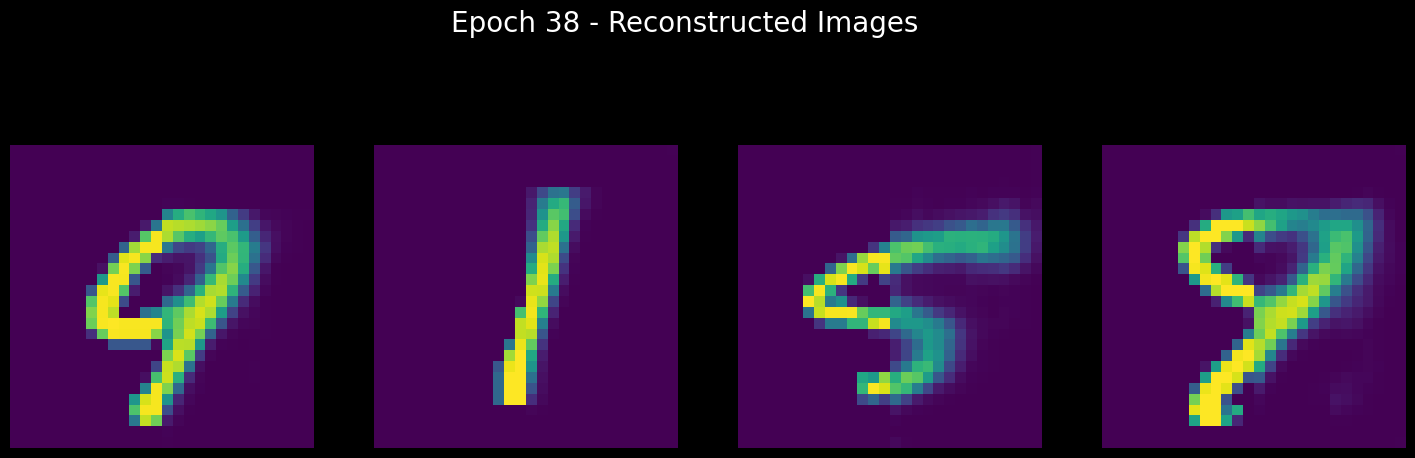

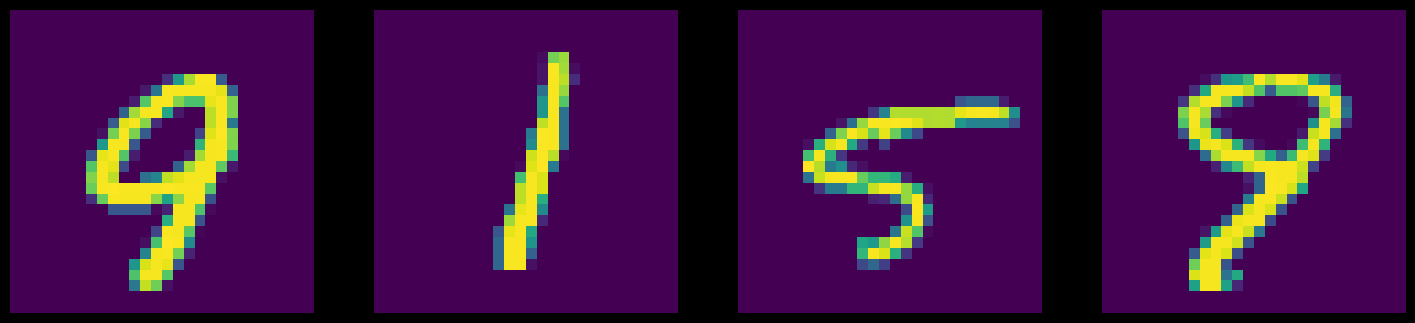

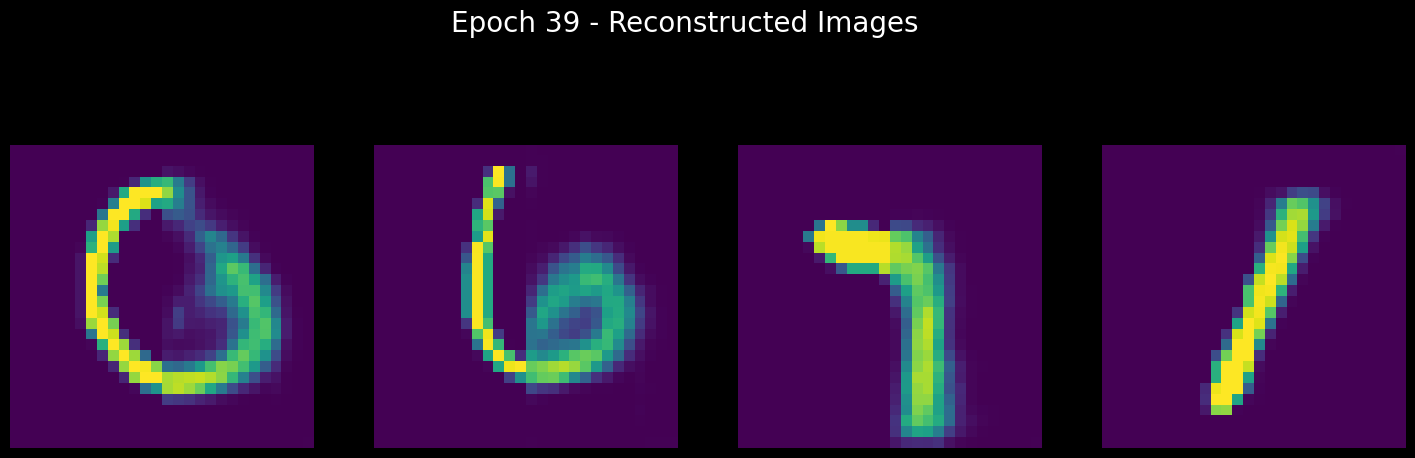

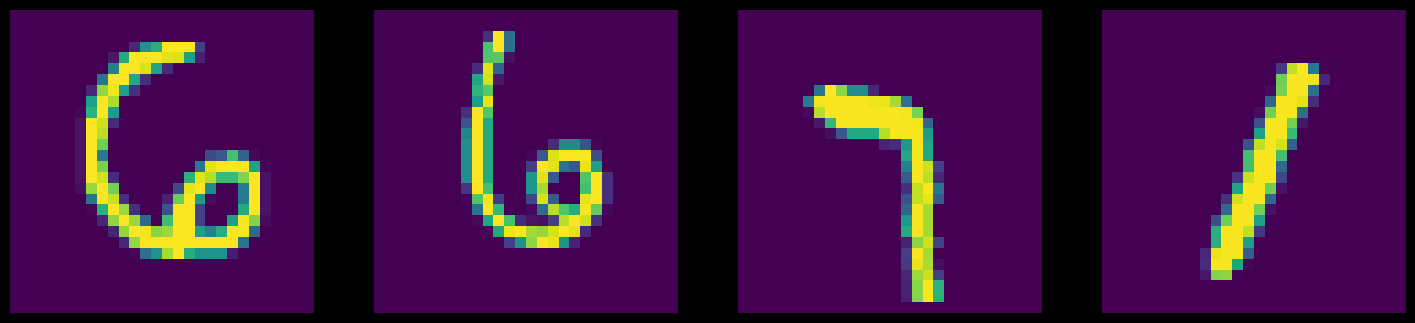

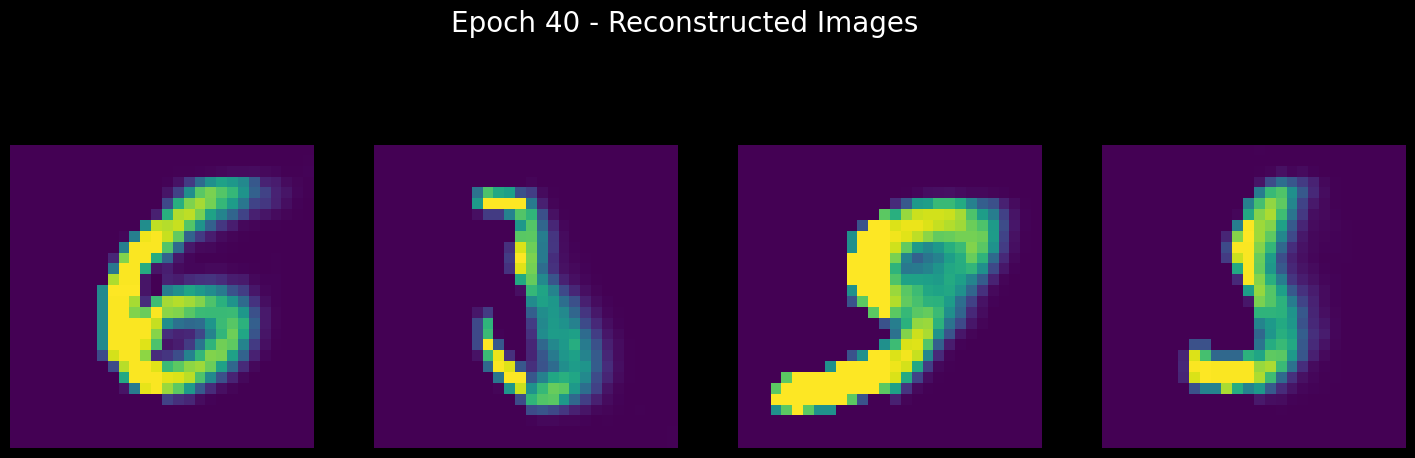

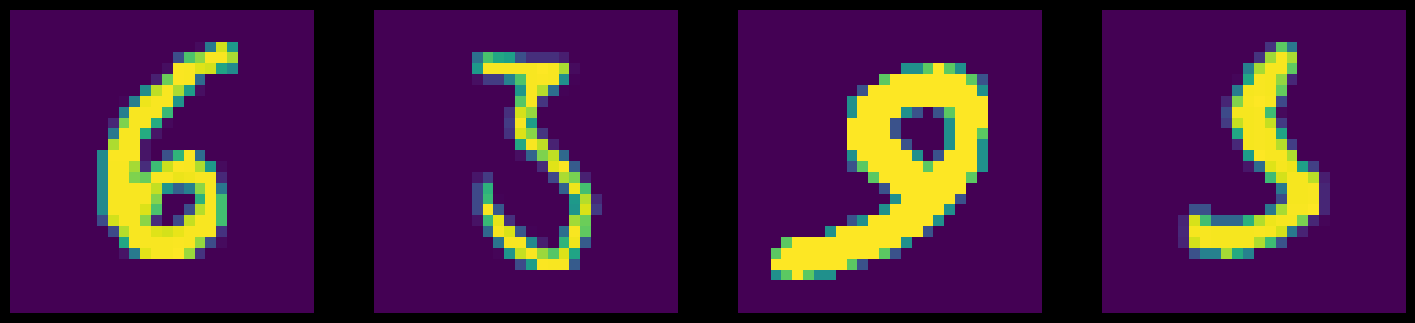

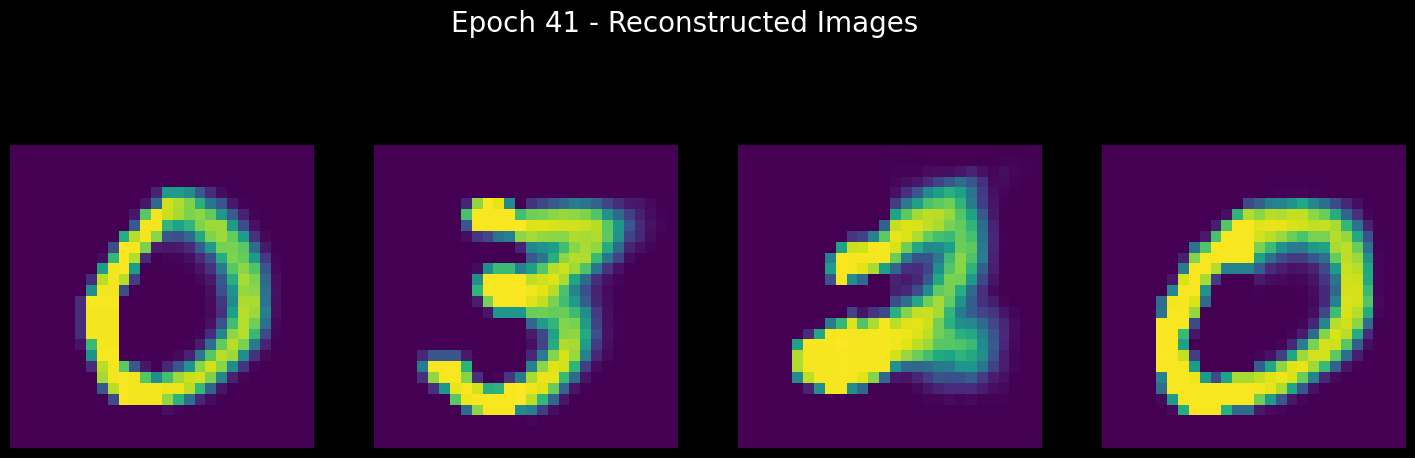

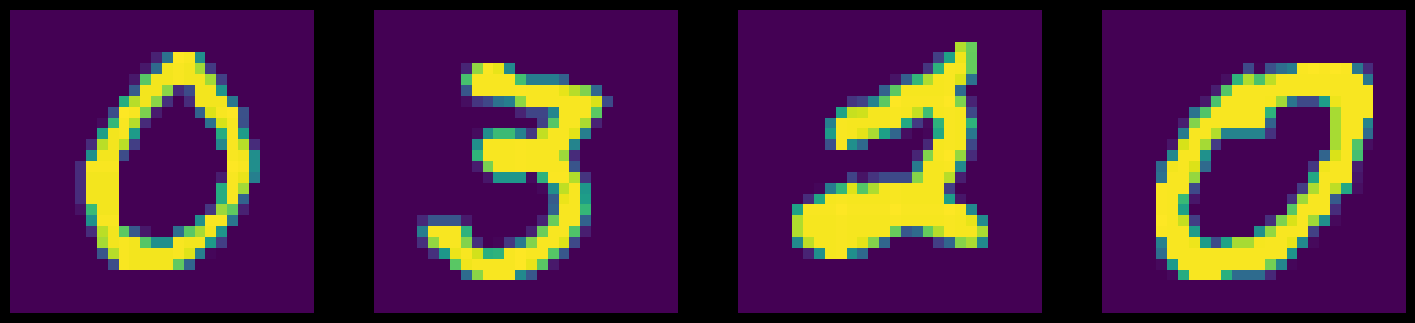

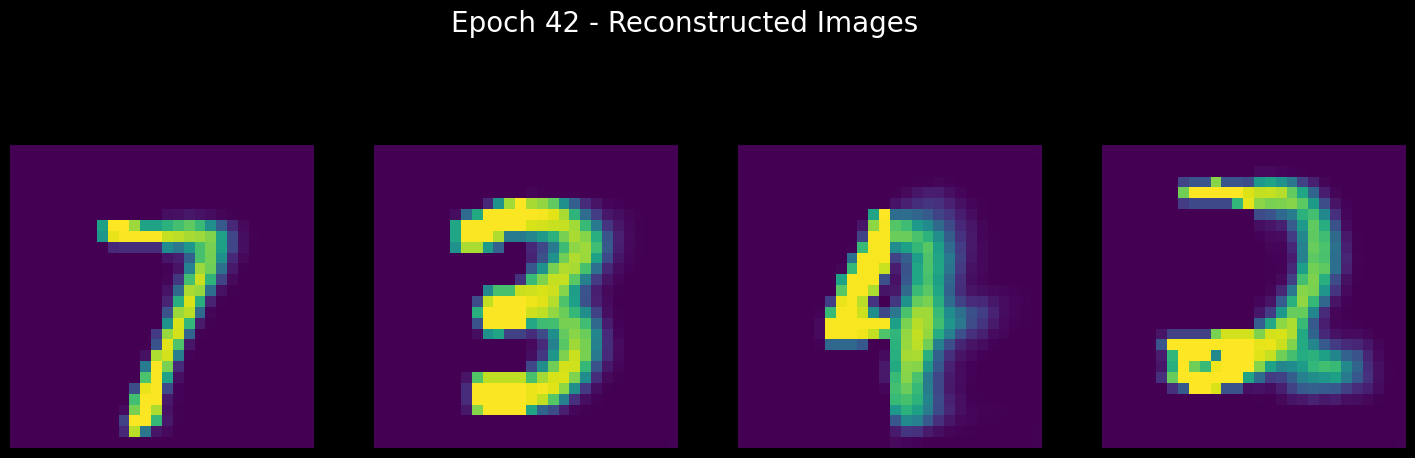

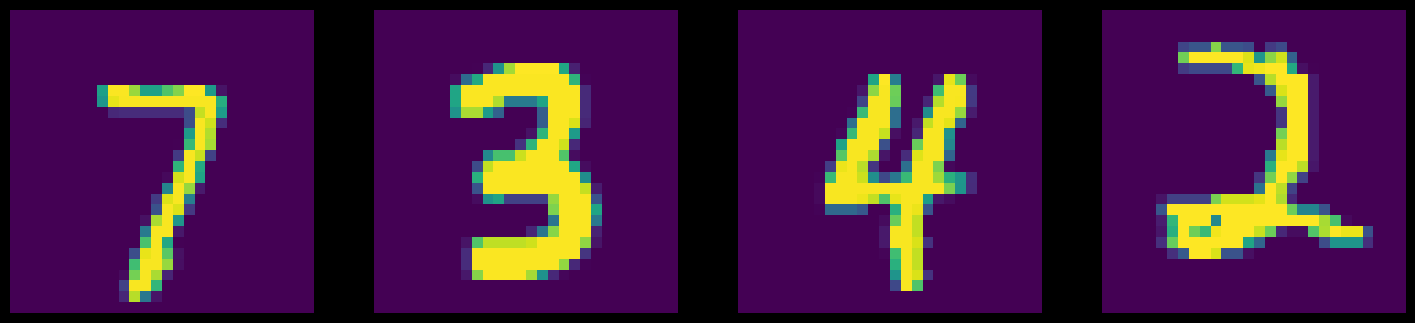

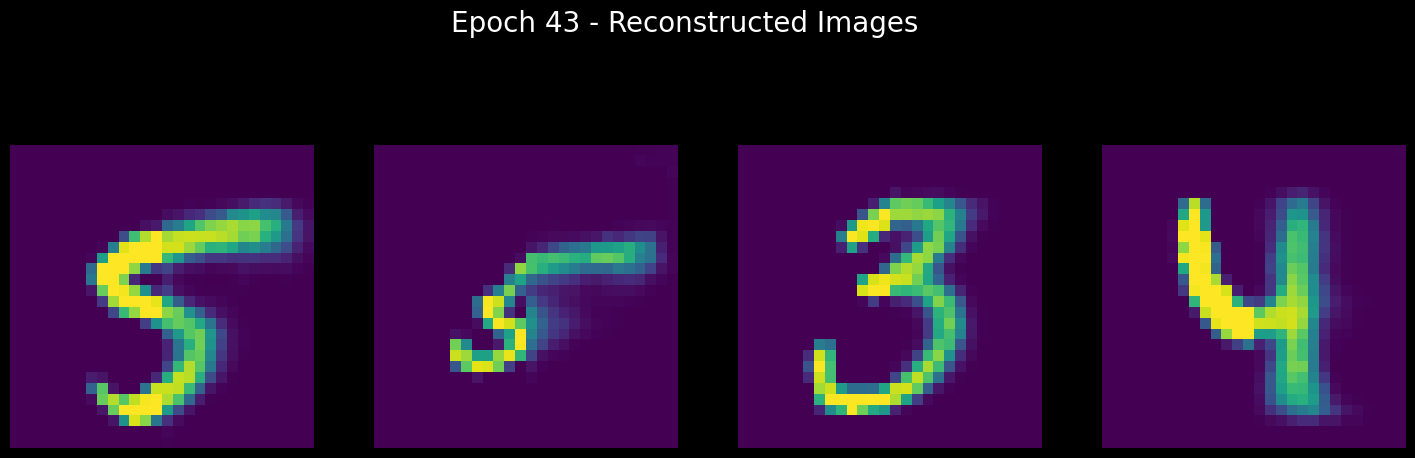

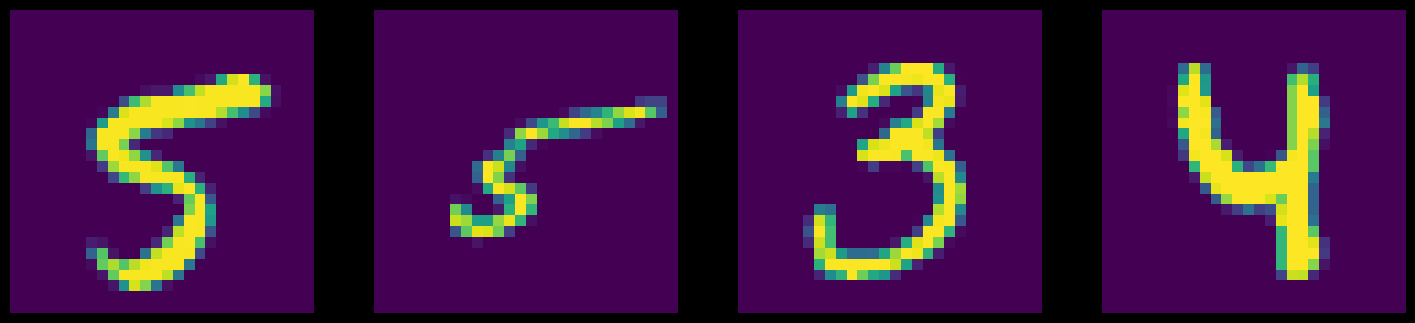

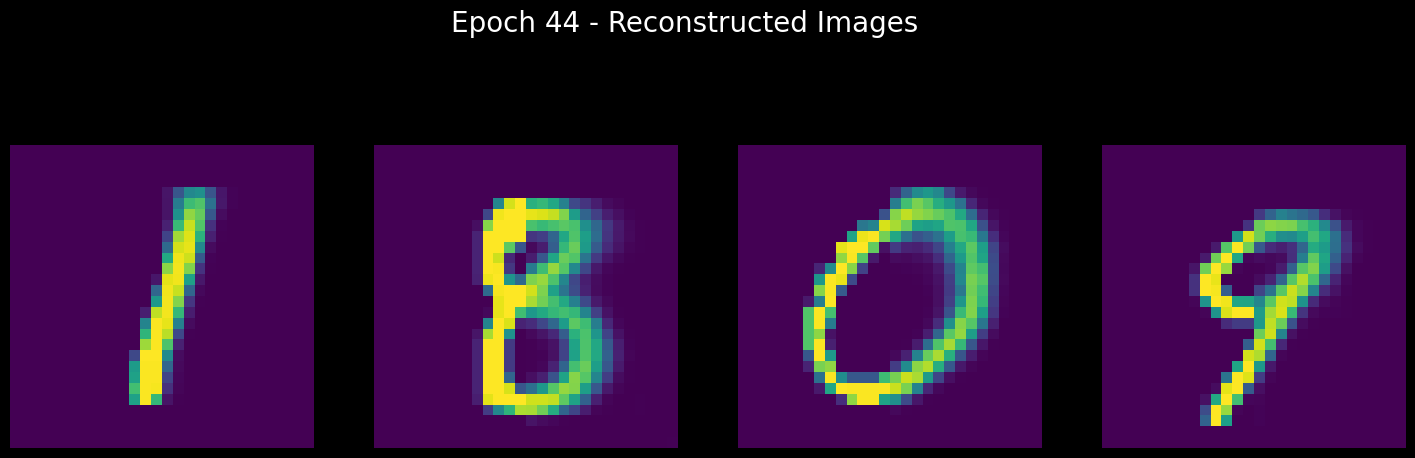

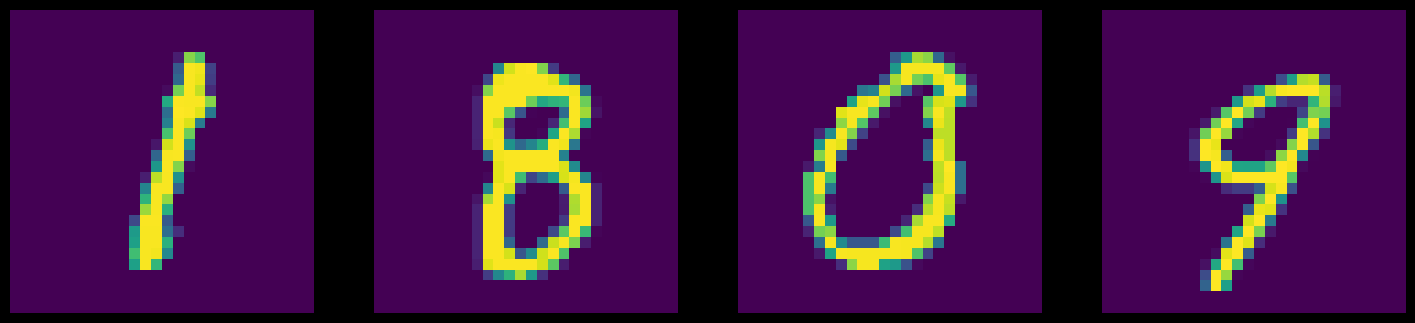

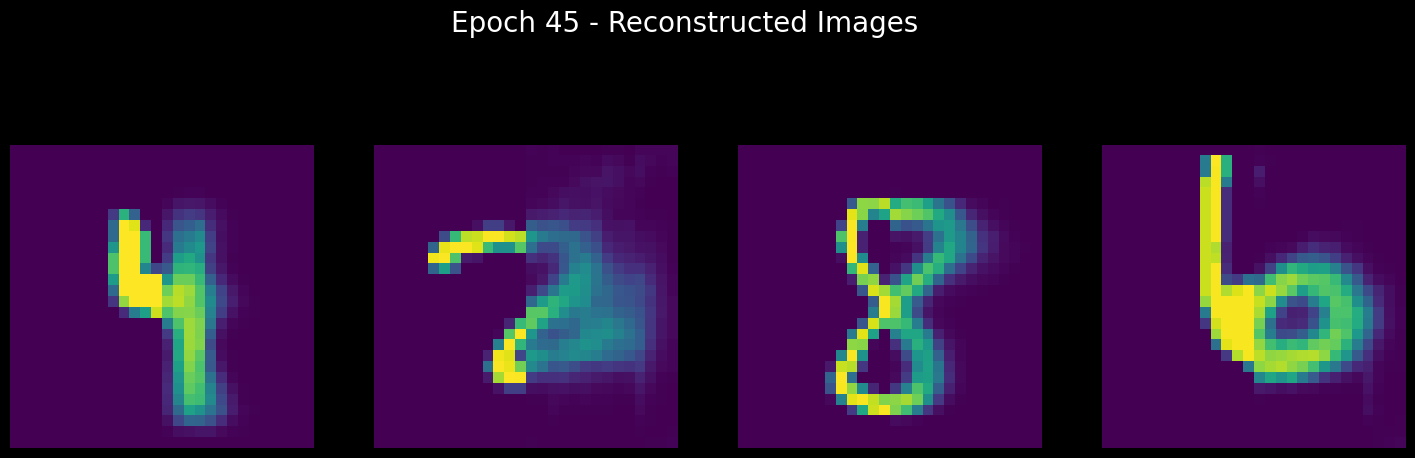

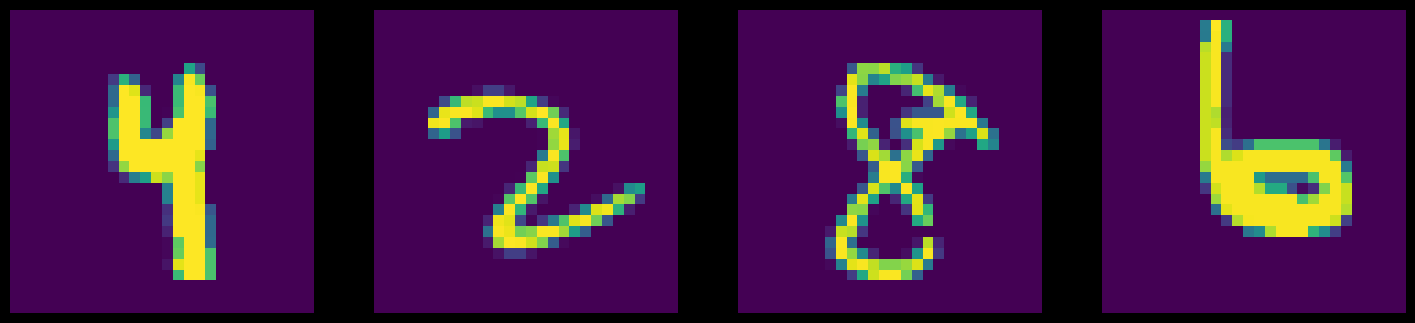

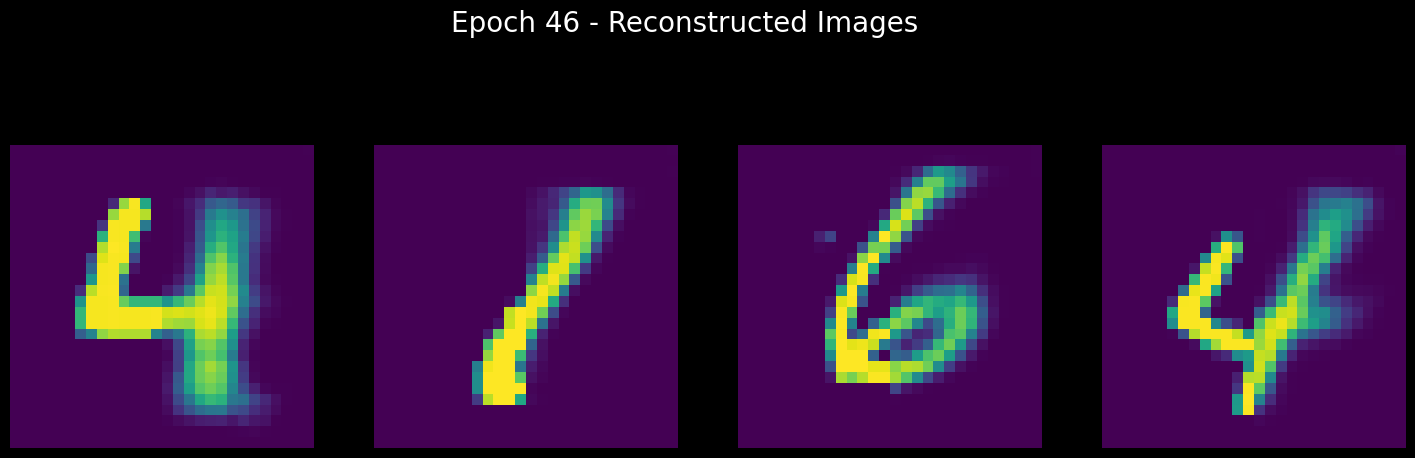

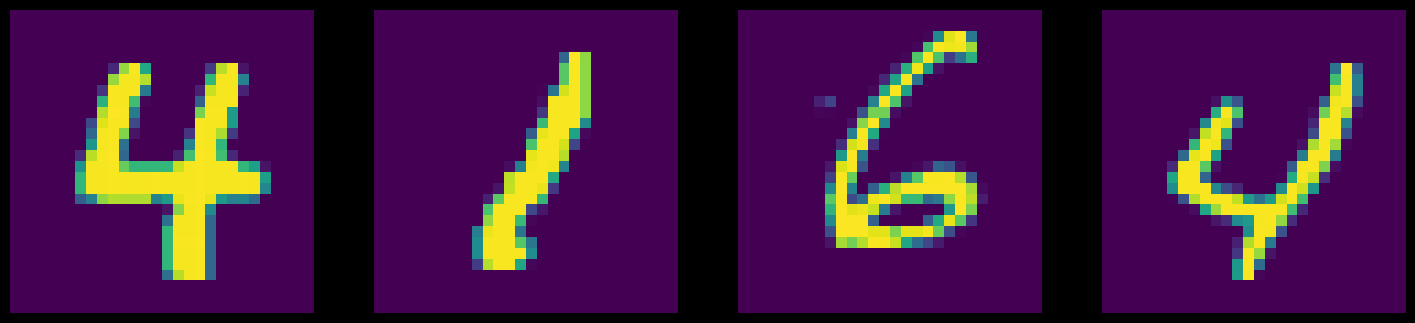

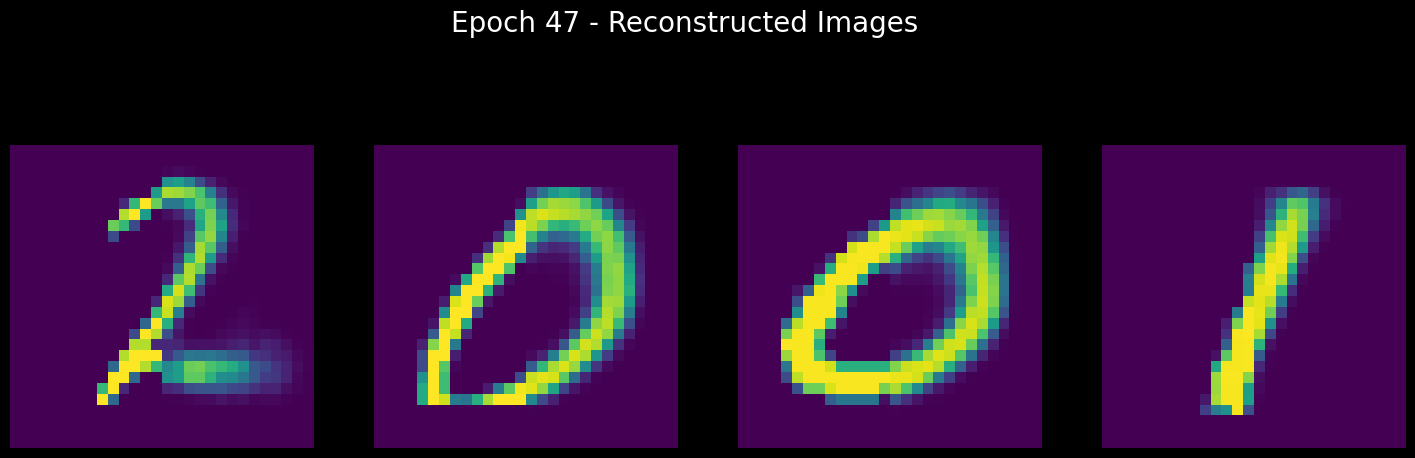

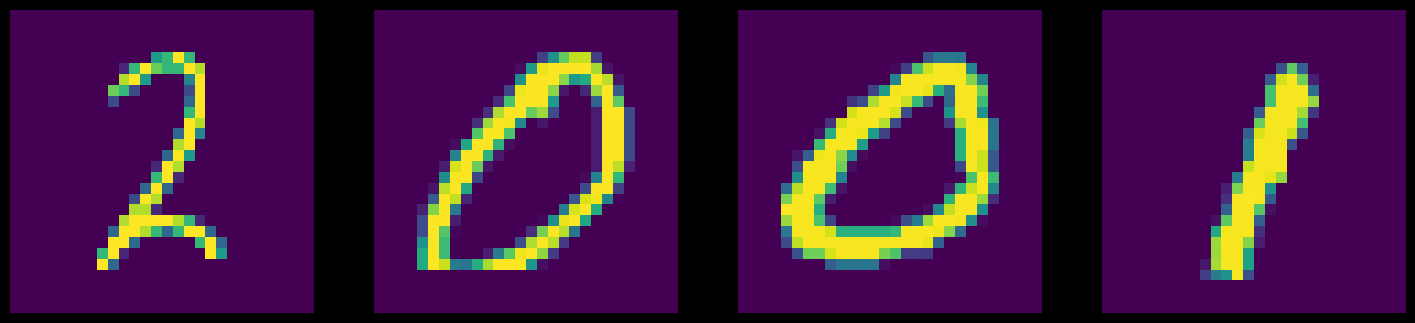

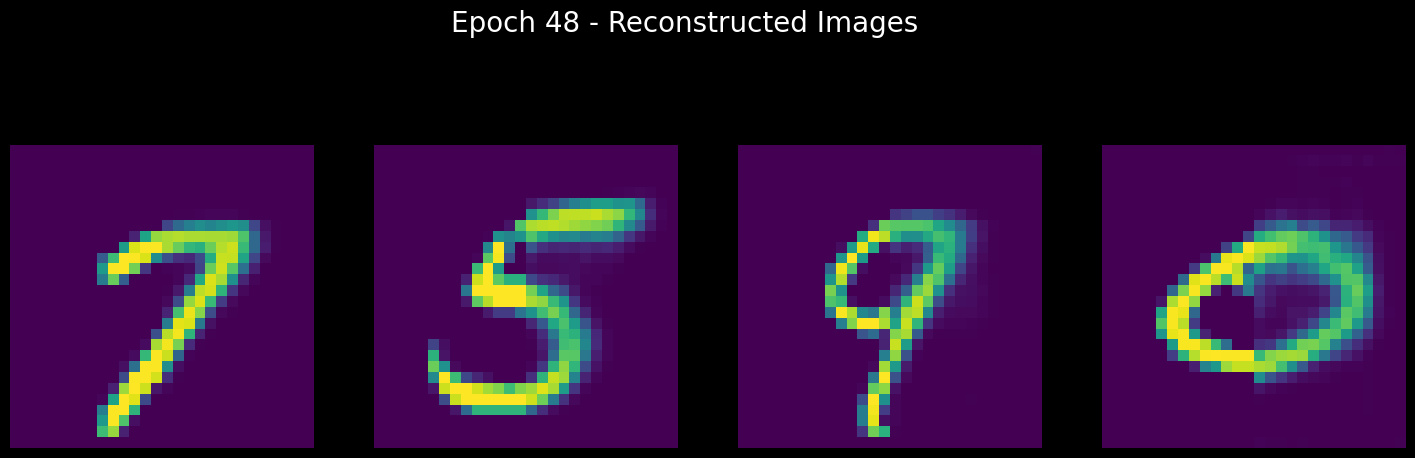

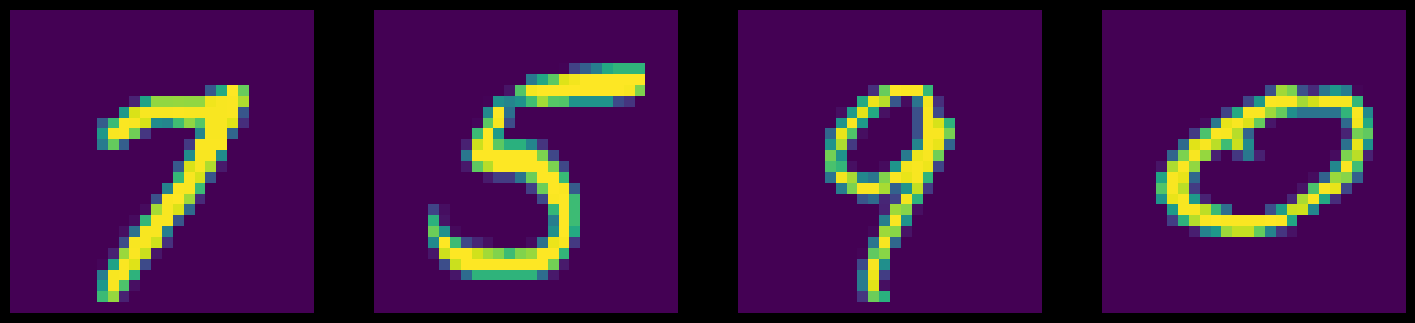

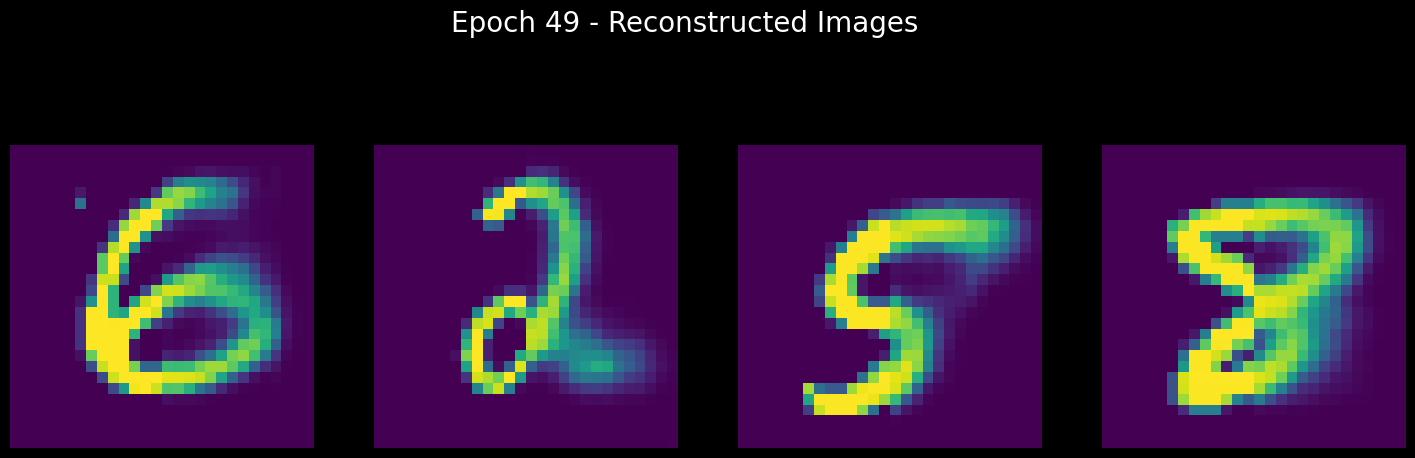

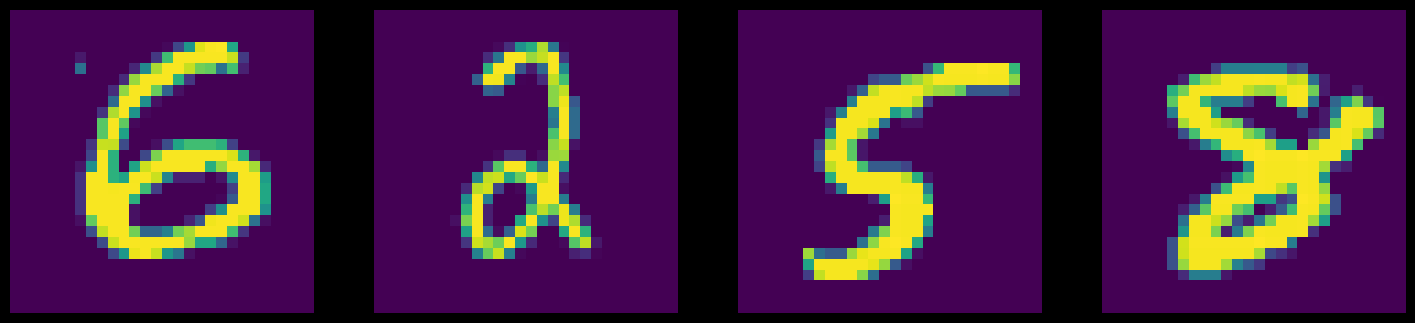

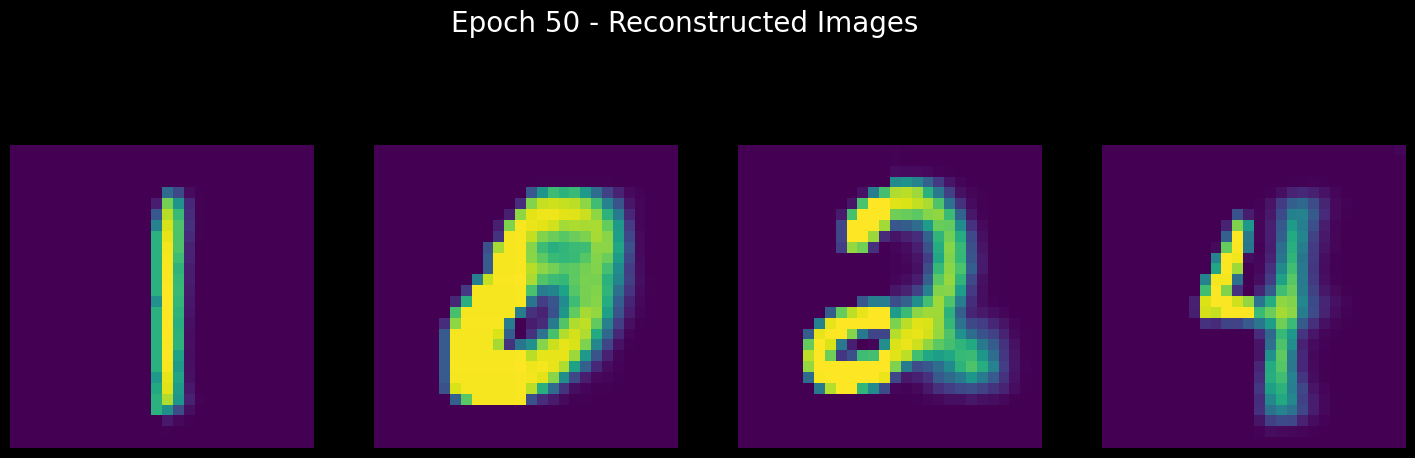

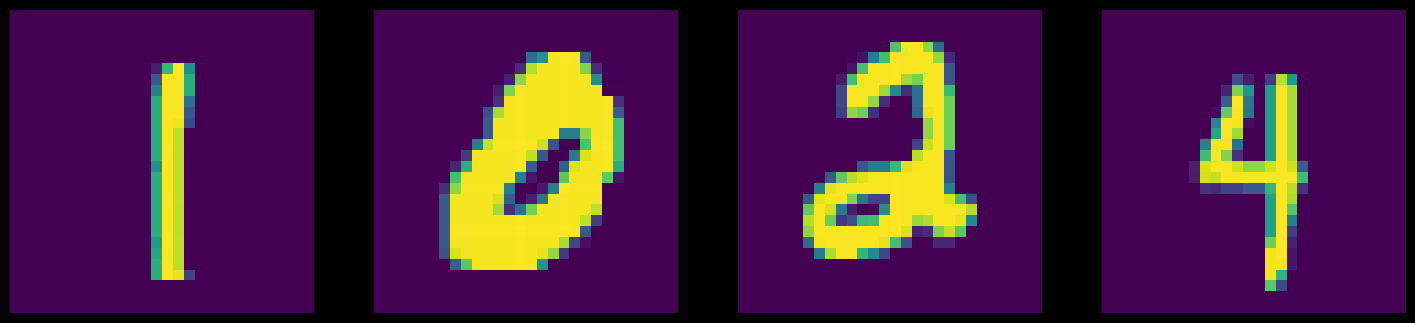

In [ ]:
# Training the model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):
    
    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(ds_train_loader.dataset):.4f}')
    
    # evaluate this epoch over the test set
    test_loss, means, logvars, labels, images = test(epoch)

    # log for analysis
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(ds_test_loader.dataset):.4f}')

In [ ]:
# save the state dict of the model
torch.save(model.state_dict(), 'vae-model.pt')

In [ ]:
# loading a saved module
device = torch.device('cpu')
model = VAE()
model.load_state_dict(torch.load('vae-model.pt',map_location=device))

### 2.2.3. Generating samples from the trained model

In [ ]:
# Generate 64 samples from the trained model and plot them.
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True)

# 3. Model Analysis

## 3.1. Interpolation - Start and End

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed
A, B = 980, 1000
codes.copy
sample = model.decoderLin(torch.stack((codes['μ'][epoch-1][A].data.cpu(), codes['μ'][epoch-1][B].data.cpu()), 0))
print(sample.shape)
sample = model.decoderConv(sample.view(-1,64,19,5))
display_images(None, torch.stack(((
    codes['x'][epoch-1][A].data.cpu().view(-1),
    codes['x'][epoch-1][B].data.cpu().view(-1),
    sample.data.cpu()[0].view(392),
    sample.data.cpu()[1].view(392)
))), 'Interpolation Start and End')

## 3.2. Interpolation in N

In [ ]:
# Perform a linear interpolation between 2 inputs A and B in the latent space and send it through the decoder
# by walking in the latent space we get to reconstruct things that look legit in the input space
N = 16
code = torch.Tensor(N, latent_size).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * codes['μ'][epoch-1][B].data + (1 - i / (N - 1) ) * codes['μ'][epoch-1][A].data
sample = model.decoderLin(code)
sample= model.decoderConv(sample.view(-1,64,19,5))
display_images(None, sample, 'Interpolation in N steps', N // 4, count=True)

## 3.3. Plot latent space

Showing a representation of the embeddings (of the means) of the test set where we perform a dimensionality reduction which shows how the encoder clusters all the means in different regions in the latent space.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 25,49)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N].cpu())
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [ ]:
set_default(figsize=(20, 6))

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

# 4. Semi-Supervised VAE

## 4.1. Prepare dataset

In [ ]:
# extract 100 labeled datapoints (10 from each class)
data_list, targets_list = [], []

# take 10 of each class
for class_ in range(10):
  idx = bin_ds_train.targets == class_
  data_list.append(bin_ds_train.data[idx][0:20, :, :])
  targets_list.append(bin_ds_train.targets[idx][0:20])

# convert the lists to tensors
mini_ds_data = torch.cat(data_list, 0)
mini_ds_targets = torch.cat(targets_list, 0)

# make sure the type is correct
mini_ds_data = mini_ds_data.to(dtype=torch.float32)
mini_ds_targets = mini_ds_targets.to(dtype=torch.long)

# create a dataset and a loader
mini_ds = TensorDataset(mini_ds_data, mini_ds_targets)
mini_dl = DataLoader(mini_ds, batch_size=200, drop_last=False, shuffle=False, num_workers=1, pin_memory=cuda)

# plot all the dataset
plot_samples_grid(mini_dl, n_rows=10, n_cols=20, title='Mini MNIST')

### 4.1.1. Creating a subset of the dataset

### 4.1.2. Process mini dataset to convert images to latent vectors

In [ ]:
with torch.no_grad():
  model.eval()
  for idx, data in enumerate(mini_dl,0):
    imgs, _ =data
    imgs = imgs.to(device)
    imgs.unsqueeze_(1)
    # encode
    mu, logvar = model.encode(imgs)
    # reparameterize (there will be 1 batch only)
    z = model.reparameterise(mu, logvar)

# make sure the type is correct
mini_ds_latent_vectors = z.to(dtype=torch.float32)


In [ ]:
# prepare the new mini dataset for training classifiers
latent_mini_ds = TensorDataset(mini_ds_latent_vectors, mini_ds_targets)
latent_mini_dl = DataLoader(latent_mini_ds, batch_size=4, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

## 4.2. Classifiers

In [ ]:
# to collect info about the performance of the various classifiers
clf_stats = {}

### 4.2.1. Linear Classifier

In [ ]:
# a simple linear model
class LinearClassifier(nn.Module):

  def __init__(self):
      super(LinearClassifier, self).__init__()
      
      self.layer_1 = nn.Linear(in_features=latent_size, out_features=10, bias=True)

  def forward(self, x):
    x = x.view(-1, latent_size)
    logits = self.layer_1(x)
    return F.log_softmax(logits, dim=1)

linearClassifier = LinearClassifier()

In [ ]:
criterion = nn.NLLLoss()
optimizer=torch.optim.RMSprop(linearClassifier.parameters(),learning_rate)
#optimizer = torch.optim.Adam(linearClassifier.parameters(), lr=0.001)

In [ ]:
epochs = 200
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1): 
  # train on the mini dataset (the latent version)
  linearClassifier.train()
  train_loss = 0
  for x, y in latent_mini_dl:
    x = x.to(device) # the latent vector
    y = y.to(device) # the target label
    # forward
    y_hat = linearClassifier(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(latent_mini_dl.dataset)
  train_loss_vals.append(train_loss)
  
  # evaluate over the whole test set
  with torch.no_grad():
    linearClassifier.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
        x = x.to(device) # the image
        y = y.to(device) # the target label

        # we need to encode to latent vectors
        model.eval()
        mu, logvar = model.encode(x)
        z = model.reparameterise(mu, logvar)

        # forward
        y_hat = linearClassifier(z)
        test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
        pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y.view_as(pred)).sum().item()

  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['m1_linear_model'] = max(test_accuracies)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

## 4.3. Baseline

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(784, 32)
    self.l2 = nn.Linear(32, 16)
    self.l3 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return F.log_softmax(x, dim=1)

baseline_model = Net().to(device)
print(baseline_model)

In [ ]:
criterion = nn.NLLLoss() # the negative log-likelihood loss.
#optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.5)
optimizer=torch.optim.RMSprop(baseline_model.parameters(),learning_rate)

In [ ]:
# use a different loader to adjust loading settings
bl_mini_dl = DataLoader(mini_ds, batch_size=5, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

In [ ]:
epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1):
  # train using only the 100 labeled data points
  baseline_model.train()
  train_loss = 0
  for x, y in bl_mini_dl:
    x = x.to(device)
    y = y.to(device)
    # forward
    y_hat = baseline_model(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(bl_mini_dl.dataset)
  train_loss_vals.append(train_loss)

  # evaluate over the whole test set
  with torch.no_grad():
    baseline_model.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
      x = x.to(device)
      y = y.to(device)

      # forward
      y_hat = baseline_model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
      pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(y.view_as(pred)).sum().item()
  
  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['baseline_model'] = max(test_accuracies)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

## 4.4. Overall comparison

In [ ]:
clf_stats

In [ ]:
names = list(clf_stats.keys())
values = list(clf_stats.values())

plt.style.use(['fivethirtyeight'])
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='silver')
plt.rc('figure', figsize=(10, 6), dpi=100)

plt.title('Accuracy Comparison')
bg = plt.bar(['NN Linear Model', 'Baseline NN'], values, color=(0.2, 0.4, 0.6, 0.6))
bg[1].set_color('crimson')